In [39]:
import os
import os.path as pth
import json
import ujson
import re
import itertools
from itertools import product
from collections import defaultdict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

import lang_analysis

from IPython.display import display, HTML
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 90
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction <a class="anchor" id="intro"></a>

This notebook performs the main analysis of experimental results for the paper [Emergence of Compositional Language with Deep Generational Transmission](https://arxiv.org/abs/1904.09067).

As described in the `README.md` for the whole codebase, each experiment is described by an exp code like `exp7.1.10.0.0.0`. Results are saved in json files stored in the directories corresponding to each experiment. For more about generating experimental results read the `README.md`.

There are a few different evaluation modes (described in `README.md`) that generate result files for different kinds of analysis. As described in the README, each mode corresponds to a slightly different script.
* `python run.py -m evaluate`: Main results; used in the [Test Set Accuracies](#acc-results) and [Accuracy T-Tests](#acc-ttest) sections.
* `python run.py -m evaluate_lang`: Language comparison results: used in the [Intra Generational Language Simlarity](#lang-sim) and [Language Visualization](#lang-vis) sections.
* `python run.py -m evaluate_gen`: [Accuracy By Generation](#acc-gen)

# Table of Contents <a class="anchor" id="toc"></a>


* [Introduction](#intro)
* [Table of Contents](#toc)
* [Support Code](#code)
    * [Loading Experiment Results](#load-code)
    * [Tabular Results Displays](#display-code)
    * [T-Test Figures](#ttest-code)
* [Results](#results)
    * [Test Set Accuracies](#acc-results)
    * [Accuracy T-Tests](#acc-ttest)
        * [By Model](#acc-ttest-model)
        * [By Replacement Method](#acc-ttest-method)
    * [Intra Generational Language Simlarity](#lang-sim)
    * [Language Visualization](#lang-vis)
    * [Accuracy By Generation](#acc-gen)    

# Support Code <a class="anchor" id="code"></a>

## Loading Experiment Results <a class="anchor" id="load-code"></a>

This section provides code for loading experimental results from json files. Though it is not ideal, two global variables are fairly important: `records` and `columns`. These hold a set of experimental data that can be transformed into a pandas DataFrame. As seen below, different sets of experiments are specified and loaded (into `records` and `columns`) immediately before their analysis.

Note that the json files are cached, so they are only read from disk once on demand. If you generate more results after loading those files then you may need to refresh the cache (by running the few lines below) to use the recently generated results.

In [16]:
# only run this once; it caches result files
json_file_data = {}

In [17]:
# cross-generational analysis (contains results across generations instead of just at the final generation)
json_file_data_gen = {}
json_many_epochs_file_data = {}

In [18]:
# language analysis (contains rollouts of actual dialog utterances)
json_lang_file_data = {}

In [40]:
def fresh():
    global columns, records, \
        exp_data, default_models, default_training, \
        default_datasets, default_teaching, default_folds, default_seeds
    print('fresh')
    columns = ['model', 'method', 'dataset', 'fold', 'seed', 'exp_name', 'teaching', 'nqbots', 'nabots',
           'train_both', 'train_first', 'train_second', 'train_one',
           'train_OO_both', 'train_OO_first', 'train_OO_second', 'train_OO_one',
           'test_both', 'test_first', 'test_second', 'test_one',
           'test_OY_both', 'test_OY_first', 'test_OY_second', 'test_OY_one',
           'test_OO_both', 'test_OO_first', 'test_OO_second', 'test_OO_one',
           'val_both', 'val_first', 'val_second', 'val_one',
           'val_OY_both', 'val_OY_first', 'val_OY_second', 'val_OY_one',
           'val_OO_both', 'val_OO_first', 'val_OO_second', 'val_OO_one']

    records = []
    exp_data = {}
    default_models = [(-100, 'overcomplete (?)')]
    default_training = [(-100, 'uniform random (?)')]
    default_datasets = [(-100, 'emnlp_cv (?)')]
    default_teaching = [(-100, 'task-1 teach-1 (?)')]
    default_folds = [(0, '0 (?)')]
    default_seeds = [(0, '0 (?)')]
fresh()

def add_fresh_experiment(force_load=False, fixed_epoch=False):
    fresh()
    add_experiment(force_load, fixed_epoch=fixed_epoch)

train_only_datasets = ['emnlp', 'comp_nocv']
def add_experiment(force_load=False, fixed_epoch=False):
    # enumerate configurations for the experiments to add
    config_tuples = itertools.product(models, training, teaching, datasets, folds, seeds)
    for tup in config_tuples:
        mi, model = tup[0]
        ti, train = tup[1]
        tei, teach = tup[2]
        di, ds = tup[3]
        fi, fold = tup[4]
        si, seed = tup[5]
        name = exp_name(mi=mi, ti=ti, tei=tei, di=di, fi=fi, si=si)

        if fixed_epoch:
            # end of the 7th generation
            assert name.startswith('exp7')
            ep_key = '39000' if ti in [0, 5, 6, 7] else '199000'
            result_fname = 'results_ep_{}.json'.format(ep_key)
            print('fixed epoch, using {}'.format(result_fname))
        else:
            result_fname = 'results.json'
            ep_key = 'null'

        if ds in train_only_datasets and (fi != 0):
            continue
        if name not in json_file_data:
            fname = pth.join('data/experiments/', name, 'models', result_fname)
            if not pth.exists(fname):
                print('skipping ' + name + ' (could not find {})'.format(fname))
                continue
            with open(fname, 'r') as f:
                data = json.load(f)
            json_file_data[name] = data
        else:
            data = json_file_data[name]
        if ep_key not in data:
            print('skipping ' + name + " (no model for epoch key={} results entry)".format(ep_key))
            print(data.keys())
            continue
        exp_data[name] = data
        print('added ' + name + ' ()')
        # the emnlp dataset doesn't have a test set (it's val set is the same as emnlp_cv's test set)
        test_key = 'val' if ds in train_only_datasets else 'test'
        records.append((model, train, ds, fold, seed, name, teach, data[ep_key]['qbots'], data[ep_key]['abots'],
                        np.mean(data[ep_key]['train']['both']),
                        np.mean(data[ep_key]['train']['first']),
                        np.mean(data[ep_key]['train']['second']),
                        np.mean(data[ep_key]['train']['atleast']),
                        data[ep_key]['train']['old_qbot_old_abot']['both'],
                        data[ep_key]['train']['old_qbot_old_abot']['first'],
                        data[ep_key]['train']['old_qbot_old_abot']['second'],
                        data[ep_key]['train']['old_qbot_old_abot']['atleast'],
                        np.mean(data[ep_key][test_key]['both']),
                        np.mean(data[ep_key][test_key]['first']),
                        np.mean(data[ep_key][test_key]['second']),
                        np.mean(data[ep_key][test_key]['atleast']),
                        data[ep_key][test_key]['old_qbot_young_abot']['both'],
                        data[ep_key][test_key]['old_qbot_young_abot']['first'],
                        data[ep_key][test_key]['old_qbot_young_abot']['second'],
                        data[ep_key][test_key]['old_qbot_young_abot']['atleast'],
                        data[ep_key][test_key]['old_qbot_old_abot']['both'],
                        data[ep_key][test_key]['old_qbot_old_abot']['first'],
                        data[ep_key][test_key]['old_qbot_old_abot']['second'],
                        data[ep_key][test_key]['old_qbot_old_abot']['atleast'],
                        np.mean(data[ep_key]['val']['both']),
                        np.mean(data[ep_key]['val']['first']),
                        np.mean(data[ep_key]['val']['second']),
                        np.mean(data[ep_key]['val']['atleast']),
                        data[ep_key]['val']['old_qbot_young_abot']['both'],
                        data[ep_key]['val']['old_qbot_young_abot']['first'],
                        data[ep_key]['val']['old_qbot_young_abot']['second'],
                        data[ep_key]['val']['old_qbot_young_abot']['atleast'],
                        data[ep_key]['val']['old_qbot_old_abot']['both'],
                        data[ep_key]['val']['old_qbot_old_abot']['first'],
                        data[ep_key]['val']['old_qbot_old_abot']['second'],
                        data[ep_key]['val']['old_qbot_old_abot']['atleast'],
                       ))

fresh


In [41]:
def fresh_gen():
    global columns_gen, records_gen, \
        exp_data_gen
    print('fresh gen')
    columns_gen = ['model', 'method', 'dataset', 'fold', 'seed', 'exp_name', 'teaching', 'nqbots', 'nabots',
                   'ep_key', 'epoch',
                   'test_both', 'iq', 'ia',
                   'q_gen', 'a_gen']
    records_gen = []
    exp_data_gen = {}
fresh_gen()

def add_fresh_experiment_gen(force_load=False, fixed_epoch=False):
    fresh_gen()
    add_experiment_gen(force_load, fixed_epoch=fixed_epoch)

# gather cross-generational experiment data
def add_experiment_gen(force_load=False, fixed_epoch=False):
    global hi
    # enumerate configurations for the experiments to add
    config_tuples = itertools.product(models, training, teaching, datasets, folds, seeds)
    for tup in config_tuples:
        mi, model = tup[0]
        ti, train = tup[1]
        tei, teach = tup[2]
        di, ds = tup[3]
        fi, fold = tup[4]
        si, seed = tup[5]
        name = exp_name(mi=mi, ti=ti, tei=tei, di=di, fi=fi, si=si)

        if fixed_epoch:
            # end of the 7th generation
            assert name.startswith('exp7')
            ep_max =   39000 if ti in [0, 5, 6, 7] else 199000
            ep_period = 5000 if ti in [0, 5, 6, 7] else 25000
            ep_keys = [e - 1000 for e in range(ep_period, ep_max+1, ep_period)]
            ep_keys = list(map(str, ep_keys))
        else:
            assert False
            result_fname = 'results_gen.json'
            ep_key = 'null'

        result_fname = 'results_gen_{}.json'.format(ep_max)
        print('fixed epoch, using {}'.format(result_fname))

        if ds in train_only_datasets and (fi != 0):
            continue
        if name not in json_file_data_gen:
            fname = pth.join('data/experiments/', name, 'models', result_fname)
            if not pth.exists(fname):
                print('skipping ' + name + ' (could not find {})'.format(fname))
                continue
            with open(fname, 'r') as f:
                data = json.load(f)
            json_file_data_gen[name] = data
        else:
            data = json_file_data_gen[name]

        for ep_key in ep_keys:
            if ep_key not in data:
                print('skipping ' + name + " (no model for epoch key={} results entry)".format(ep_key))
                print(data.keys())
                continue
            try:
                epoch = int(ep_key)
            except:
                epoch = -1
            exp_data_gen[name] = data
            print('added ' + name + ' (ep={})'.format(ep_key))
            # the emnlp dataset doesn't have a test set (it's val set is the same as emnlp_cv's test set)
            test_key = 'val' if ds in train_only_datasets else 'test'
            hi = data[ep_key]
            NQ, NA = data[ep_key]['qbots'], data[ep_key]['abots']
            for iq in range(NQ):
                for ia in range(NA):
                    records_gen.append((model, train, ds, fold, seed, name, teach, NQ, NA,
                                        ep_key, epoch,
                                    data[ep_key][test_key]['both'][iq][ia], iq, ia,
                                    data[ep_key]['generations']['qbot'][iq],
                                    data[ep_key]['generations']['abot'][ia],
                                   ))

fresh gen


In [42]:
def load_many_epochs_exp(name, results_name='results_many_epochs.json'):
    if name not in json_many_epochs_file_data:
        fname = pth.join('data/experiments/', name, 'models', results_name)
        if not pth.exists(fname):
            print('skipping ' + name + ' (could not find {})'.format(fname))
        with open(fname, 'r') as f:
            data = json.load(f)
        json_many_epochs_file_data[name] = data
    else:
        data = json_many_epochs_file_data[name]
    return data

In [43]:
def fresh_lang():
    global lang_columns, lang_records, \
        exp_lang_data
    print('fresh lang')

    lang_columns = ['model', 'method', 'dataset', 'fold', 'seed', 'exp_name', 'teaching', 'nqbots', 'nabots',
            'epoch', 'abot_dist', 'qbot_dist', 'abot_ent', 'ia', 'ja']
    lang_records = []
    exp_lang_data = {}
fresh_lang()

def add_fresh_lang_experiment(fixed_epoch=False):
    fresh_lang()
    add_lang_experiment(fixed_epoch=fixed_epoch)

def add_lang_experiment(fixed_epoch=False):
    global hi
    # enumerate configurations for the experiments to add
    config_tuples = itertools.product(models, training, teaching, datasets, folds, seeds)
    for tup in config_tuples:
        mi, model = tup[0]
        ti, train = tup[1]
        tei, teach = tup[2]
        di, ds = tup[3]
        fi, fold = tup[4]
        si, seed = tup[5]

        if ds in train_only_datasets and (fi != 0):
            continue
        name = exp_name(mi=mi, ti=ti, tei=tei, di=di, fi=fi, si=si)
        if name not in json_lang_file_data:
            if fixed_epoch:
                # end of the 7th generation
                assert name.startswith('exp7') or name.startswith('exp9')
                ep_key = '39000' if ti in [0, 5, 6, 7] else '199000'
                fname = pth.join('data/experiments/', name, 'models/results_lang_analysis_ep_{}.json'.format(ep_key))
                print('fixed epoch, using {}'.format(fname))
            else:
                fname = pth.join('data/experiments/', name, 'models/results_lang_analysis.json')
            if not pth.exists(fname):
                print('[lang] skipping ' + name + ' (could not find {})'.format(fname))
                continue
            with open(fname, 'r') as f:
                data = json.load(f)
            json_lang_file_data[name] = data
        else:
            data = json_lang_file_data[name]
        exp_lang_data[name] = data
        print('[lang] added ' + name)

        epochs = sorted([int(k) for k in data if k not in ['null', 'initial']])
        if 'null' in data:
            epochs.append('null')
        if 'initial' in data:
            epochs.append('initial')
        print(epochs)
        Nq = data[str(epochs[0])]['qbots']
        Na = data[str(epochs[0])]['abots']
        for epoch in epochs:
            NQ, NA = data[str(epoch)]['qbots'], data[str(epoch)]['abots']
            for ia in range(NA):
                for ja in range(NA):
                    if ja == ia:
                        continue

                    abot_dist = data[str(epoch)]['test']['abot_lang_dists'][ia][ja]
                    #Na = abot_dists.shape[0]
                    #anondiag_idx = np.where(~np.eye(Na, dtype=np.bool))
                    #abot_dist = abot_dists[anondiag_idx].mean()

                    if 'qbot_lang_dists' in data[str(epoch)]['test']:
                        assert NA == NQ
                        # for convenience.... this only works if NA == NQ, otherwise separate DataFrames would work
                        qbot_dist = data[str(epoch)]['test']['qbot_lang_dists'][ia][ja]
                        #Nq = qbot_dists.shape[0]
                        #qnondiag_idx = np.where(~np.eye(Nq, dtype=np.bool))
                        #qbot_dist = qbot_dists[qnondiag_idx].mean()
                    else:
                        qbot_dist = -1

                    if 'abot_lang_entropies' in data[str(epoch)]['test']:
                        abot_ent = data[str(epoch)]['test']['abot_lang_entropies'][ia]
                    else:
                        abot_ent = -1
                    hi = data[str(epoch)]['test']
                    #if 'qbot_lang_entropies' in data[str(epoch)]['test']:
                    #    qbot_ent = data[str(epoch)]['test']['qbot_lang_entropies']
                    #else:
                    #    qbot_ent = -1

                    lang_records.append((model, train, ds, fold, seed, name, teach,
                                 Nq, Na, epoch, abot_dist, qbot_dist, abot_ent, ia, ja))

fresh lang


## Display Results as Grouped DataFrame or LaTeX table <a class="anchor" id="display-code"></a>

This section displays result DataFrames in two different tabular formats. The first is convenient for display in this notebook. The second is convenient for pasting into LaTeX documents.

In [44]:
def show_records(gb=['method'], fields=['train_OO_both', 'val_OO_both', 'test_OO_both', 'test_OO_one'],
                 agg_methods=['mean', 'std', 'median', 'max', 'count']):
    df = pd.DataFrame.from_records(records, columns=columns)
    gf = df.groupby(gb).agg(agg_methods)[fields]
    display(gf.style.background_gradient(cmap=sns.light_palette("green", as_cmap=True)))

In [45]:
def show_latex(gb=['method'],
               fields=['train_OO_both', 'val_OO_both', 'test_OO_both', 'test_OO_one']):
    df = pd.DataFrame.from_records(records, columns=columns)
    gf = df.groupby(gb).agg(['mean', 'std'])[fields]
    
    result_cols = []
    for field in fields:
        result_cols.append('result ' + field)
        gf['result ' + field] = gf[(field, 'mean')].map(lambda s: '{:.2f}'.format(s)) + ' $\pm$ ' + \
                                gf[(field, 'std')].map(lambda s: '{:5.1f}'.format(s))

    def agg(results):
        assert len(results) == 1
        return results[0]
    pivot = pd.pivot_table(gf[result_cols], index=['method'], columns=['model'], values=result_cols, aggfunc=agg)
    display(pivot)
    print(pivot.to_latex(escape=False))

## Statistical Analysis <a class="anchor" id="ttest-code"></a>

This function generates paired t-test results between all specified experiments.

In [46]:
def show_ttests(stat='test_OO_both', df_filter=lambda df: df, threshold=True, pthresh=0.05, show_t=False, df=None):
    if df is None:
        df = pd.DataFrame.from_records(records, columns=columns)
    #df = df[df.model == models[3][1]]
    #df = df[df.method == training[4][1]]
    df = df_filter(df)
    kwargs = {}

    settings = list(product(df.model.unique(), df.method.unique()))
    pval = np.zeros([len(settings), len(settings)])
    tval = np.zeros([len(settings), len(settings)])
    for i, tup1 in enumerate(settings):
        for j, tup2 in enumerate(settings):
            model1, method1 = tup1
            model2, method2 = tup2
            df1 = df[df.model == model1]
            df1 = df1[df1.method == method1]
            #df1 = df1.reset_index()

            df2 = df[df.model == model2]
            df2 = df2[df2.method == method2]
            #df2 = df2.reset_index()

            test_result = stats.ttest_rel(df1[stat], df2[stat])
            tval[i,j] = test_result.statistic  
            pval[i,j] = test_result.pvalue

    labels = list(map(str, settings))
    if show_t == True: # not 'both'
        mat = tval
    else:
        mat = pval
    if threshold:
        if show_t == True: # not 'both'
            mat = np.sign(mat)
        else:
            mat = (mat < pthresh)
    if show_t == 'both':
        annot = ['p={:.3f}\n(t={:.2f})'.format(p, t) for p, t in zip(pval.flat, tval.flat)]
        annot = np.array(annot).reshape(pval.shape)
        kwargs['fmt'] = ''
    else:
        annot = mat
    if show_t != False: # 'both' and True
        kwargs['vmin'] = 0
        kwargs['vmax'] = 1
    return sns.heatmap(mat, xticklabels=labels, annot=annot, **kwargs)

# Results <a class="anchor" id="results"></a>

## Test Set Accuracies <a class="anchor" id="acc-results"></a>

In [48]:
# exp7 - emnlp no cross-val dataset - comparison to prev work
# NOTE: run this before the main results so the main result dataframe is used for the next section
exp_name = lambda mi, ti, di, fi, si, **k: 'exp7.{}.{}.{}.{}.{}'.format(mi, ti, di, fi, si)
models = [(0, 'Memoryless + Minimal Vocab'),
          ('2', 'Minimal Vocab'), #  (old: Va=4,Vq=3)
          (1, 'Overcomplete'),
          ('3', 'Memoryless + Overcomplete'),
          #('4', 'Small Vocab (Va=12, Vq=3)'),
         ]
training = [(0, 'Single No Replacement'),
            #(7, 'Single Replace All'),
            #(8, 'Multi All (shorter)'), # shorter
            (5, 'Single Random'),
            (6, 'Single Oldest'),
            (1, 'Multi No Replacement'), # shorter
            #(9, 'Multi Replace All'), # longer
            #(2, 'Multi Uniform Random (shorter)'), # shorter
            #(3, 'Multi Epsilon Greedy (shorter)'), # shorter
            #(4, 'Multi Oldest (shorter)'), # shorter
            (11, 'Multi Uniform Random'), # longer
            (12, 'Multi Epsilon Greedy'), # longer
            (10, 'Multi Oldest'), # longer
           ]
datasets = [(3, 'emnlp_nocv')]
teaching = [(1, 'task-1 teach-1')]
folds = [(0, 0)] #, (1, 1), (2, 2), (3, 3)]
seeds = [(0, 0), (1, 1), (2, 2), (3, 3)]

add_fresh_experiment(fixed_epoch=True)
#add_fresh_experiment()
show_records(['dataset', 'model', 'method', 'nqbots'])
#show_latex(['model', 'method'], fields=['test_OO_both'])

fresh
fixed epoch, using results_ep_39000.json
added exp7.0.0.3.0.0 ()
fixed epoch, using results_ep_39000.json
added exp7.0.0.3.0.1 ()
fixed epoch, using results_ep_39000.json
added exp7.0.0.3.0.2 ()
fixed epoch, using results_ep_39000.json
added exp7.0.0.3.0.3 ()
fixed epoch, using results_ep_39000.json
added exp7.0.5.3.0.0 ()
fixed epoch, using results_ep_39000.json
added exp7.0.5.3.0.1 ()
fixed epoch, using results_ep_39000.json
added exp7.0.5.3.0.2 ()
fixed epoch, using results_ep_39000.json
added exp7.0.5.3.0.3 ()
fixed epoch, using results_ep_39000.json
added exp7.0.6.3.0.0 ()
fixed epoch, using results_ep_39000.json
added exp7.0.6.3.0.1 ()
fixed epoch, using results_ep_39000.json
added exp7.0.6.3.0.2 ()
fixed epoch, using results_ep_39000.json
added exp7.0.6.3.0.3 ()
fixed epoch, using results_ep_199000.json
added exp7.0.1.3.0.0 ()
fixed epoch, using results_ep_199000.json
added exp7.0.1.3.0.1 ()
fixed epoch, using results_ep_199000.json
added exp7.0.1.3.0.2 ()
fixed epoch, usi

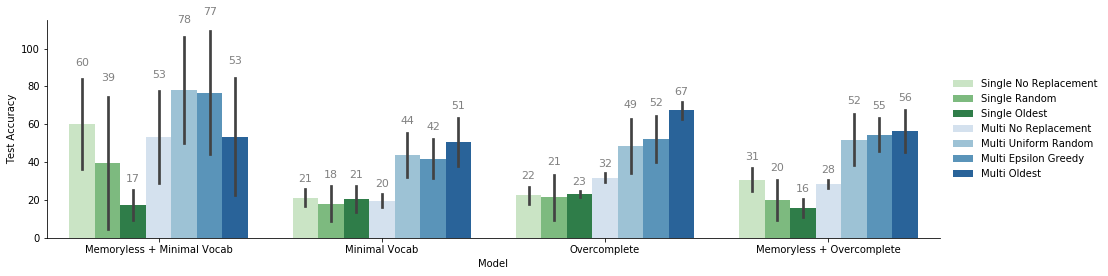

In [49]:
key = 'val_OO_both'

#def show_latex(gb=['method'],
#               fields=['train_OO_both', 'val_OO_both', 'test_OO_both', 'test_OO_one']):
df = pd.DataFrame.from_records(records, columns=columns)
gf = df.groupby(['method'], as_index=True).agg(['mean', 'std'])[[key]]

#gf = df.groupby(['method', 'model']).agg('std')[['test_OO_both']].reset_index()

gf

plt.figure(figsize=(16,4)) #, dpi=600)
models = list(df.model.unique())
methods = list(df.method.unique())

# 3 Single, 4 Multi
pal = sns.color_palette('Greens', 3) + sns.color_palette('Blues', 4)
#sns.palplot(pal)

ax = sns.barplot(x='model', y=key, hue='method', data=df, ci='sd',
                 palette=pal, hue_order=methods, order=models,
                 estimator=np.mean)
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
#plt.legend(loc='upper right')

# hatches = ['/', '//', '+', '-', 'x', '\\', '*', 'o', 'O', '.']
# for i, bar in enumerate(ax.patches):
#     strat_i = i // 4 # just believe me
#     if strat_i < 3:
#         bar.set_hatch('-')
#     else:
#         bar.set_hatch('x')
#     #if strat_i in [0, 3]:
#     #    bar.set_facecolor((1, 1, 1, 0))

for i, p in enumerate(ax.patches):
    method_i = i // len(models)
    model_i = i % len(models)
    _df = df[df.method == methods[method_i]]
    _df = _df[_df.model == models[model_i]]
    std = _df[key].std()
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height() + std),
     ha='center', va='bottom', fontsize=11, color='gray', rotation=0, xytext=(0, 4),
     textcoords='offset points')

ax.legend(loc=(1.01,0.25), ncol=1, fancybox=False, shadow=False, frameon=False)
sns.despine()
plt.savefig('data/figures/emnlp_fixed_epoch_nocv_results.png', bbox_inches='tight', dpi=600)

In [77]:
# exp7 - comp dataset - main experiments
exp_name = lambda mi, ti, di, fi, si, **k: 'exp7.{}.{}.{}.{}.{}'.format(mi, ti, di, fi, si)
models = [(0, 'Memoryless + Minimal Vocab'),
          ('2', 'Minimal Vocab'), #  (old: Va=4,Vq=3)
          (1, 'Overcomplete'),
          ('3', 'Memoryless + Overcomplete'),
          #('4', 'Small Vocab (Va=12, Vq=3)'),
         ]
training = [(0, 'Single No Replacement'),
            #(7, 'Single Replace All'),
            #(8, 'Multi All (shorter)'), # shorter
            (5, 'Single Random'),
            (6, 'Single Oldest'),
            (1, 'Multi No Replacement'), # shorter
            #(9, 'Multi Replace All'), # longer
            #(2, 'Multi Uniform Random (shorter)'), # shorter
            #(3, 'Multi Epsilon Greedy (shorter)'), # shorter
            #(4, 'Multi Oldest (shorter)'), # shorter
            (11, 'Multi Uniform Random'), # longer
            (12, 'Multi Epsilon Greedy'), # longer
            (10, 'Multi Oldest'), # longer
            #(13, 'Multi Oldest (n=10)'),
           ]
datasets = [(0, 'comp_cv')]
teaching = [(1, 'task-1 teach-1')]
folds = [(0, 0), (1, 1), (2, 2), (3, 3)]
seeds = [(0, 0), (1, 1), (2, 2), (3, 3)]

add_fresh_experiment(fixed_epoch=True)
#add_fresh_experiment()
show_records(['dataset', 'model', 'method', 'nqbots'])
#show_latex(['model', 'method'], fields=['test_OO_both'])

fresh
fixed epoch, using results_ep_39000.json
added exp7.0.0.0.0.0 ()
fixed epoch, using results_ep_39000.json
added exp7.0.0.0.0.1 ()
fixed epoch, using results_ep_39000.json
added exp7.0.0.0.0.2 ()
fixed epoch, using results_ep_39000.json
added exp7.0.0.0.0.3 ()
fixed epoch, using results_ep_39000.json
added exp7.0.0.0.1.0 ()
fixed epoch, using results_ep_39000.json
added exp7.0.0.0.1.1 ()
fixed epoch, using results_ep_39000.json
added exp7.0.0.0.1.2 ()
fixed epoch, using results_ep_39000.json
added exp7.0.0.0.1.3 ()
fixed epoch, using results_ep_39000.json
added exp7.0.0.0.2.0 ()
fixed epoch, using results_ep_39000.json
added exp7.0.0.0.2.1 ()
fixed epoch, using results_ep_39000.json
added exp7.0.0.0.2.2 ()
fixed epoch, using results_ep_39000.json
added exp7.0.0.0.2.3 ()
fixed epoch, using results_ep_39000.json
added exp7.0.0.0.3.0 ()
fixed epoch, using results_ep_39000.json
added exp7.0.0.0.3.1 ()
fixed epoch, using results_ep_39000.json
added exp7.0.0.0.3.2 ()
fixed epoch, using 

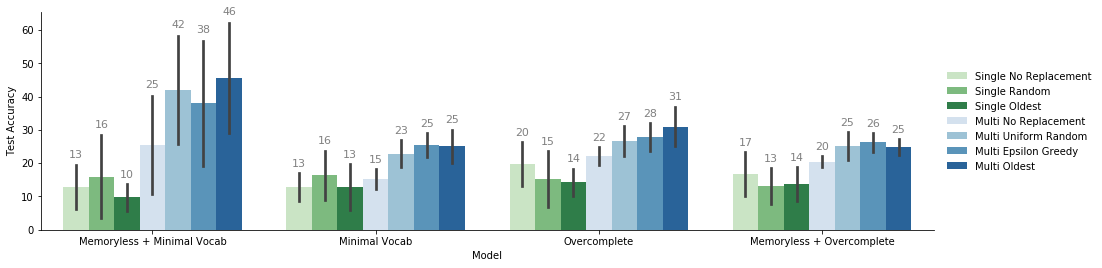

In [51]:
key = 'test_OO_both'

#def show_latex(gb=['method'],
#               fields=['train_OO_both', 'val_OO_both', 'test_OO_both', 'test_OO_one']):
df = pd.DataFrame.from_records(records, columns=columns)
gf = df.groupby(['method'], as_index=True).agg(['mean', 'std'])[[key]]

#gf = df.groupby(['method', 'model']).agg('std')[['test_OO_both']].reset_index()

gf

plt.figure(figsize=(16,4)) #, dpi=600)
models = list(df.model.unique())
methods = list(df.method.unique())

# 3 Single, 4 Multi
pal = sns.color_palette('Greens', 3) + sns.color_palette('Blues', 4)
#sns.palplot(pal)

ax = sns.barplot(x='model', y=key, hue='method', data=df, ci='sd',
           palette=pal, hue_order=methods, order=models)
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
#plt.legend(loc='upper right')

# hatches = ['/', '//', '+', '-', 'x', '\\', '*', 'o', 'O', '.']
# for i, bar in enumerate(ax.patches):
#     strat_i = i // 4 # just believe me
#     if strat_i < 3:
#         bar.set_hatch('-')
#     else:
#         bar.set_hatch('x')
#     #if strat_i in [0, 3]:
#     #    bar.set_facecolor((1, 1, 1, 0))

for i, p in enumerate(ax.patches):
    method_i = i // len(models)
    model_i = i % len(models)
    _df = df[df.method == methods[method_i]]
    _df = _df[_df.model == models[model_i]]
    std = _df[key].std()
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height() + std),
     ha='center', va='bottom', fontsize=11, color='gray', rotation=0, xytext=(0, 4),
     textcoords='offset points')

ax.legend(loc=(1.01,0.25), ncol=1, fancybox=False, shadow=False, frameon=False)
sns.despine()
plt.savefig('data/figures/main_results.png', bbox_inches='tight', dpi=600)

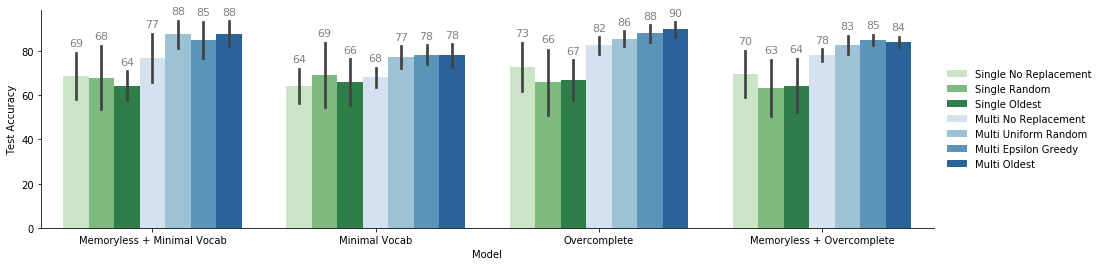

In [52]:
key = 'test_OO_one'

#def show_latex(gb=['method'],
#               fields=['train_OO_both', 'val_OO_both', 'test_OO_both', 'test_OO_one']):
df = pd.DataFrame.from_records(records, columns=columns)
gf = df.groupby(['method'], as_index=True).agg(['mean', 'std'])[[key]]

#gf = df.groupby(['method', 'model']).agg('std')[['test_OO_both']].reset_index()

gf

plt.figure(figsize=(16,4)) #, dpi=600)
models = list(df.model.unique())
methods = list(df.method.unique())

# 3 Single, 4 Multi
pal = sns.color_palette('Greens', 3) + sns.color_palette('Blues', 4)
#sns.palplot(pal)

ax = sns.barplot(x='model', y=key, hue='method', data=df, ci='sd',
           palette=pal, hue_order=methods, order=models)
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
#plt.legend(loc='upper right')

# hatches = ['/', '//', '+', '-', 'x', '\\', '*', 'o', 'O', '.']
# for i, bar in enumerate(ax.patches):
#     strat_i = i // 4 # just believe me
#     if strat_i < 3:
#         bar.set_hatch('-')
#     else:
#         bar.set_hatch('x')
#     #if strat_i in [0, 3]:
#     #    bar.set_facecolor((1, 1, 1, 0))

for i, p in enumerate(ax.patches):
    method_i = i // len(models)
    model_i = i % len(models)
    _df = df[df.method == methods[method_i]]
    _df = _df[_df.model == models[model_i]]
    std = _df[key].std()
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height() + std),
     ha='center', va='bottom', fontsize=11, color='gray', rotation=0, xytext=(0, 4),
     textcoords='offset points')

ax.legend(loc=(1.01,0.25), ncol=1, fancybox=False, shadow=False, frameon=False)
sns.despine()
plt.savefig('data/figures/main_results_one.png', bbox_inches='tight', dpi=600)

## Accuracy T-Tests <a class="anchor" id="acc-ttest"></a>

### Accuracy - By Model <a class="anchor" id="acc-ttest-model"></a>

#### Test

/nethome/mcogswell6/anaconda3/envs/emerge/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less


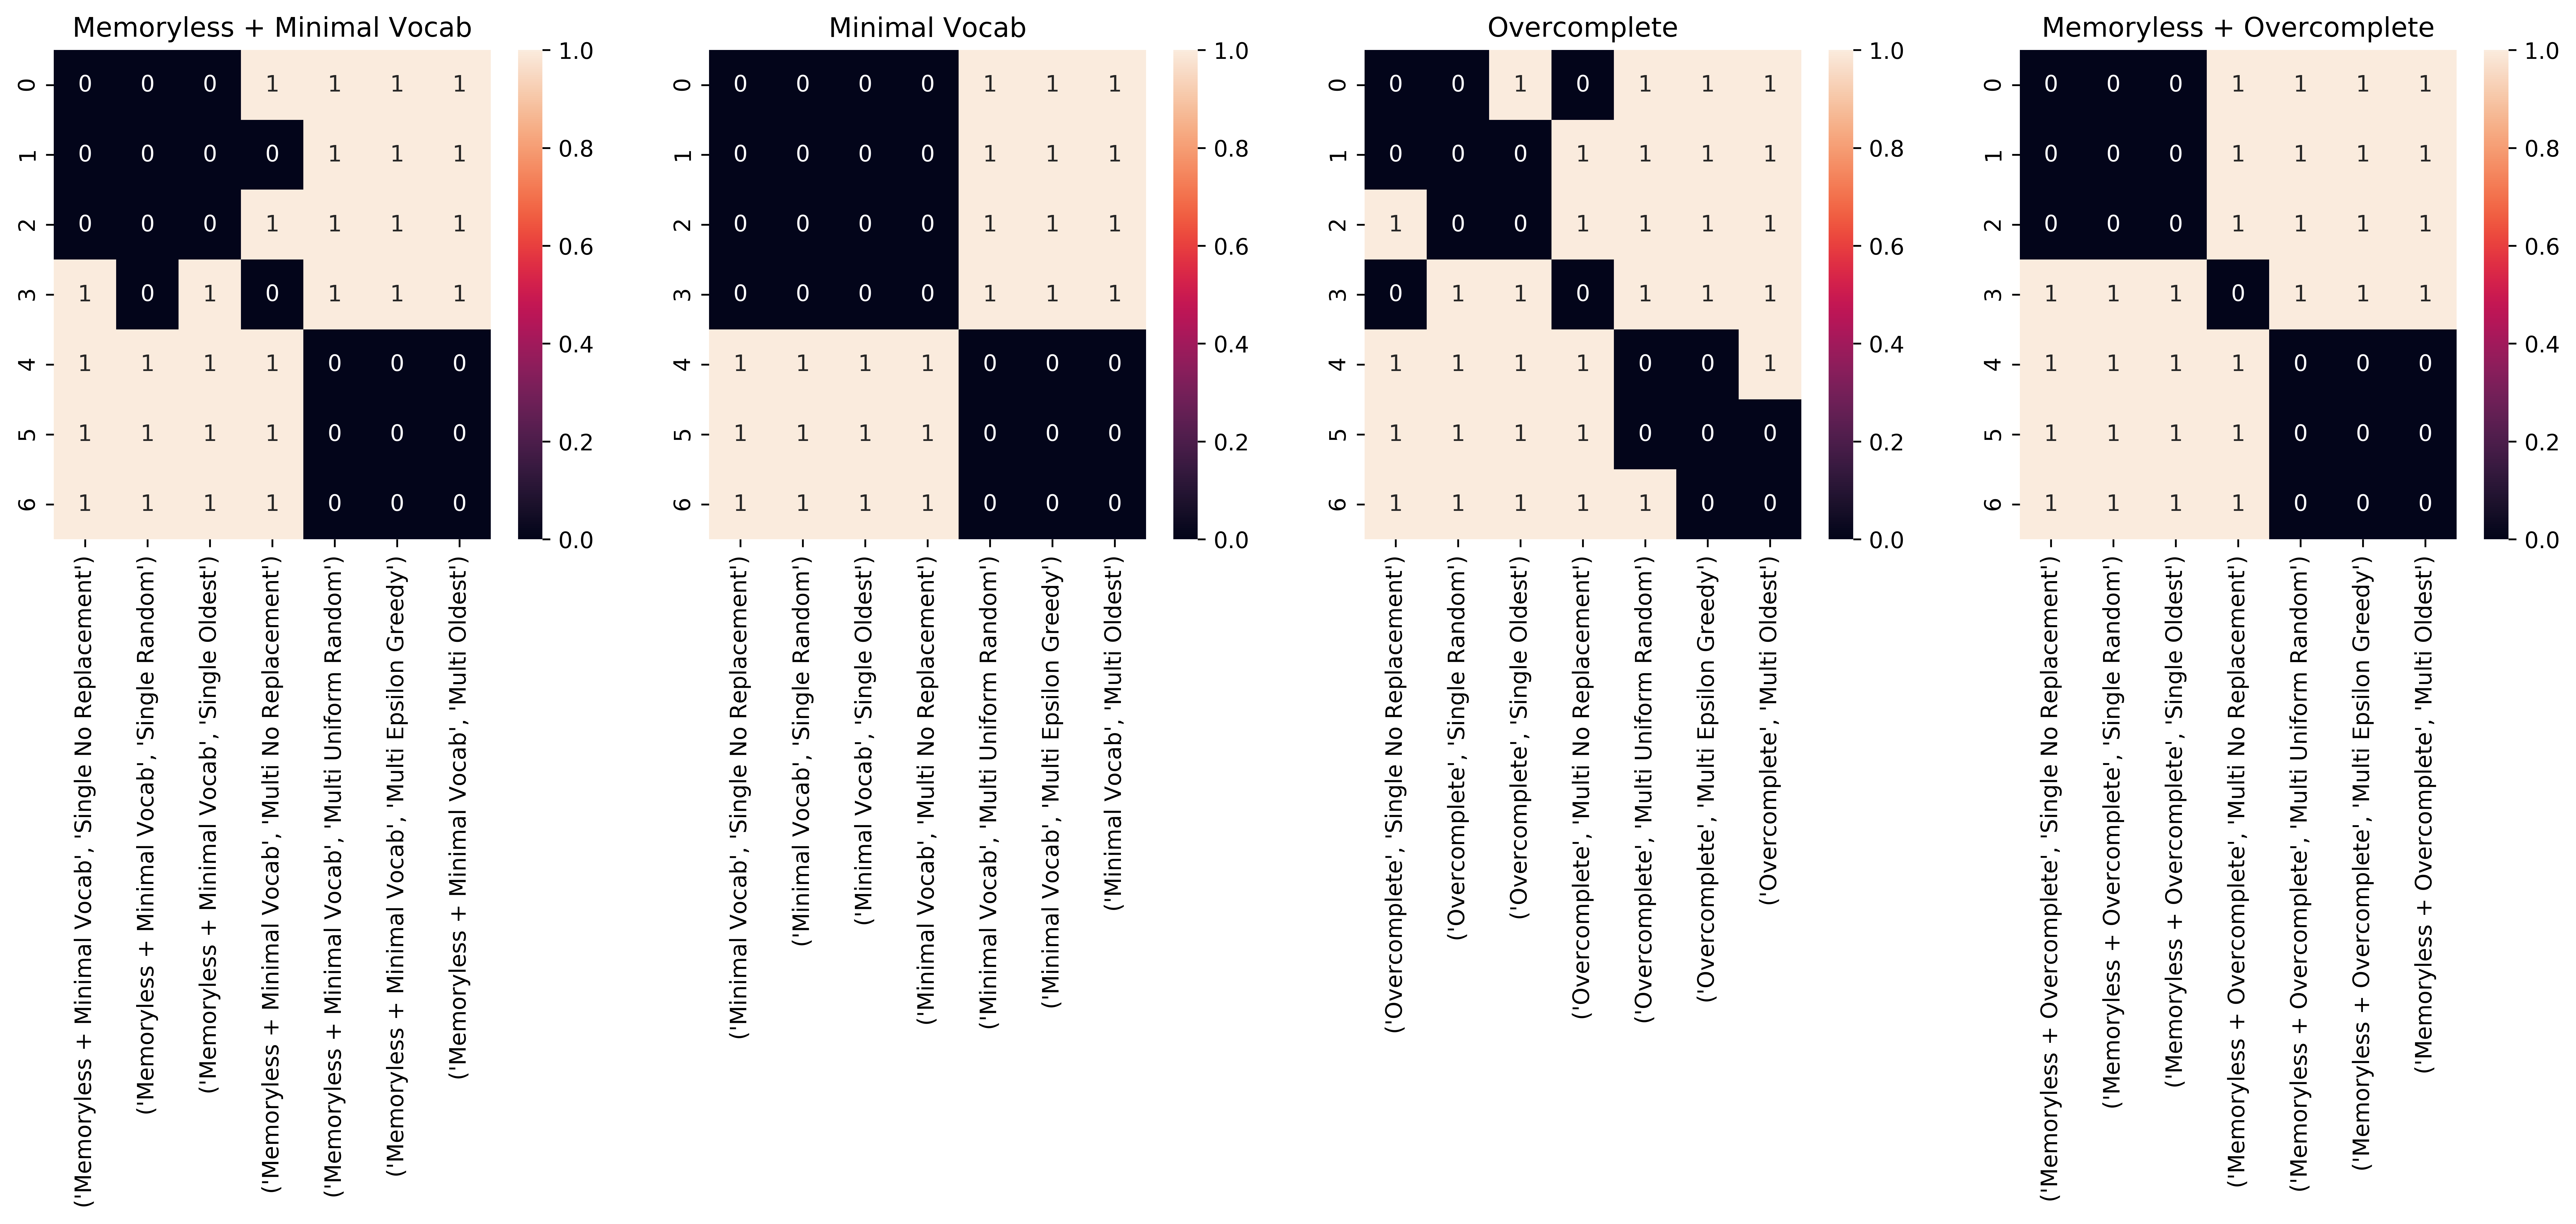

In [53]:
plt.figure(figsize=(20,4), dpi=600)
for i, model in enumerate(models):
    plt.subplot(1, len(models), i+1)
    plt.title(model)
    show_ttests('test_OO_both', df_filter=lambda df: df[df.model == model], pthresh=0.05)

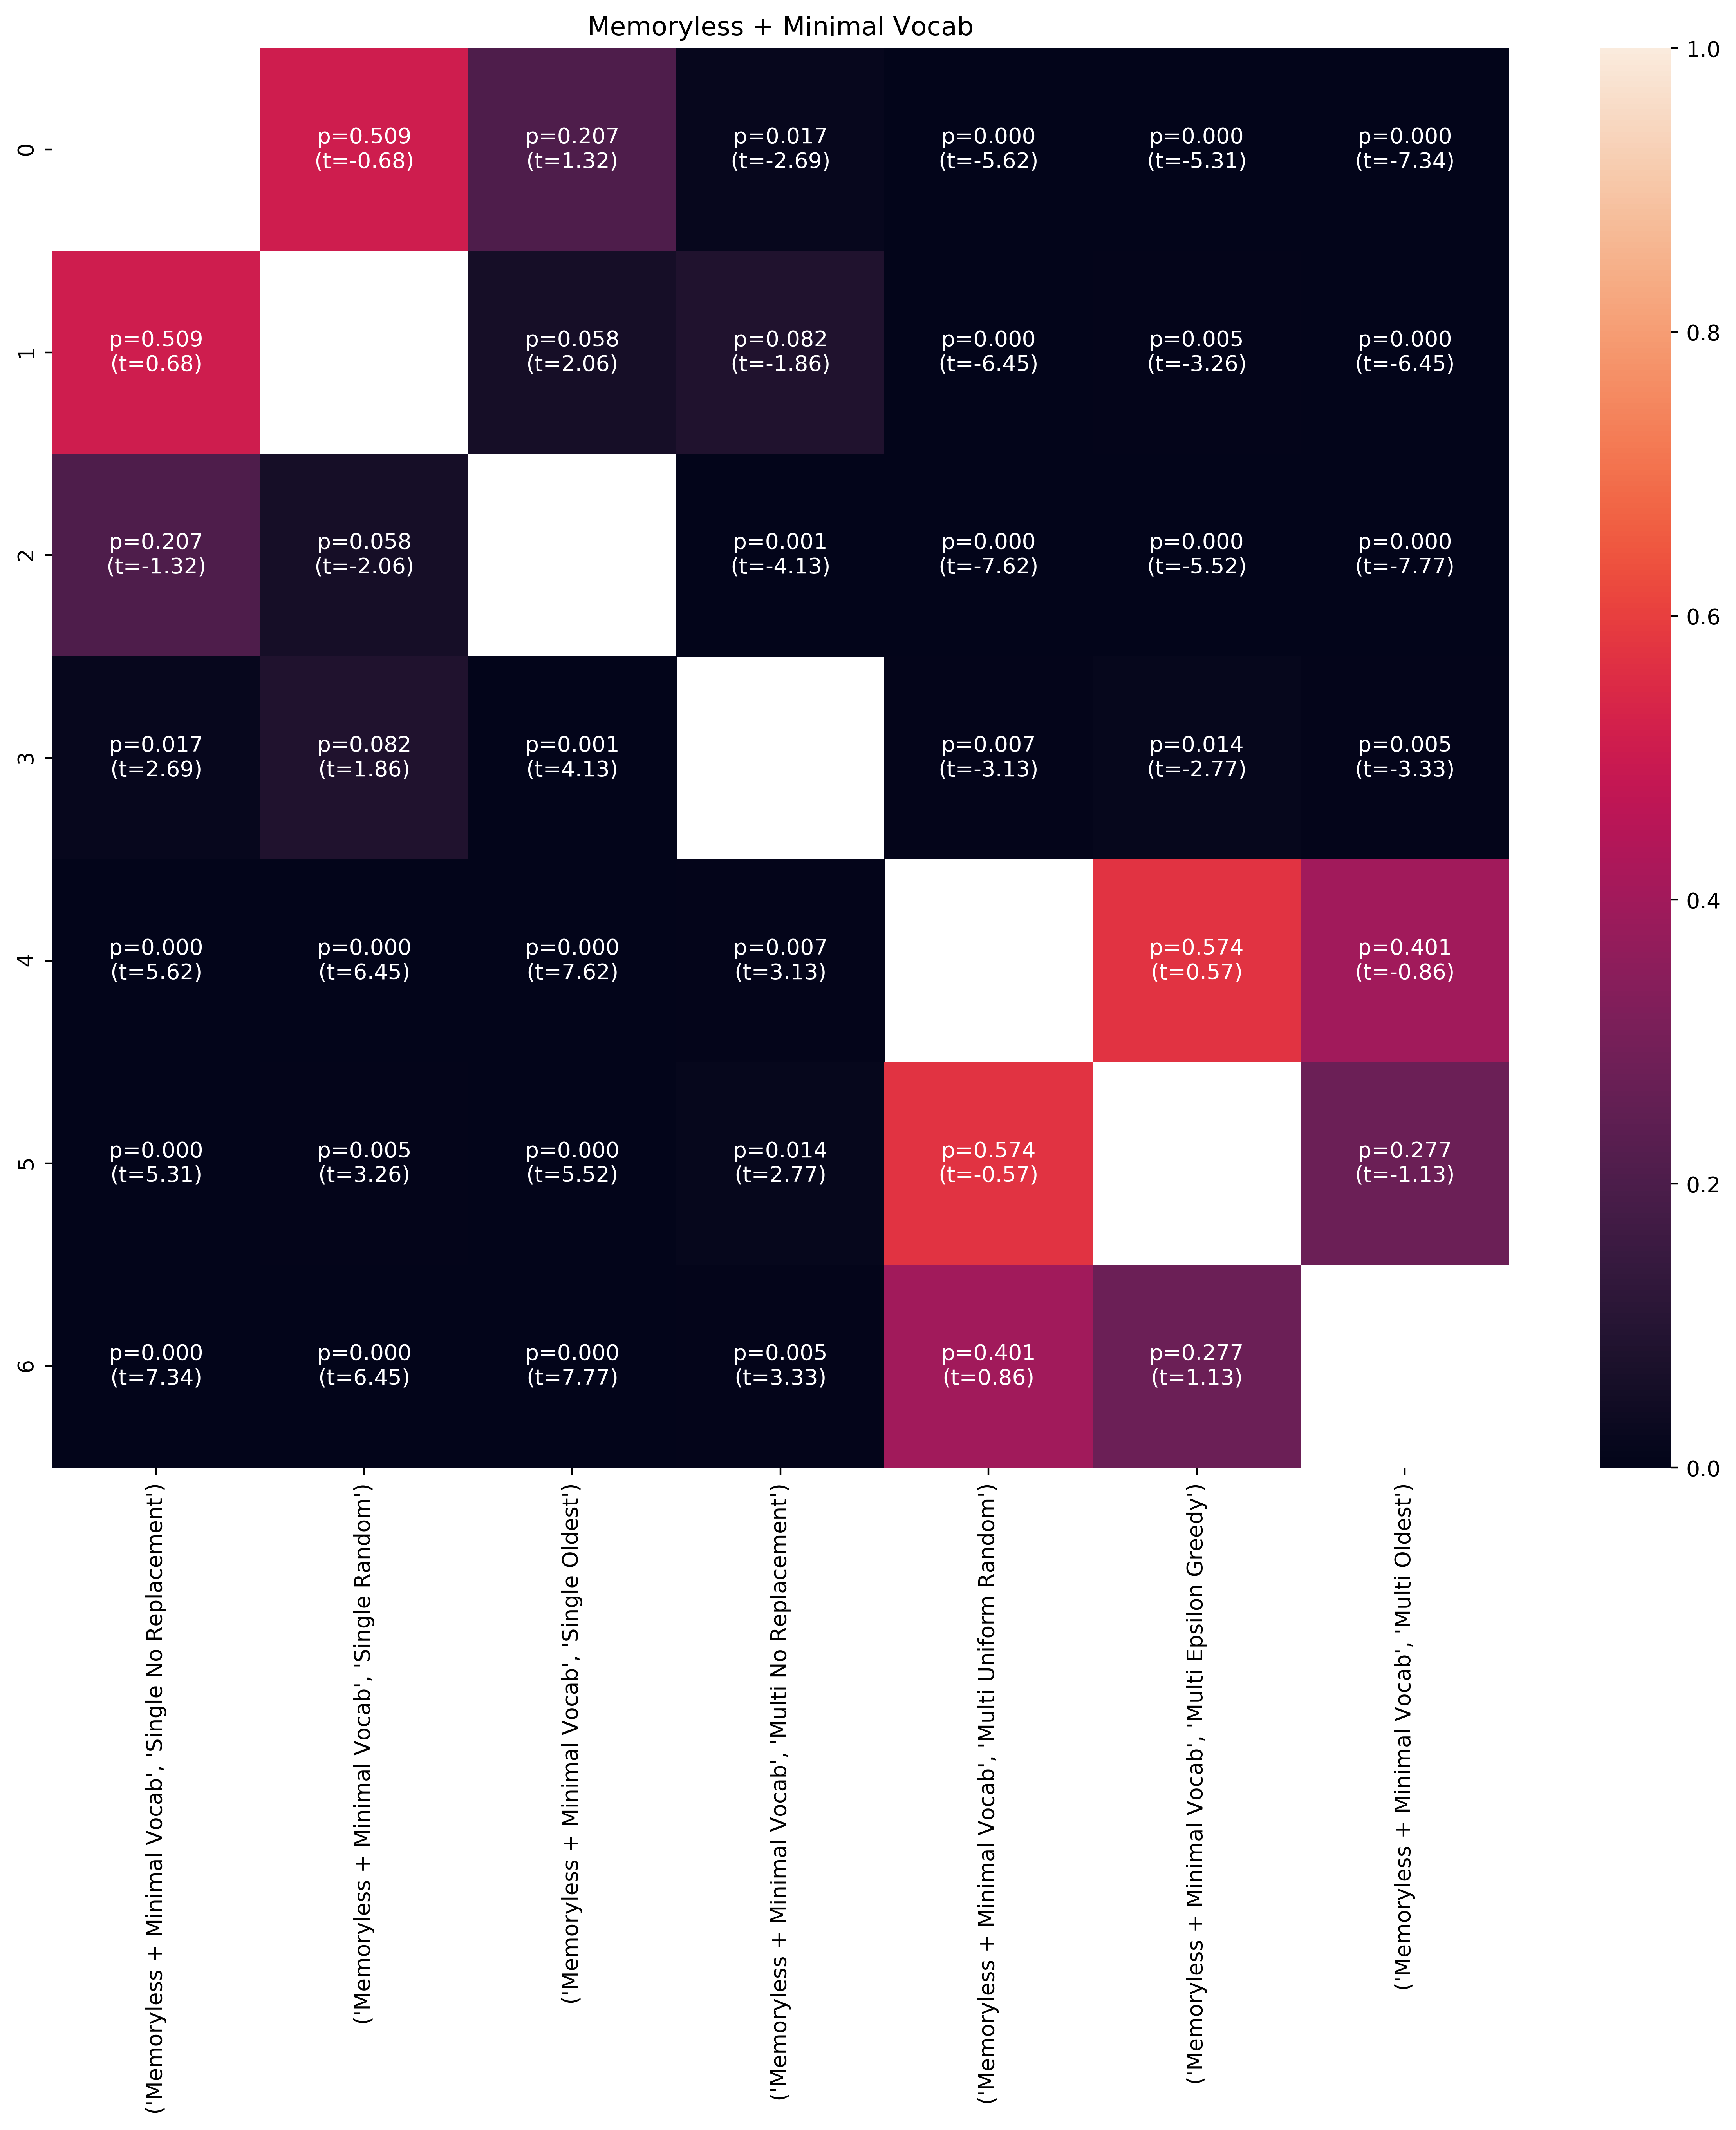

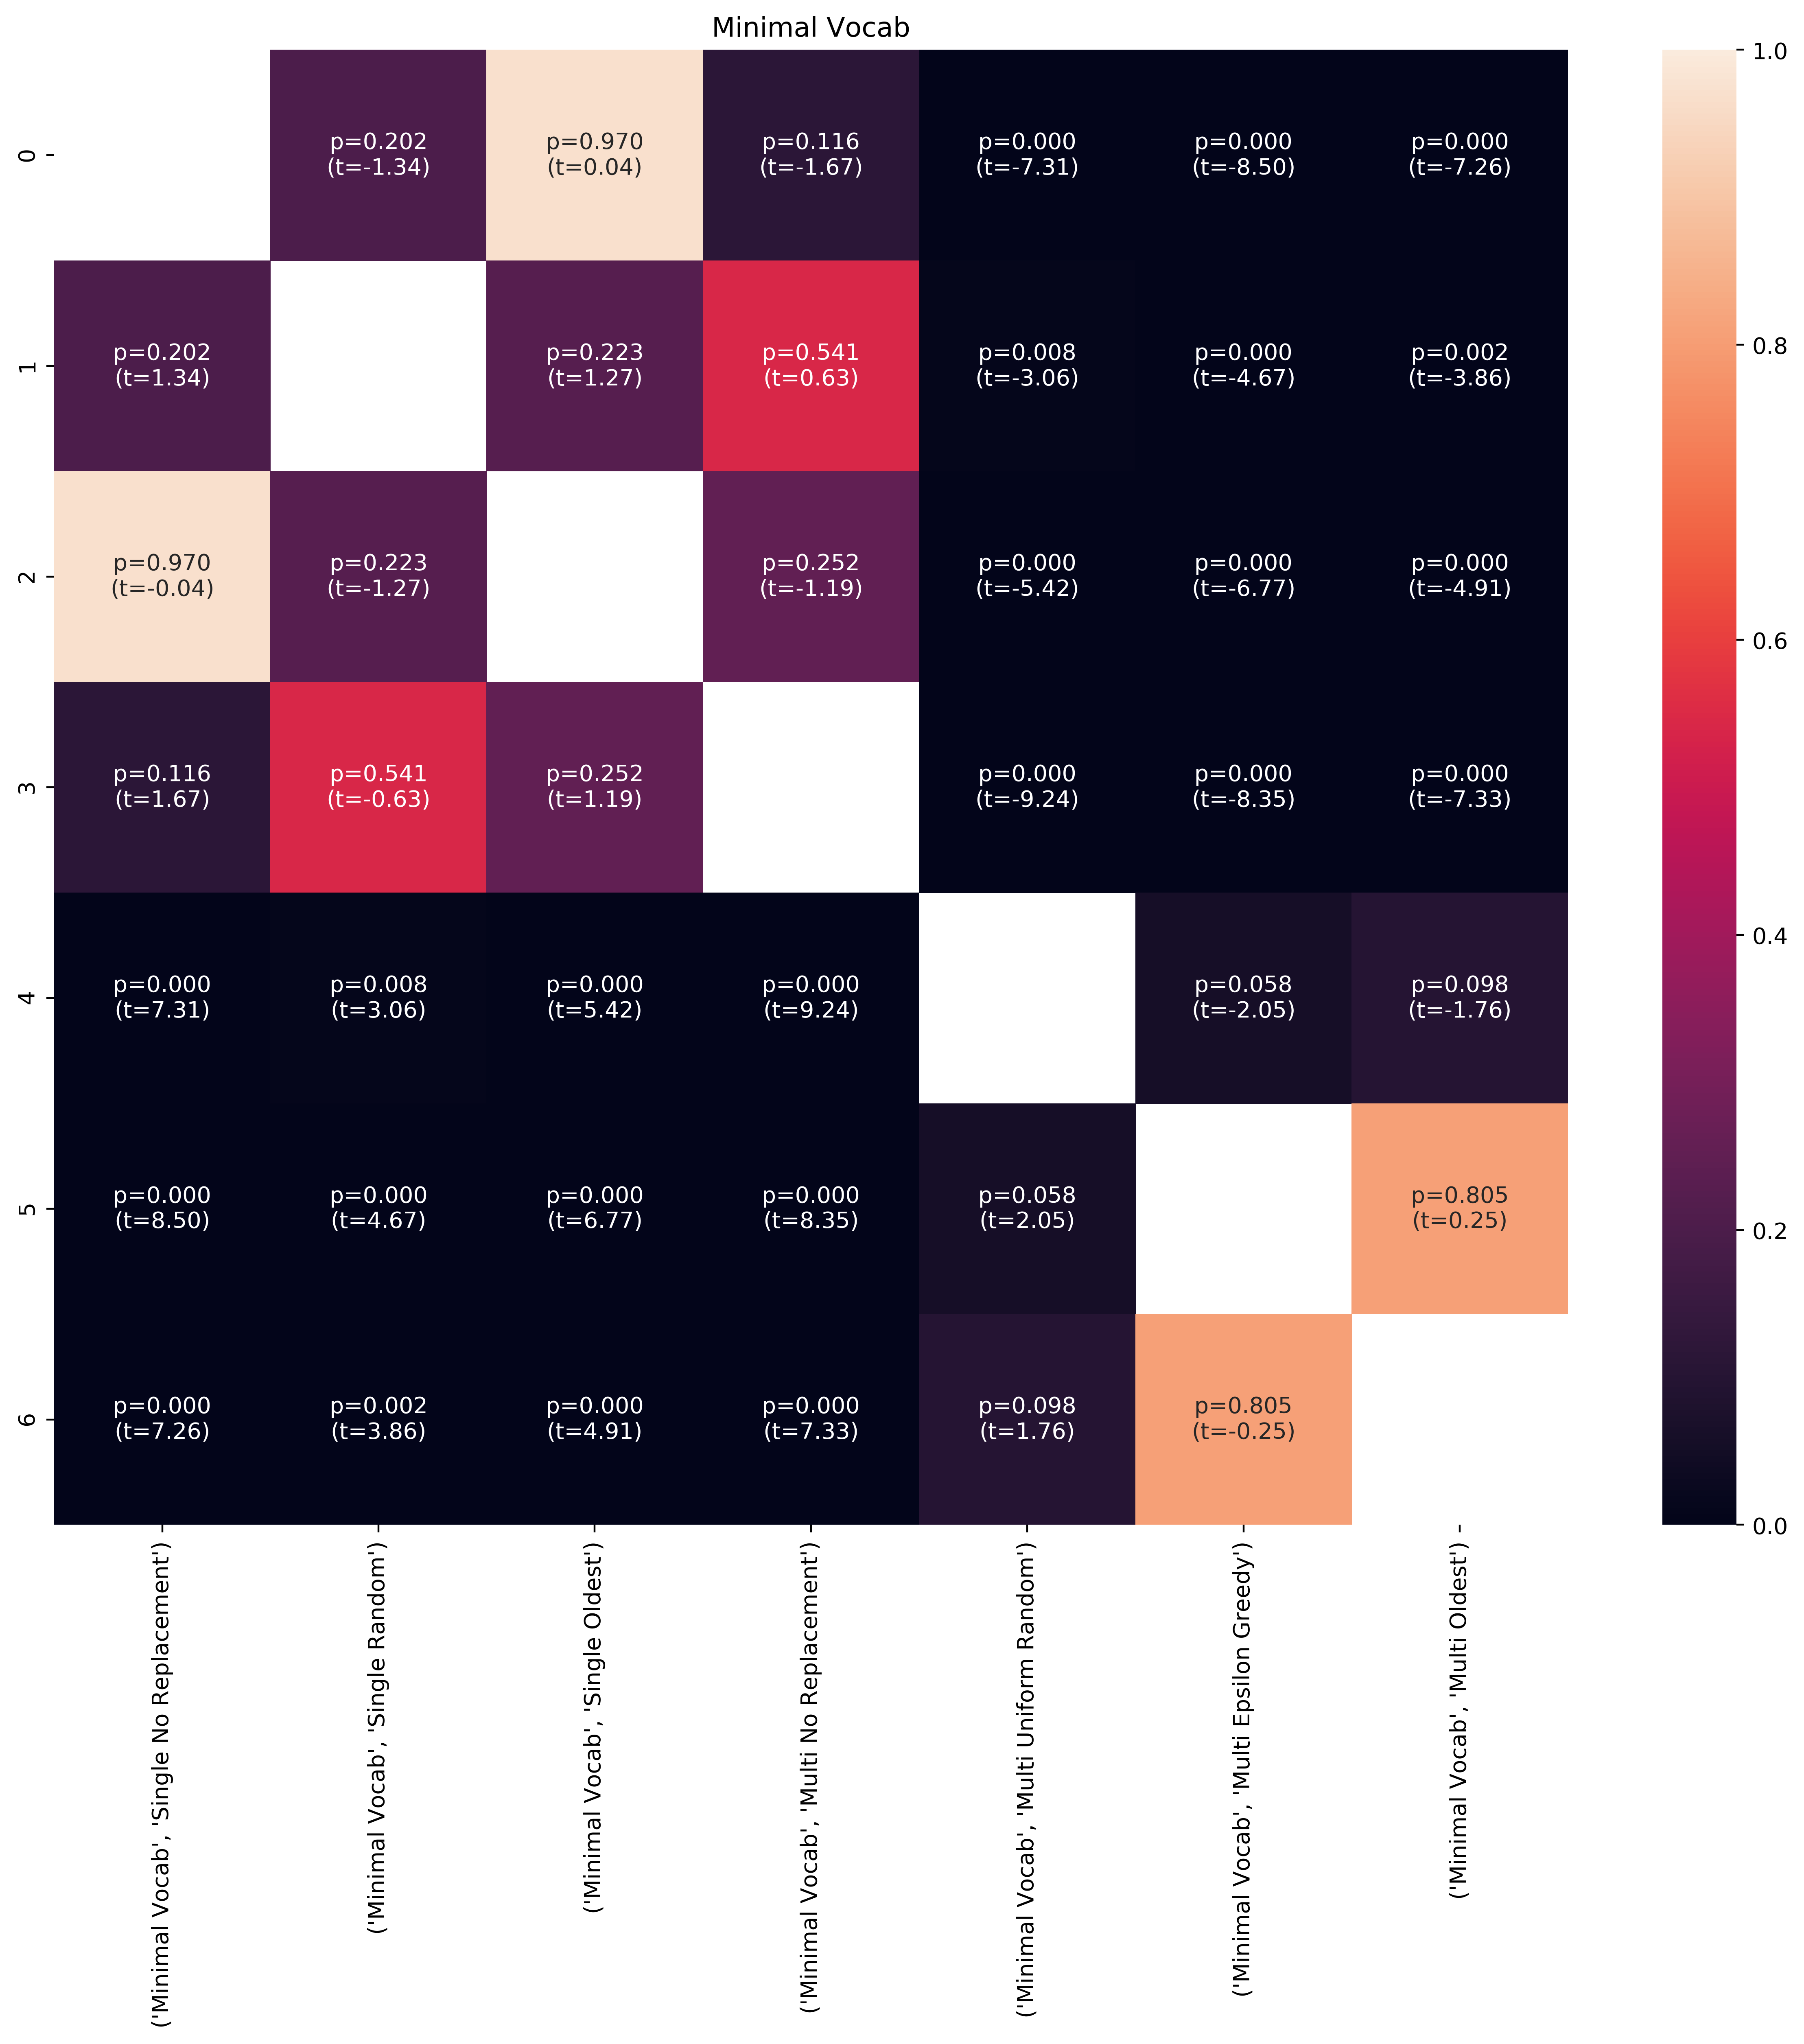

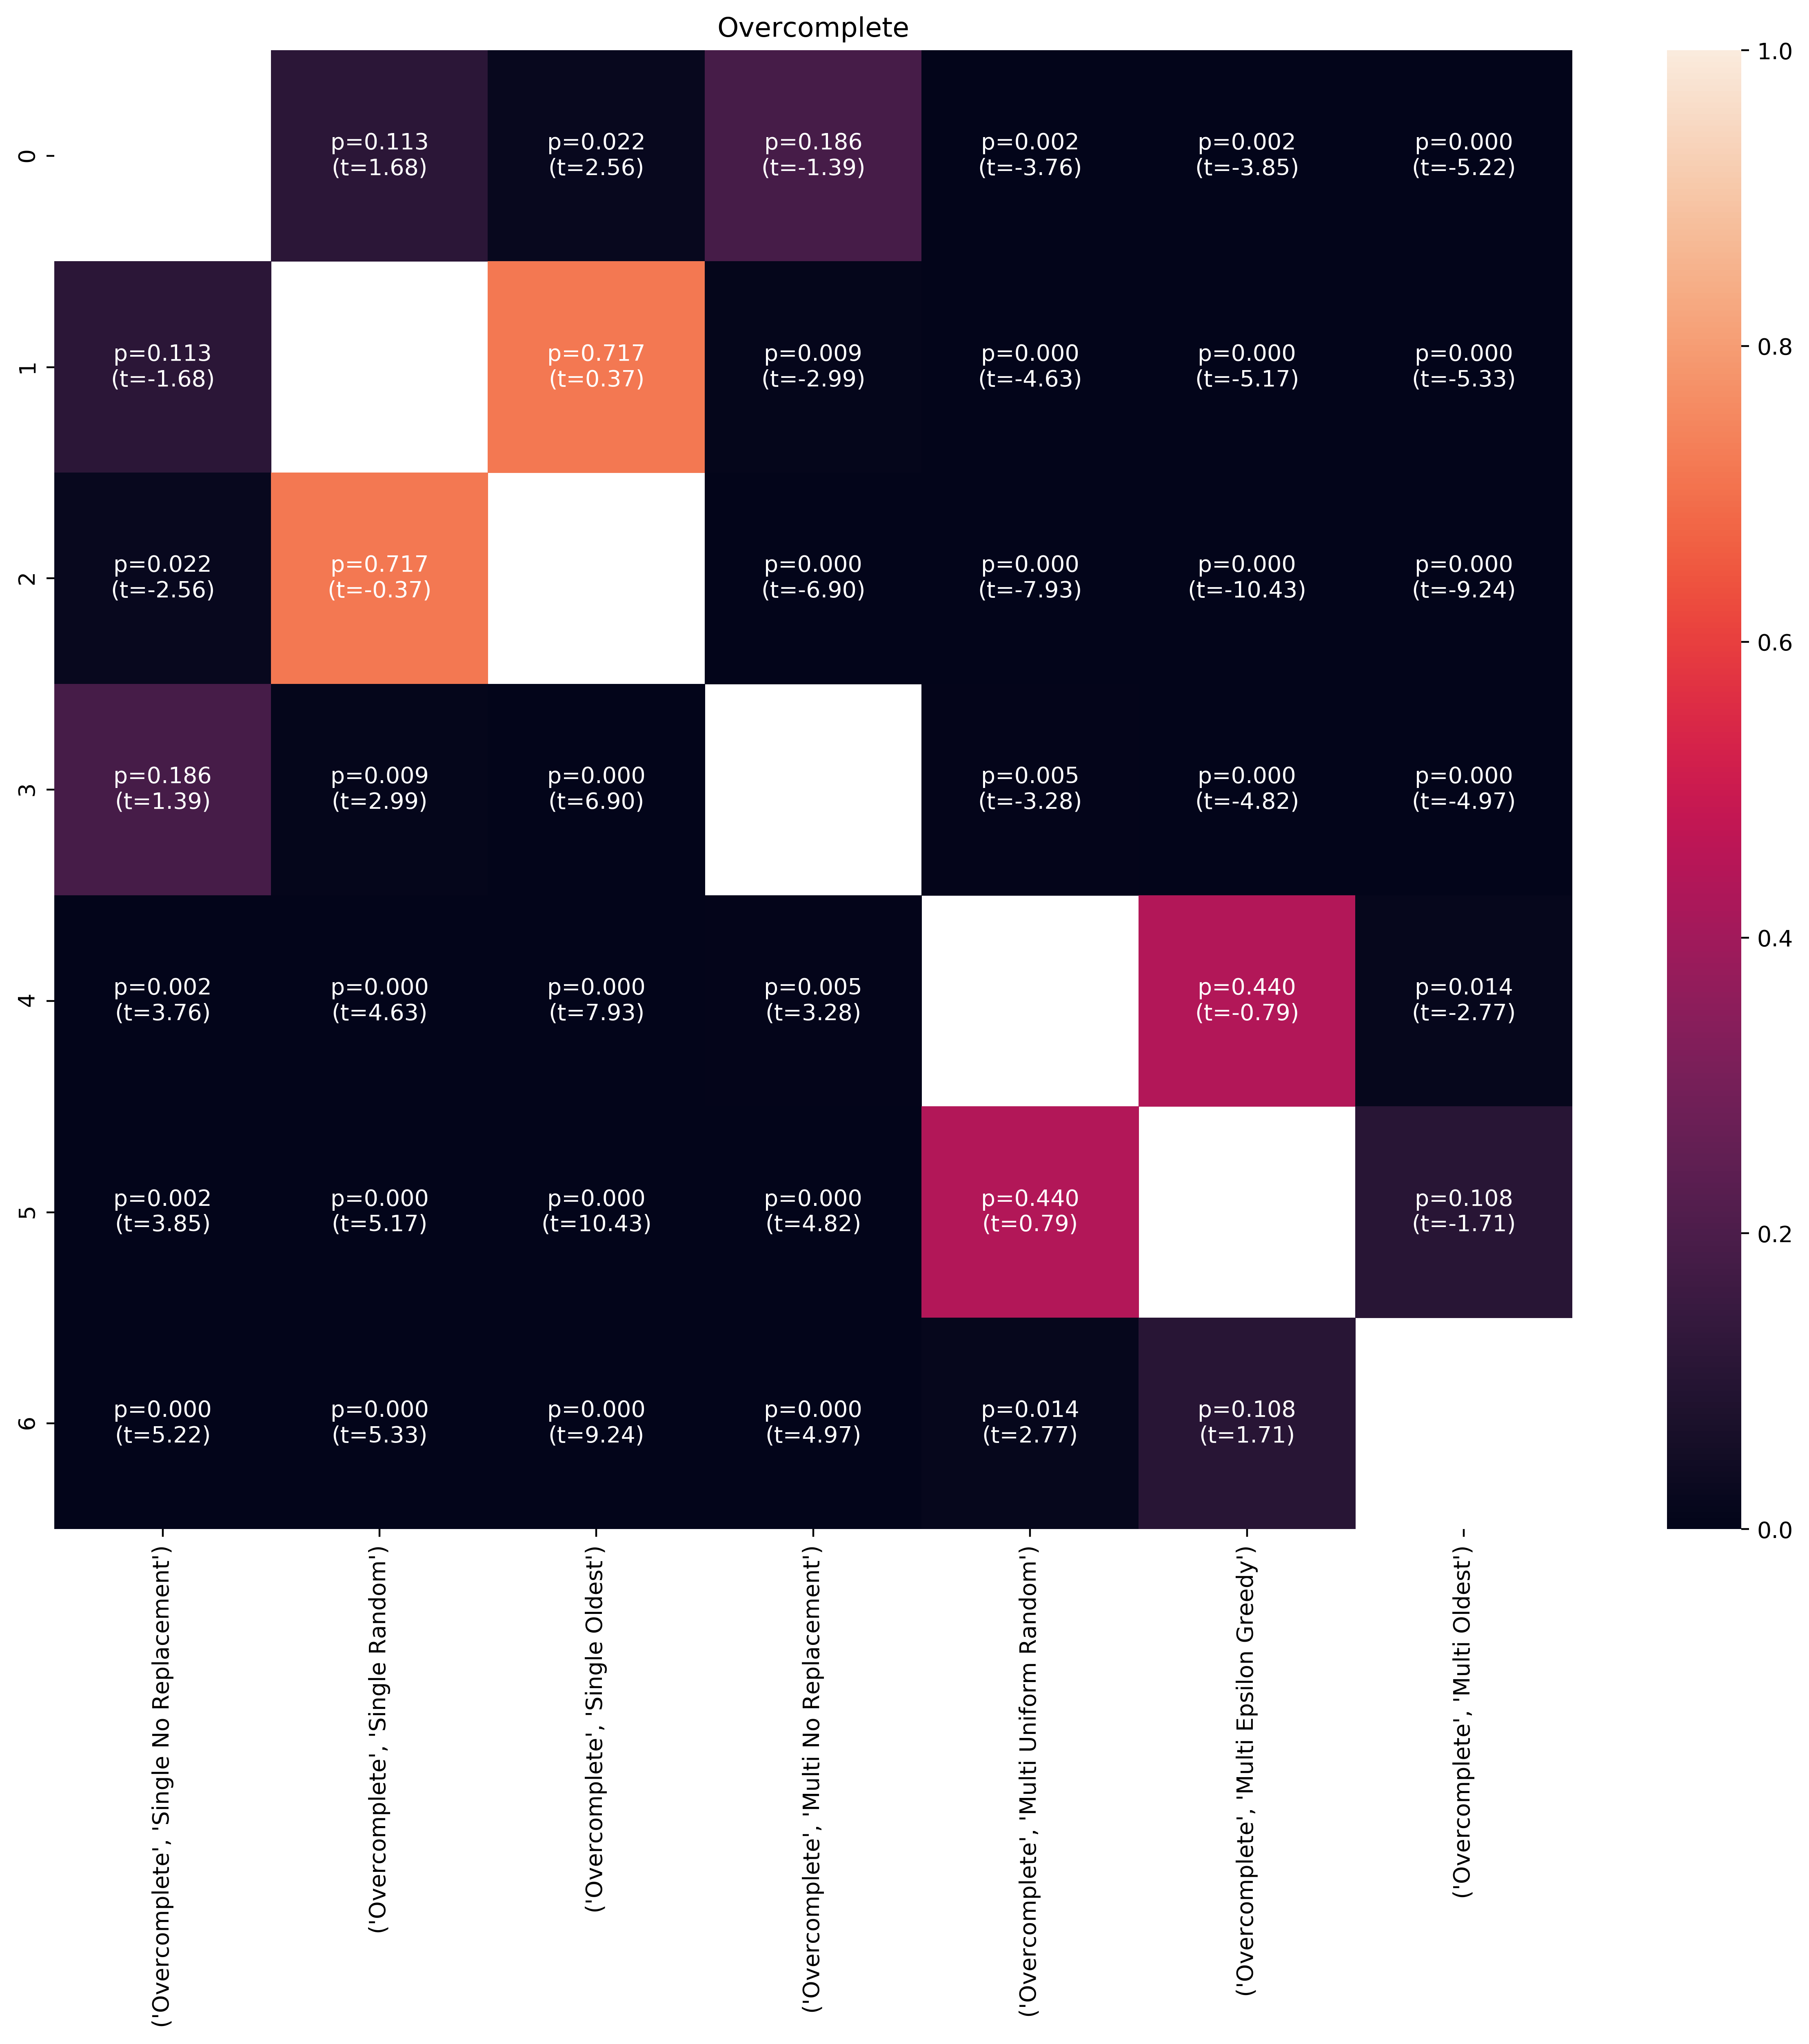

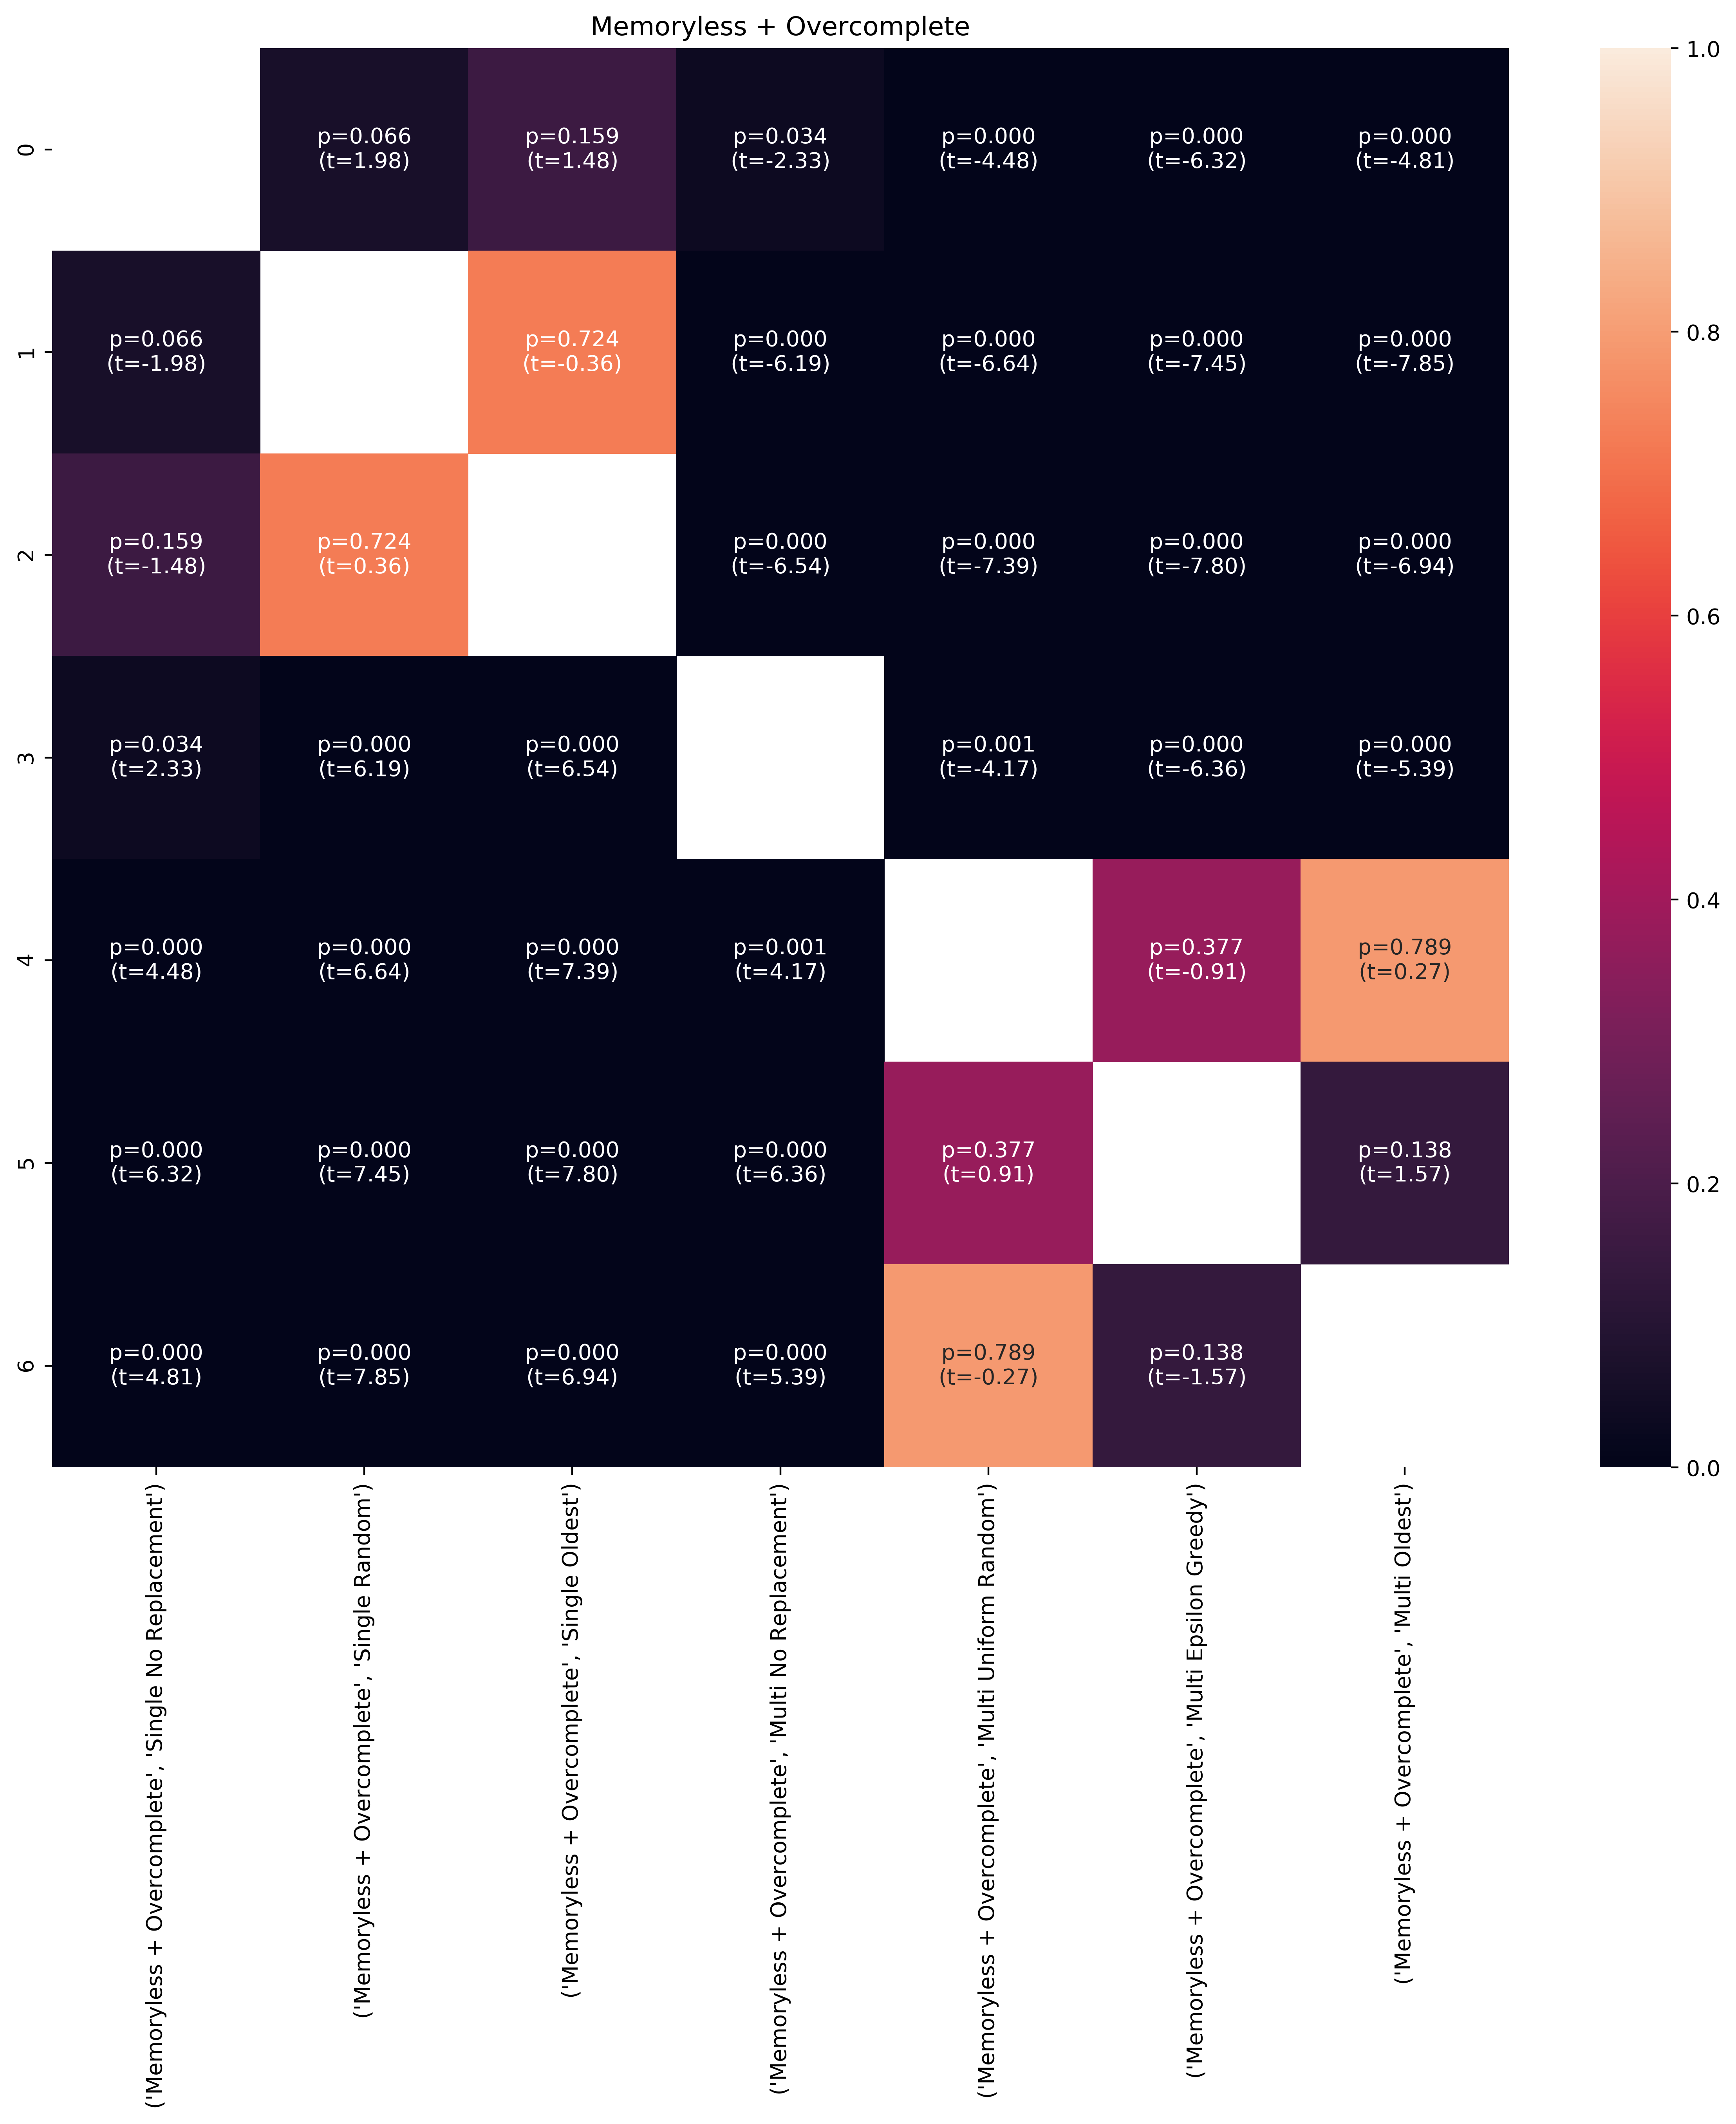

In [54]:
dname = 'data/figures/pvalues/by_model/'
os.makedirs(dname, exist_ok=True)
for i, model in enumerate(models):
    plt.figure(figsize=(15,12), dpi=400)
    plt.title(model)
    show_ttests('test_OO_both', df_filter=lambda df: df[df.model == model], threshold=False, show_t='both')
    plt.savefig(pth.join(dname, 'test_' + model + '.png'), bbox_inches='tight')

#### Train

/nethome/mcogswell6/anaconda3/envs/emerge/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less


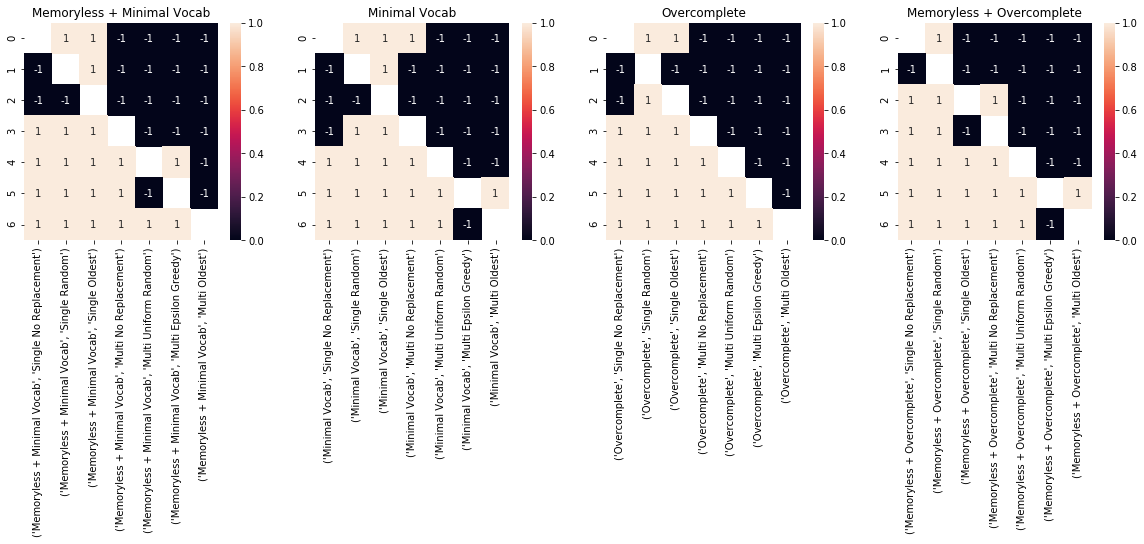

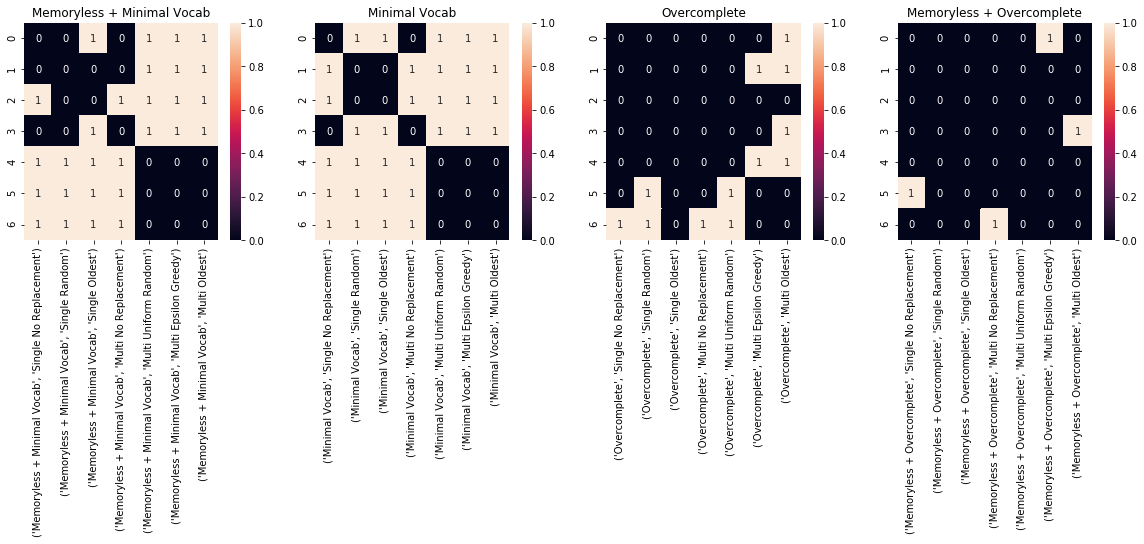

In [55]:
plt.figure(figsize=(20,4))
for i, model in enumerate(models):
    plt.subplot(1, len(models), i+1)
    plt.title(model)
    show_ttests('train_OO_both', df_filter=lambda df: df[df.model == model], pthresh=0.05, threshold=True, show_t=True)

plt.figure(figsize=(20,4))
for i, model in enumerate(models):
    plt.subplot(1, len(models), i+1)
    plt.title(model)
    show_ttests('train_OO_both', df_filter=lambda df: df[df.model == model], pthresh=0.05, threshold=True, show_t=False)


### Test Accuracy - By Replacement Method <a class="anchor" id="acc-ttest-method"></a>

/nethome/mcogswell6/anaconda3/envs/emerge/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less


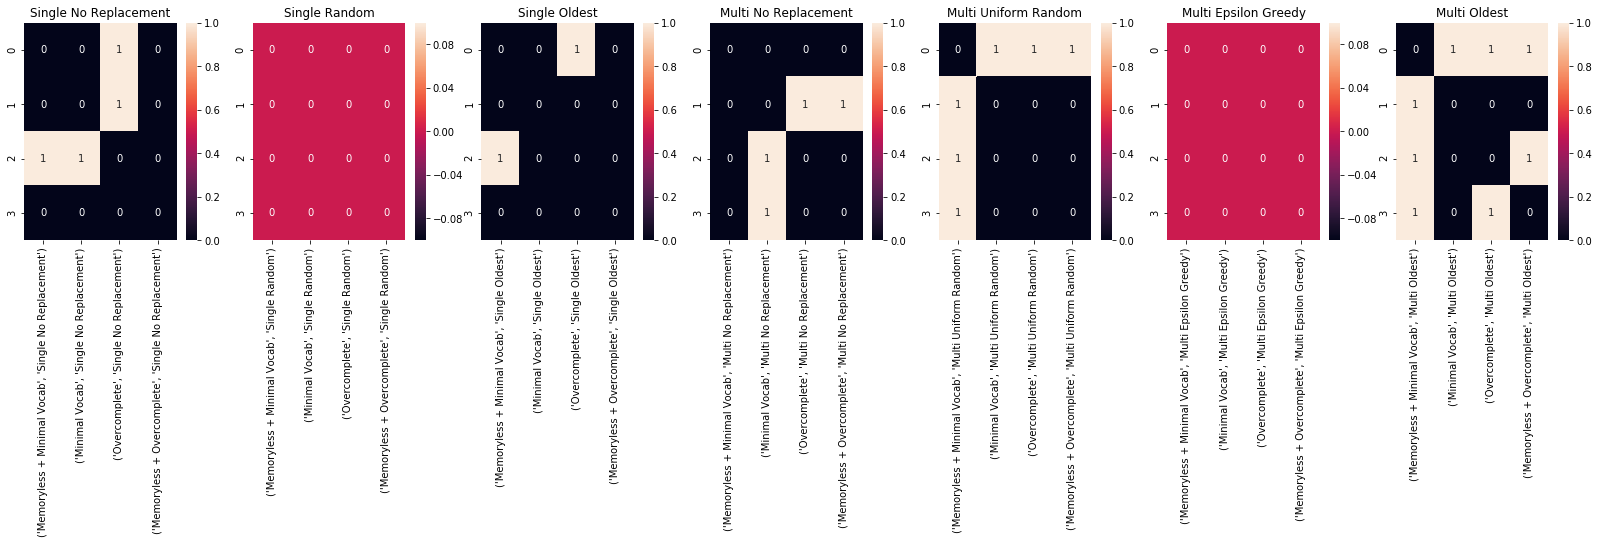

In [56]:
plt.figure(figsize=(28,4))
for i, method in enumerate(methods):
    plt.subplot(1, len(methods), i+1)
    plt.title(method)
    show_ttests('test_OO_both', df_filter=lambda df: df[df.method == method], pthresh=0.01)

/nethome/mcogswell6/anaconda3/envs/emerge/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less


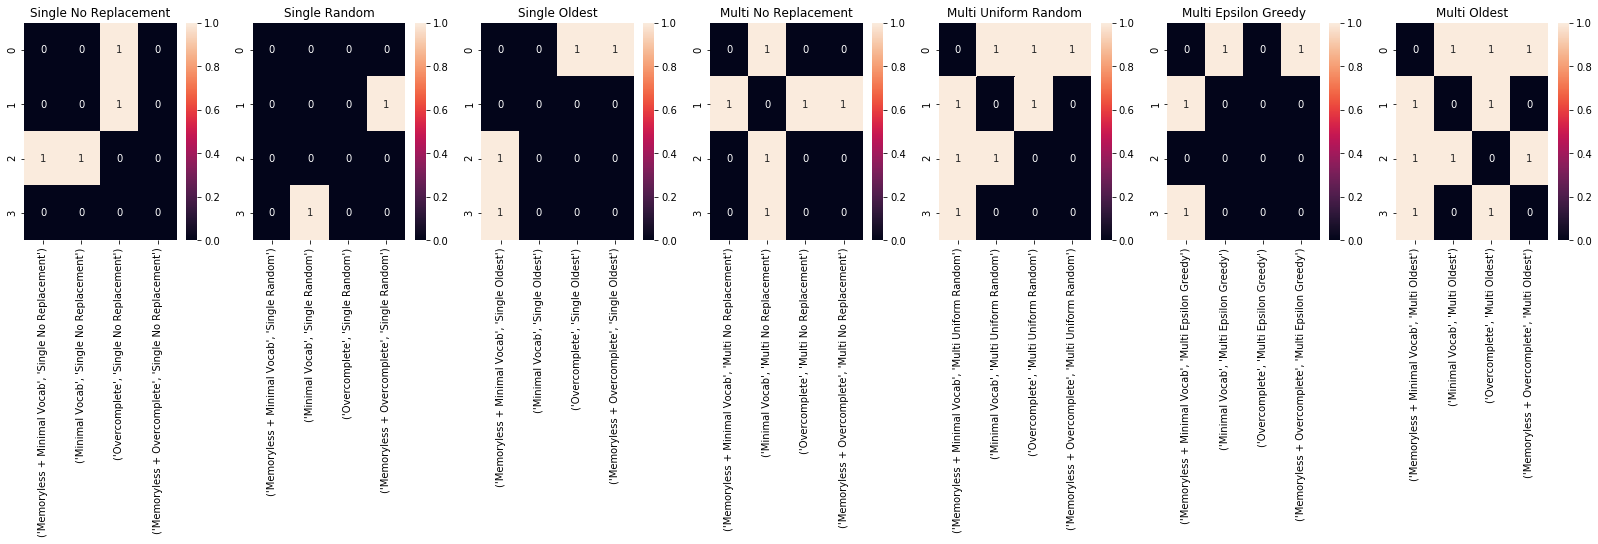

In [57]:
plt.figure(figsize=(28,4))
for i, method in enumerate(methods):
    plt.subplot(1, len(methods), i+1)
    plt.title(method)
    show_ttests('test_OO_both', df_filter=lambda df: df[df.method == method], pthresh=0.05)

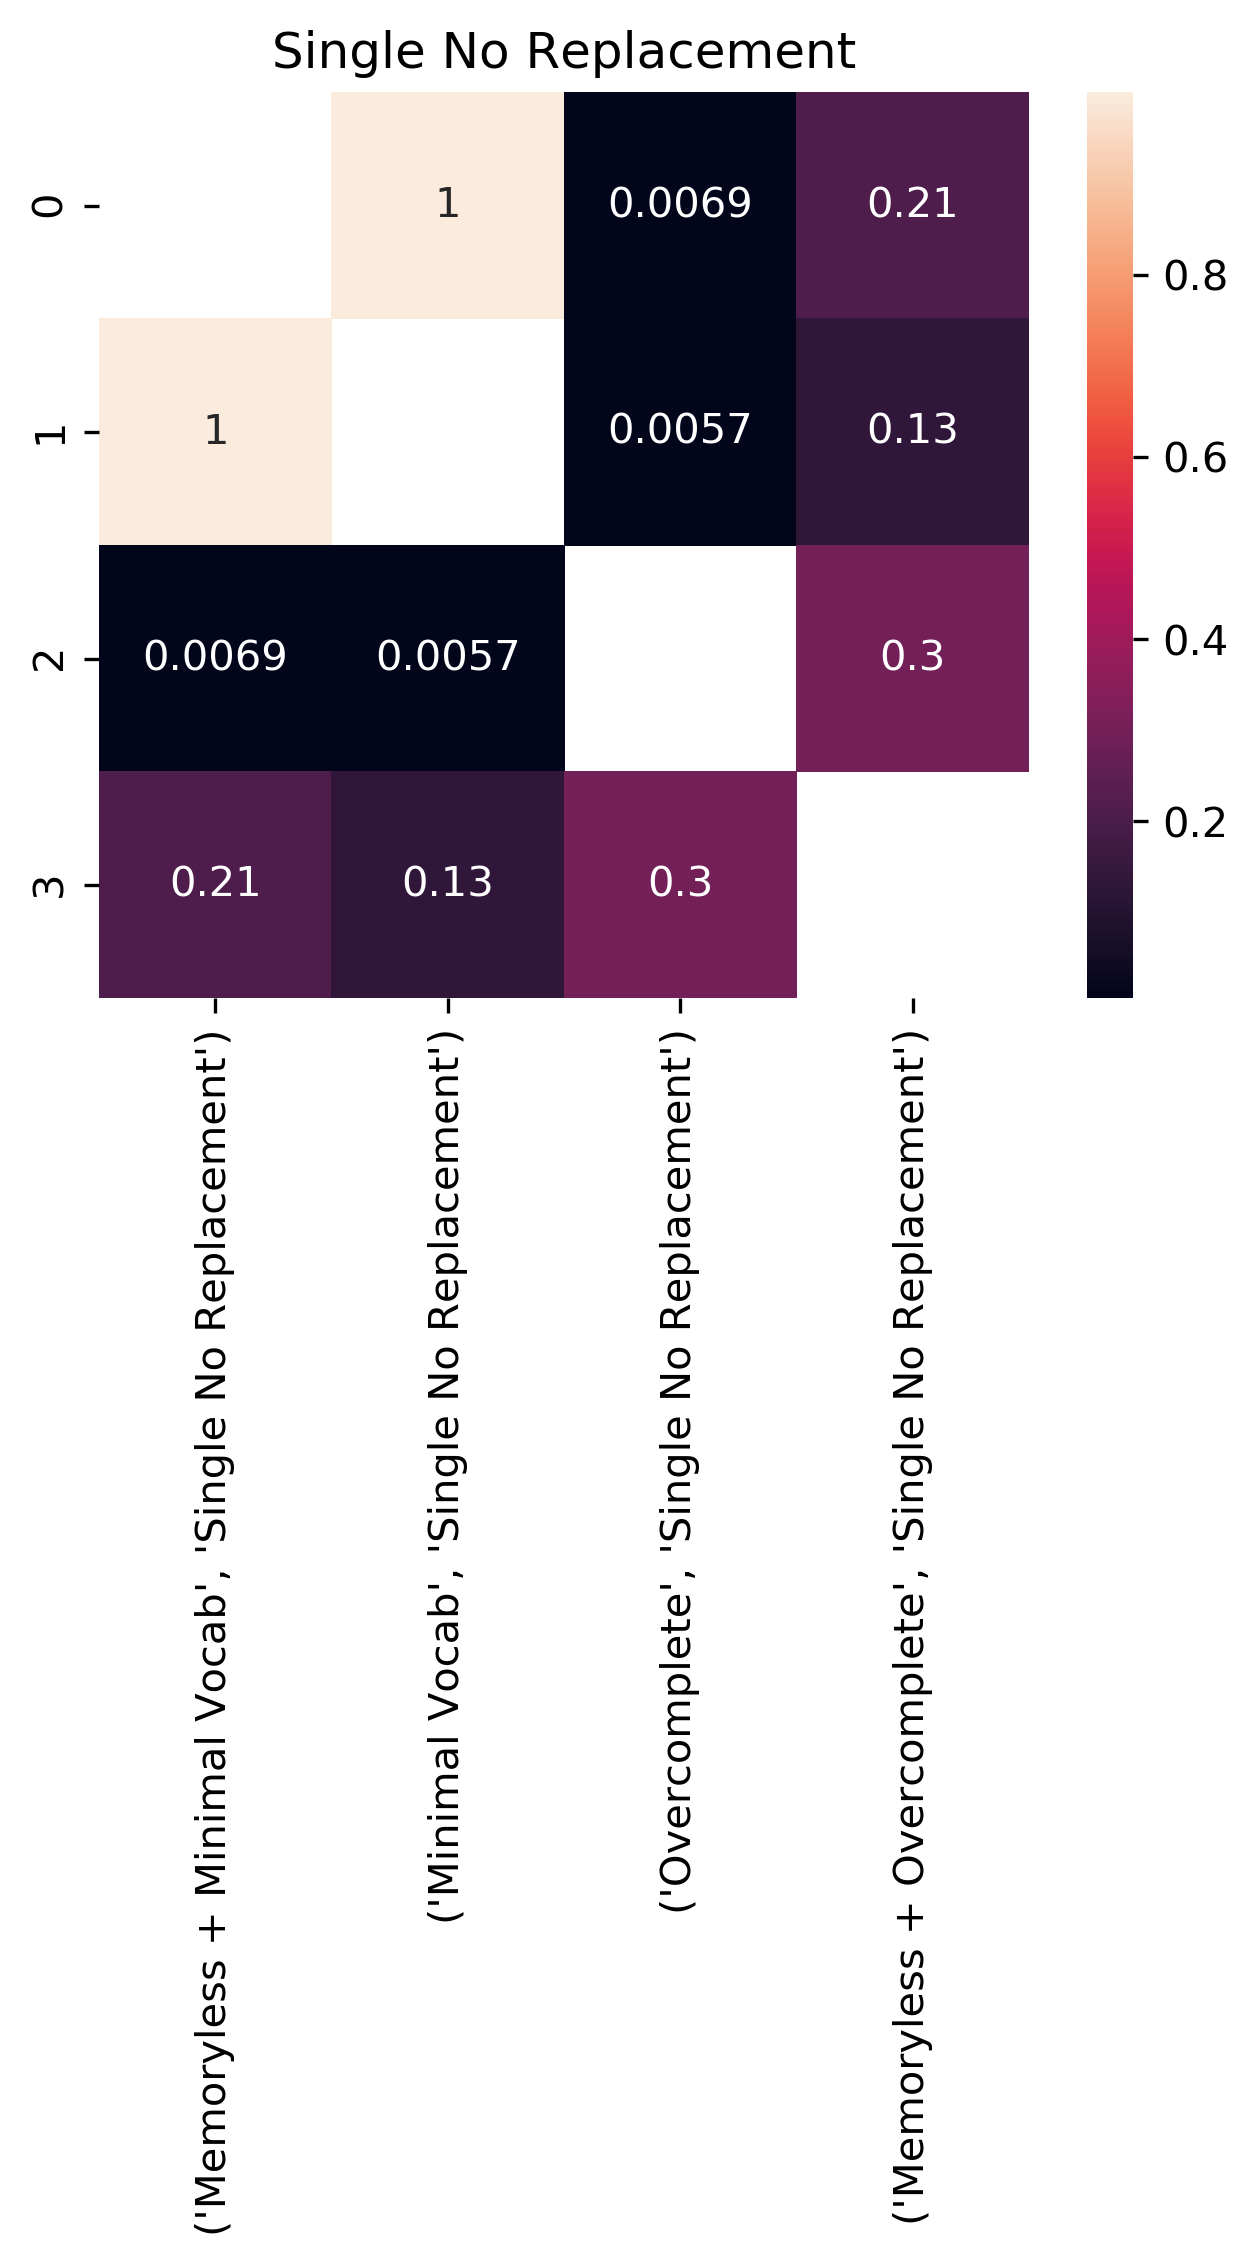

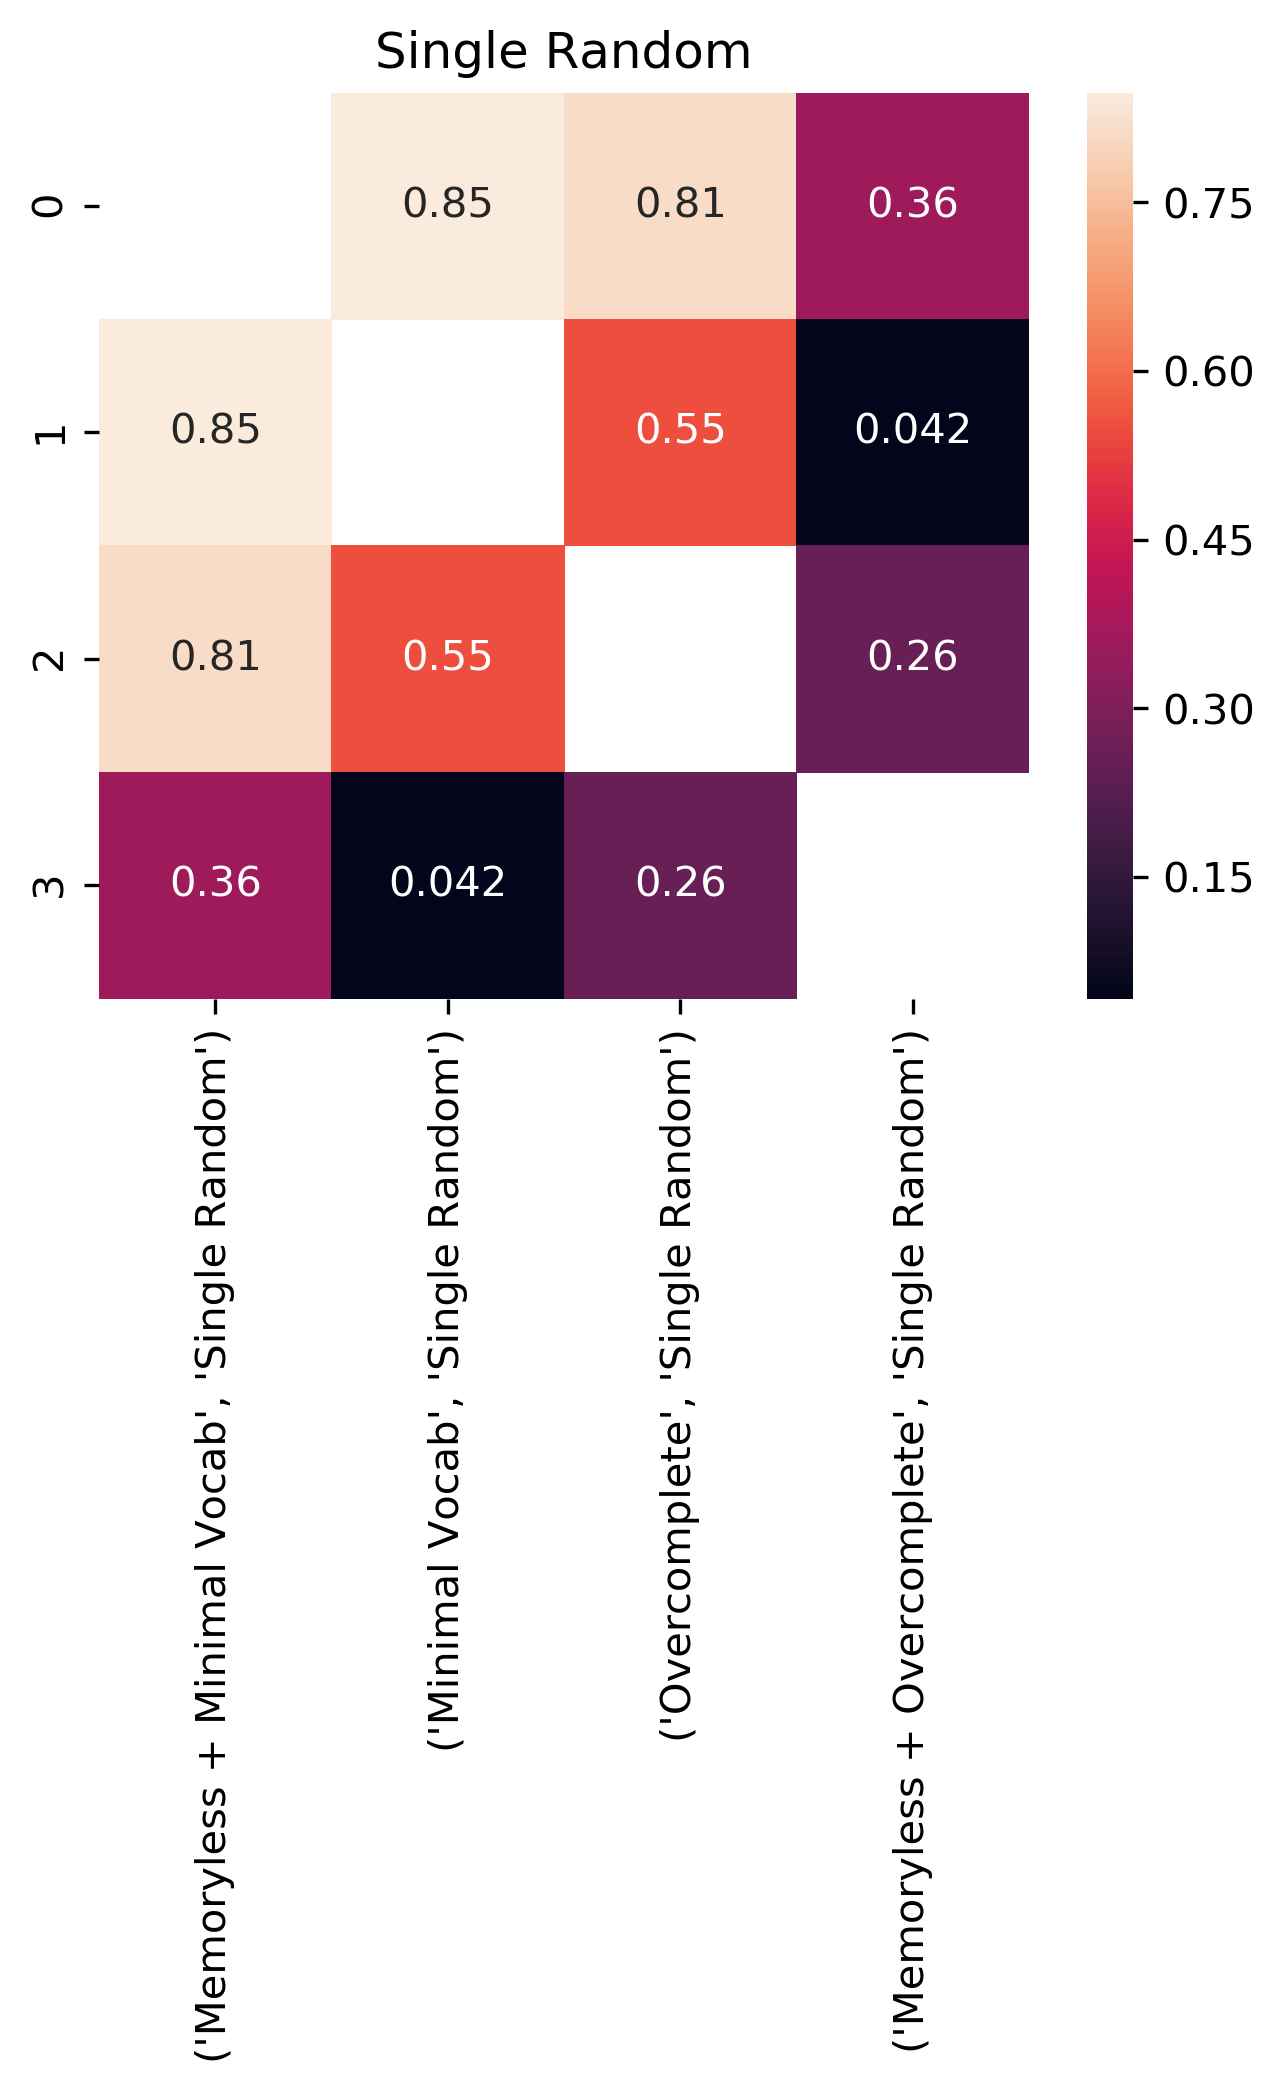

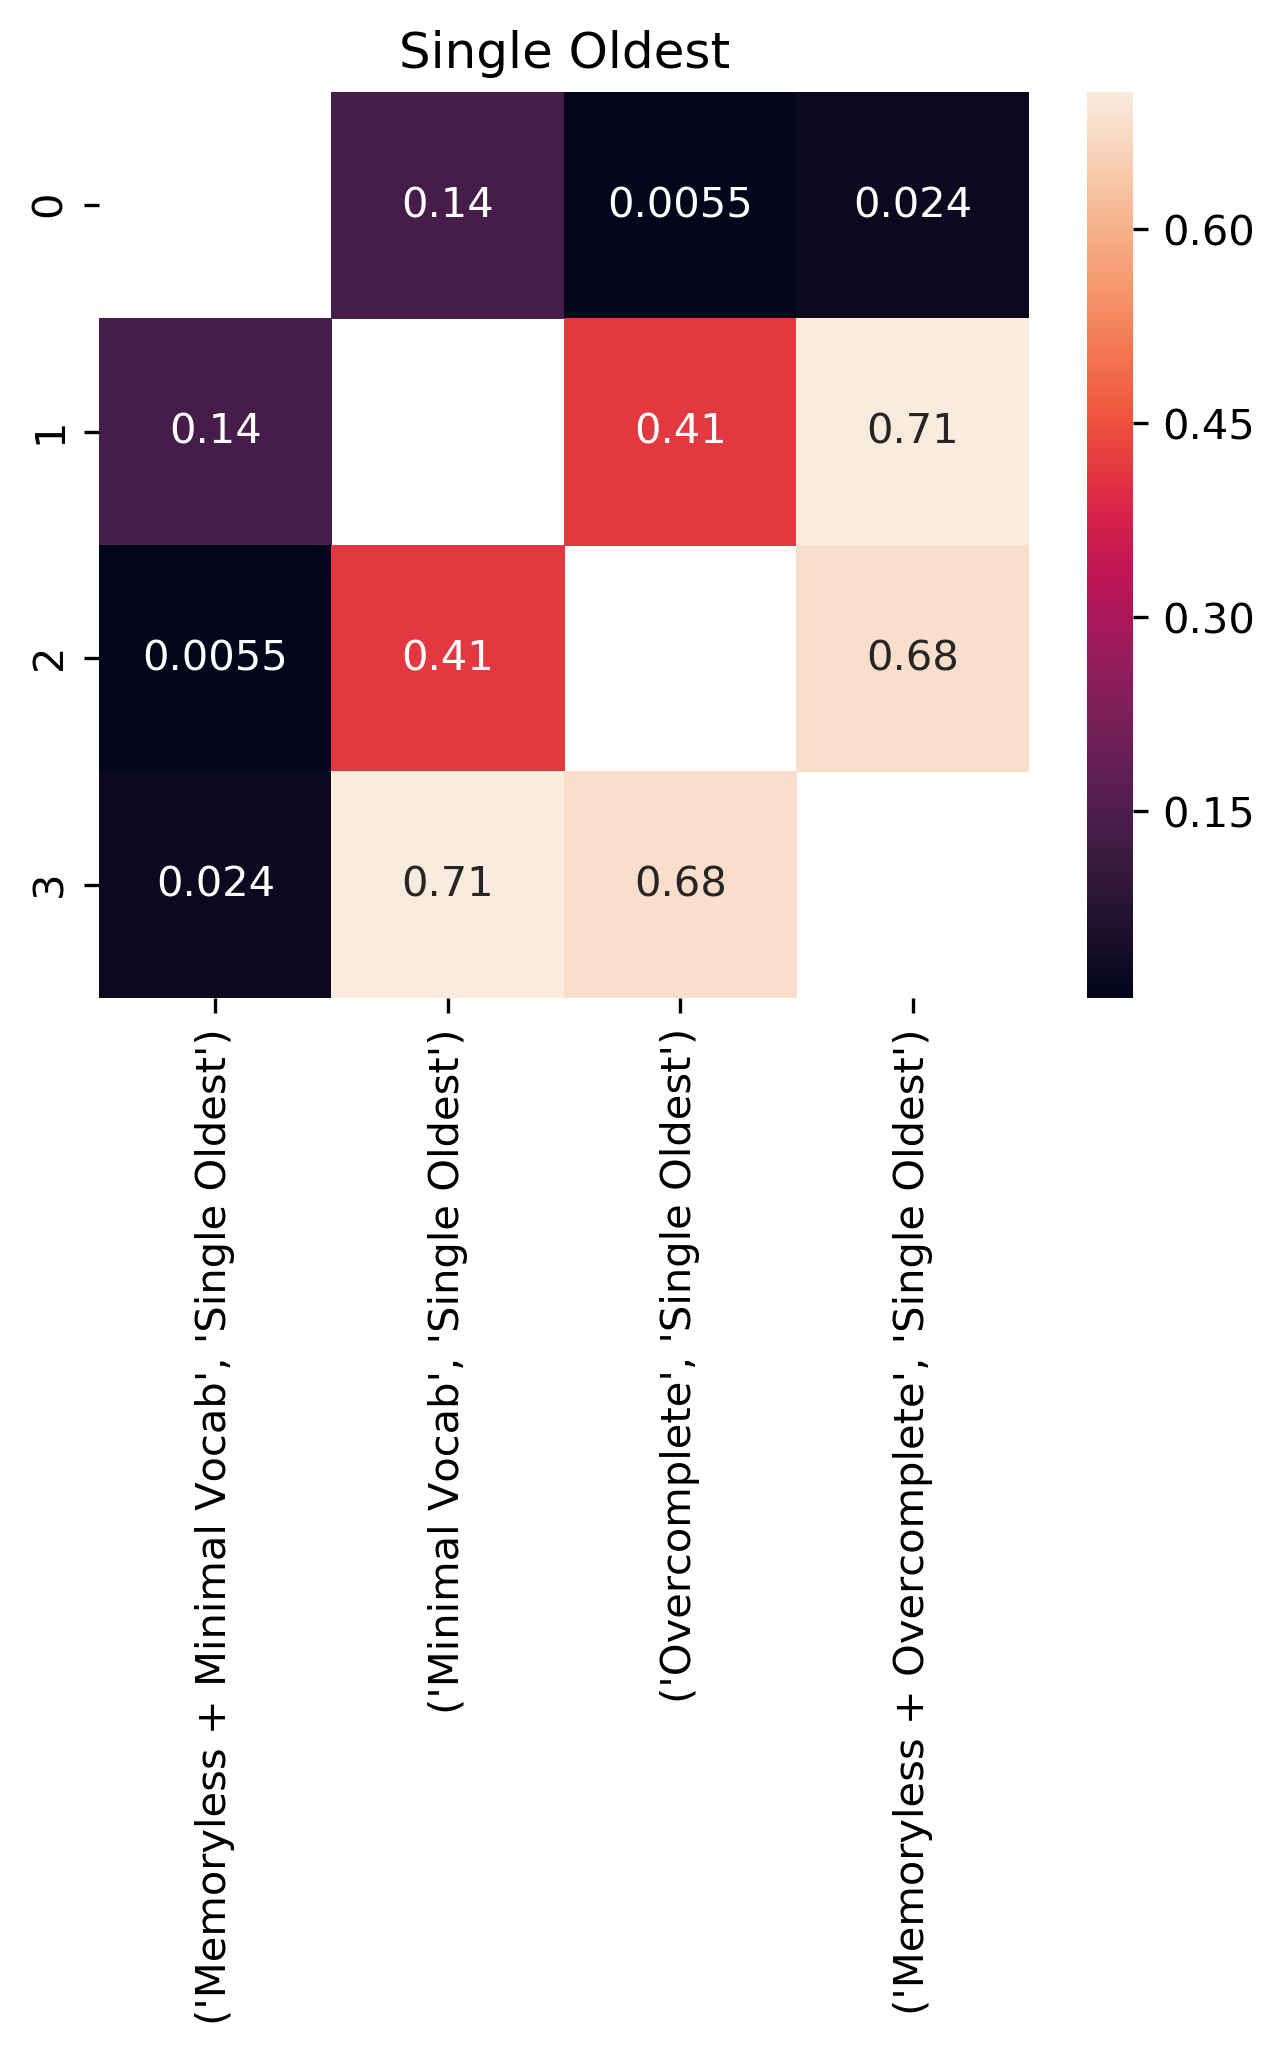

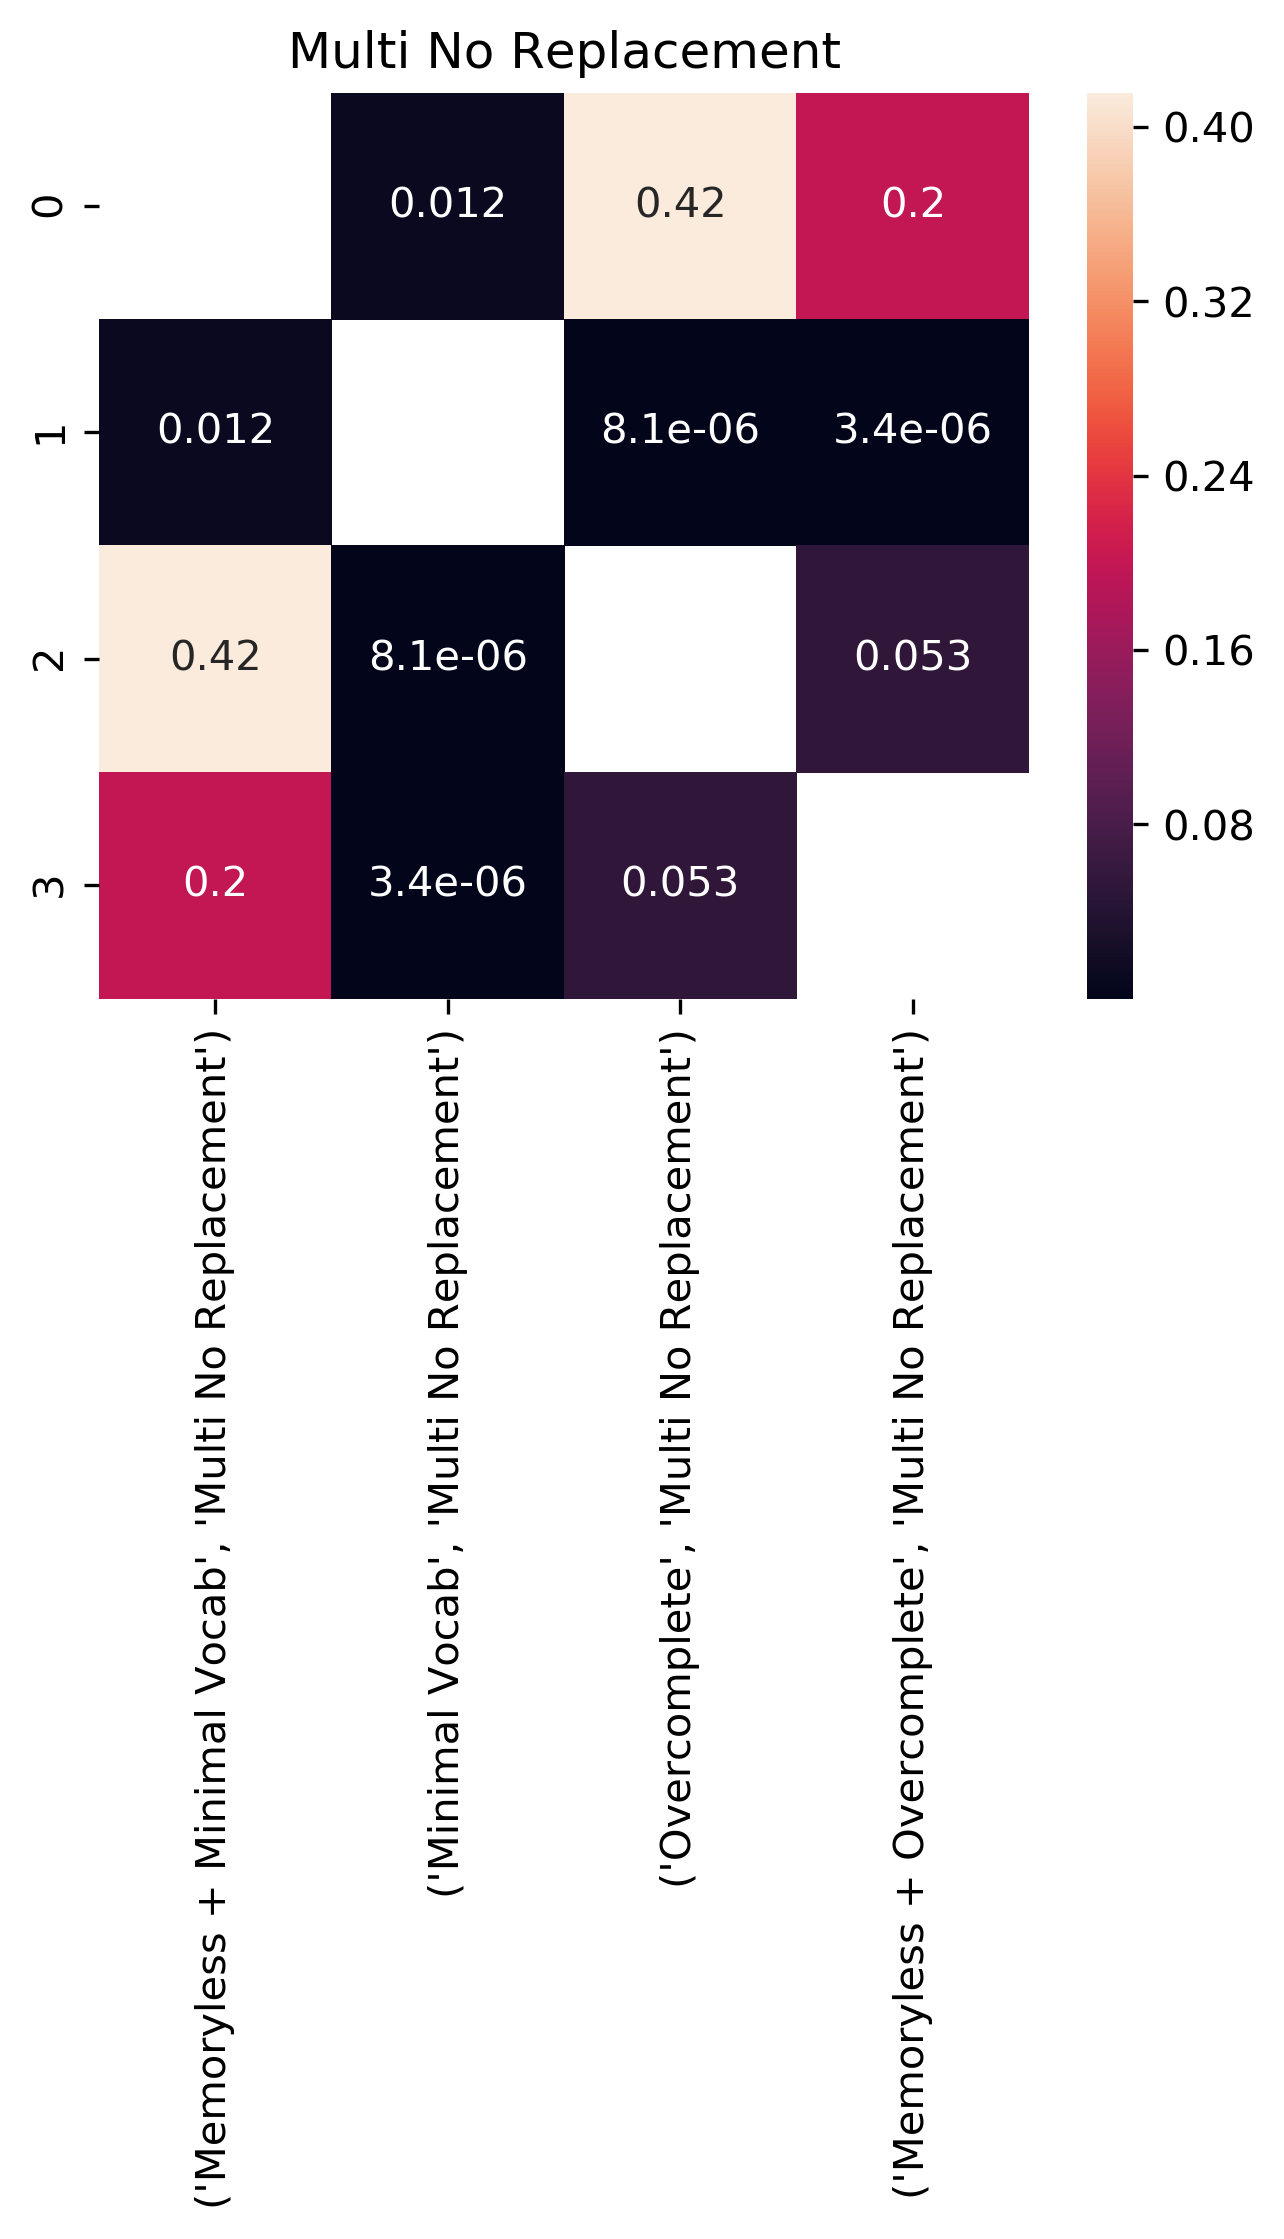

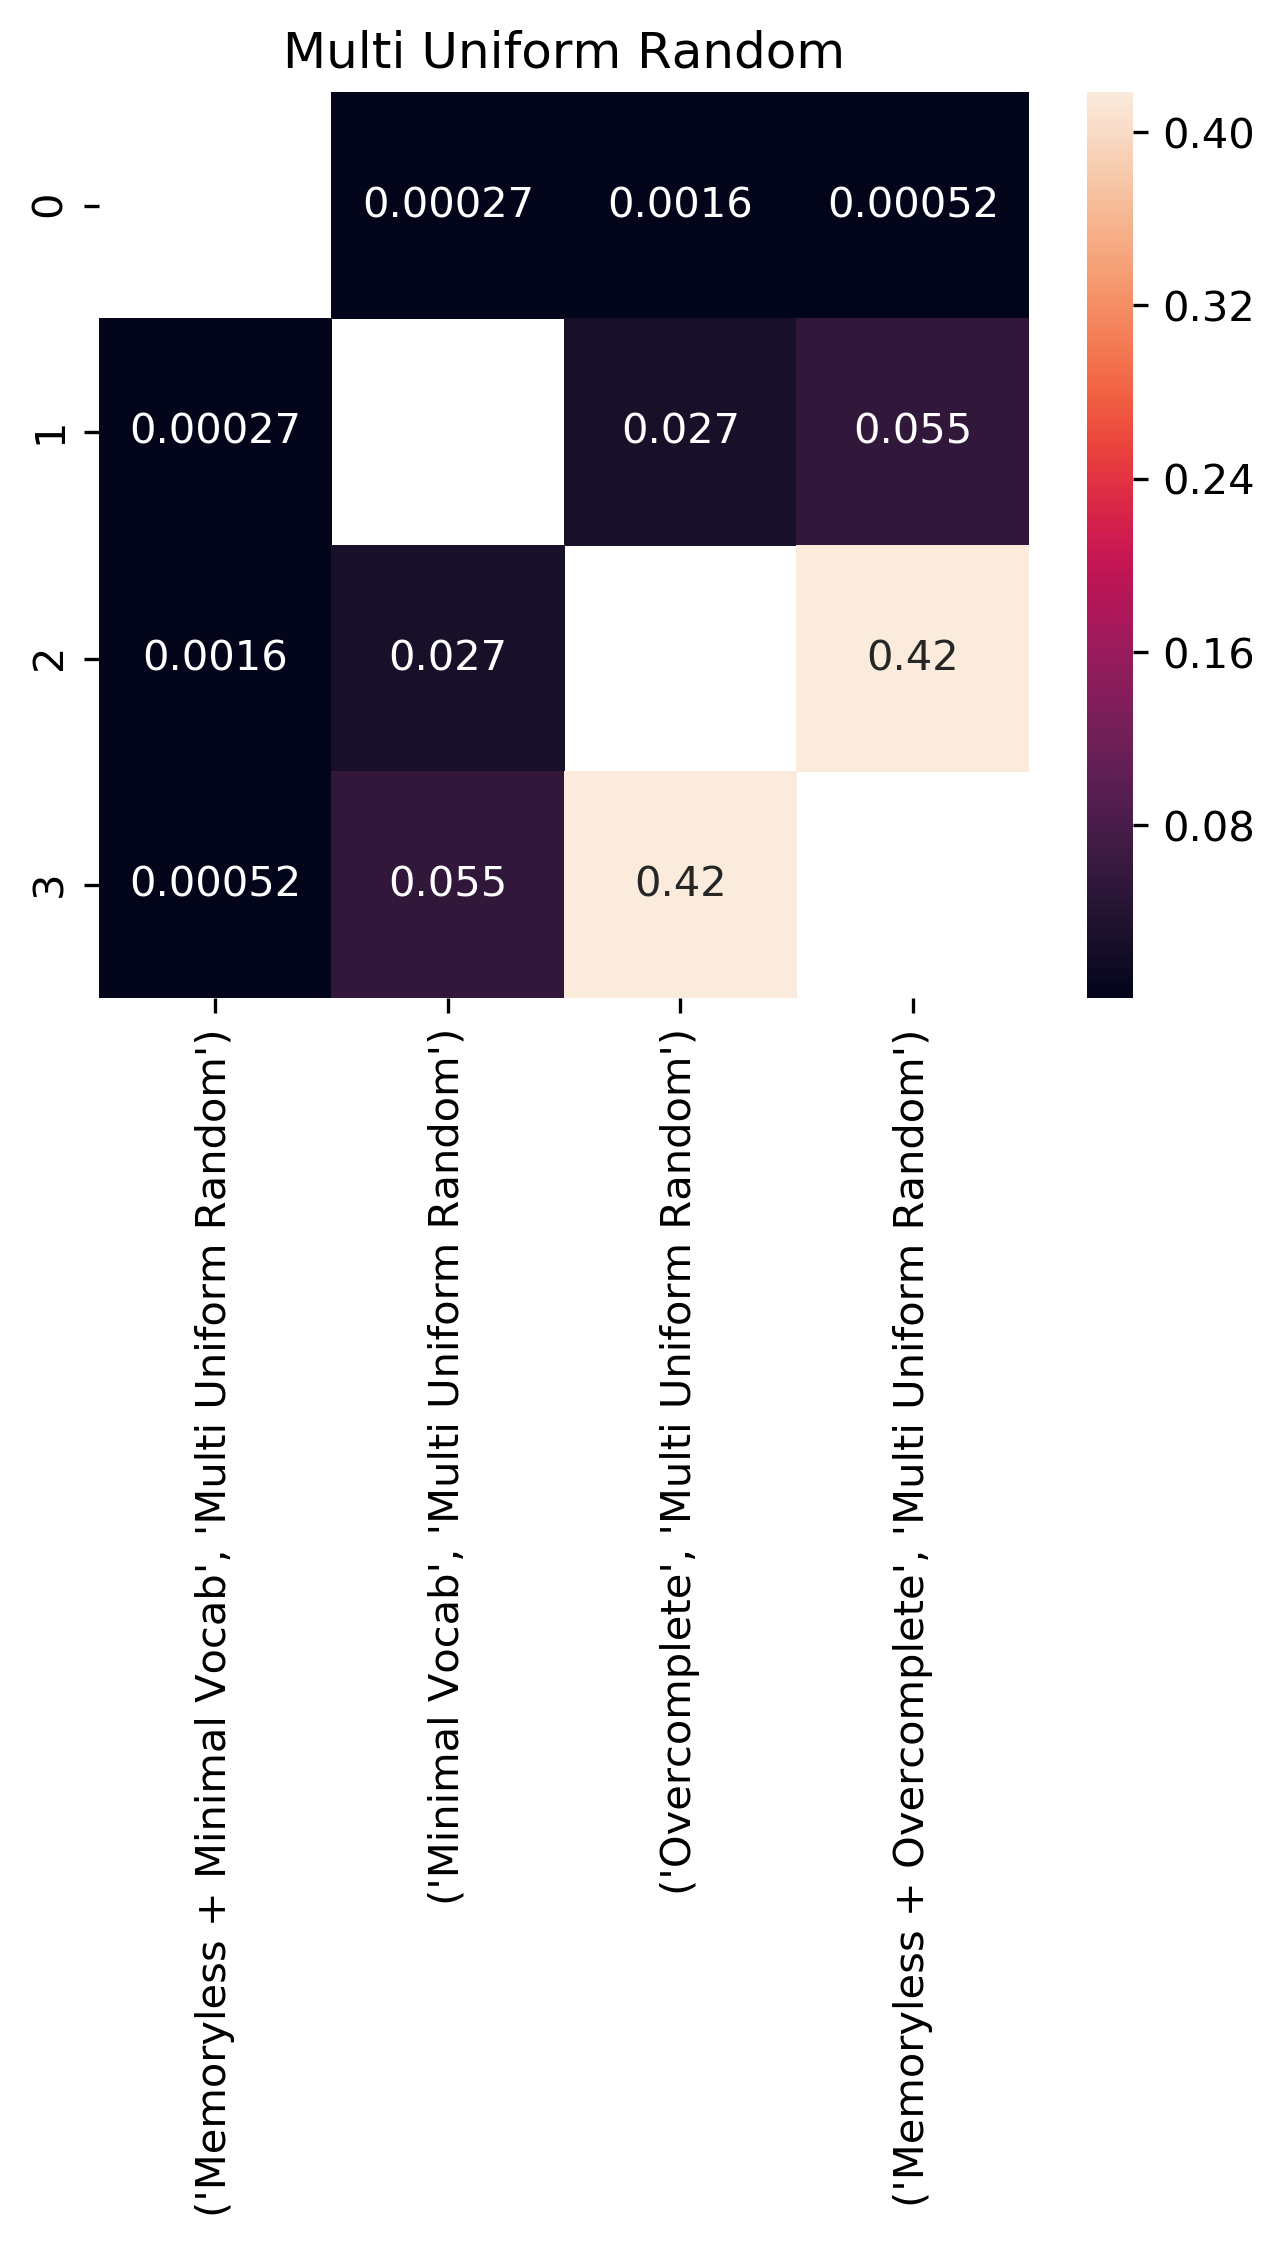

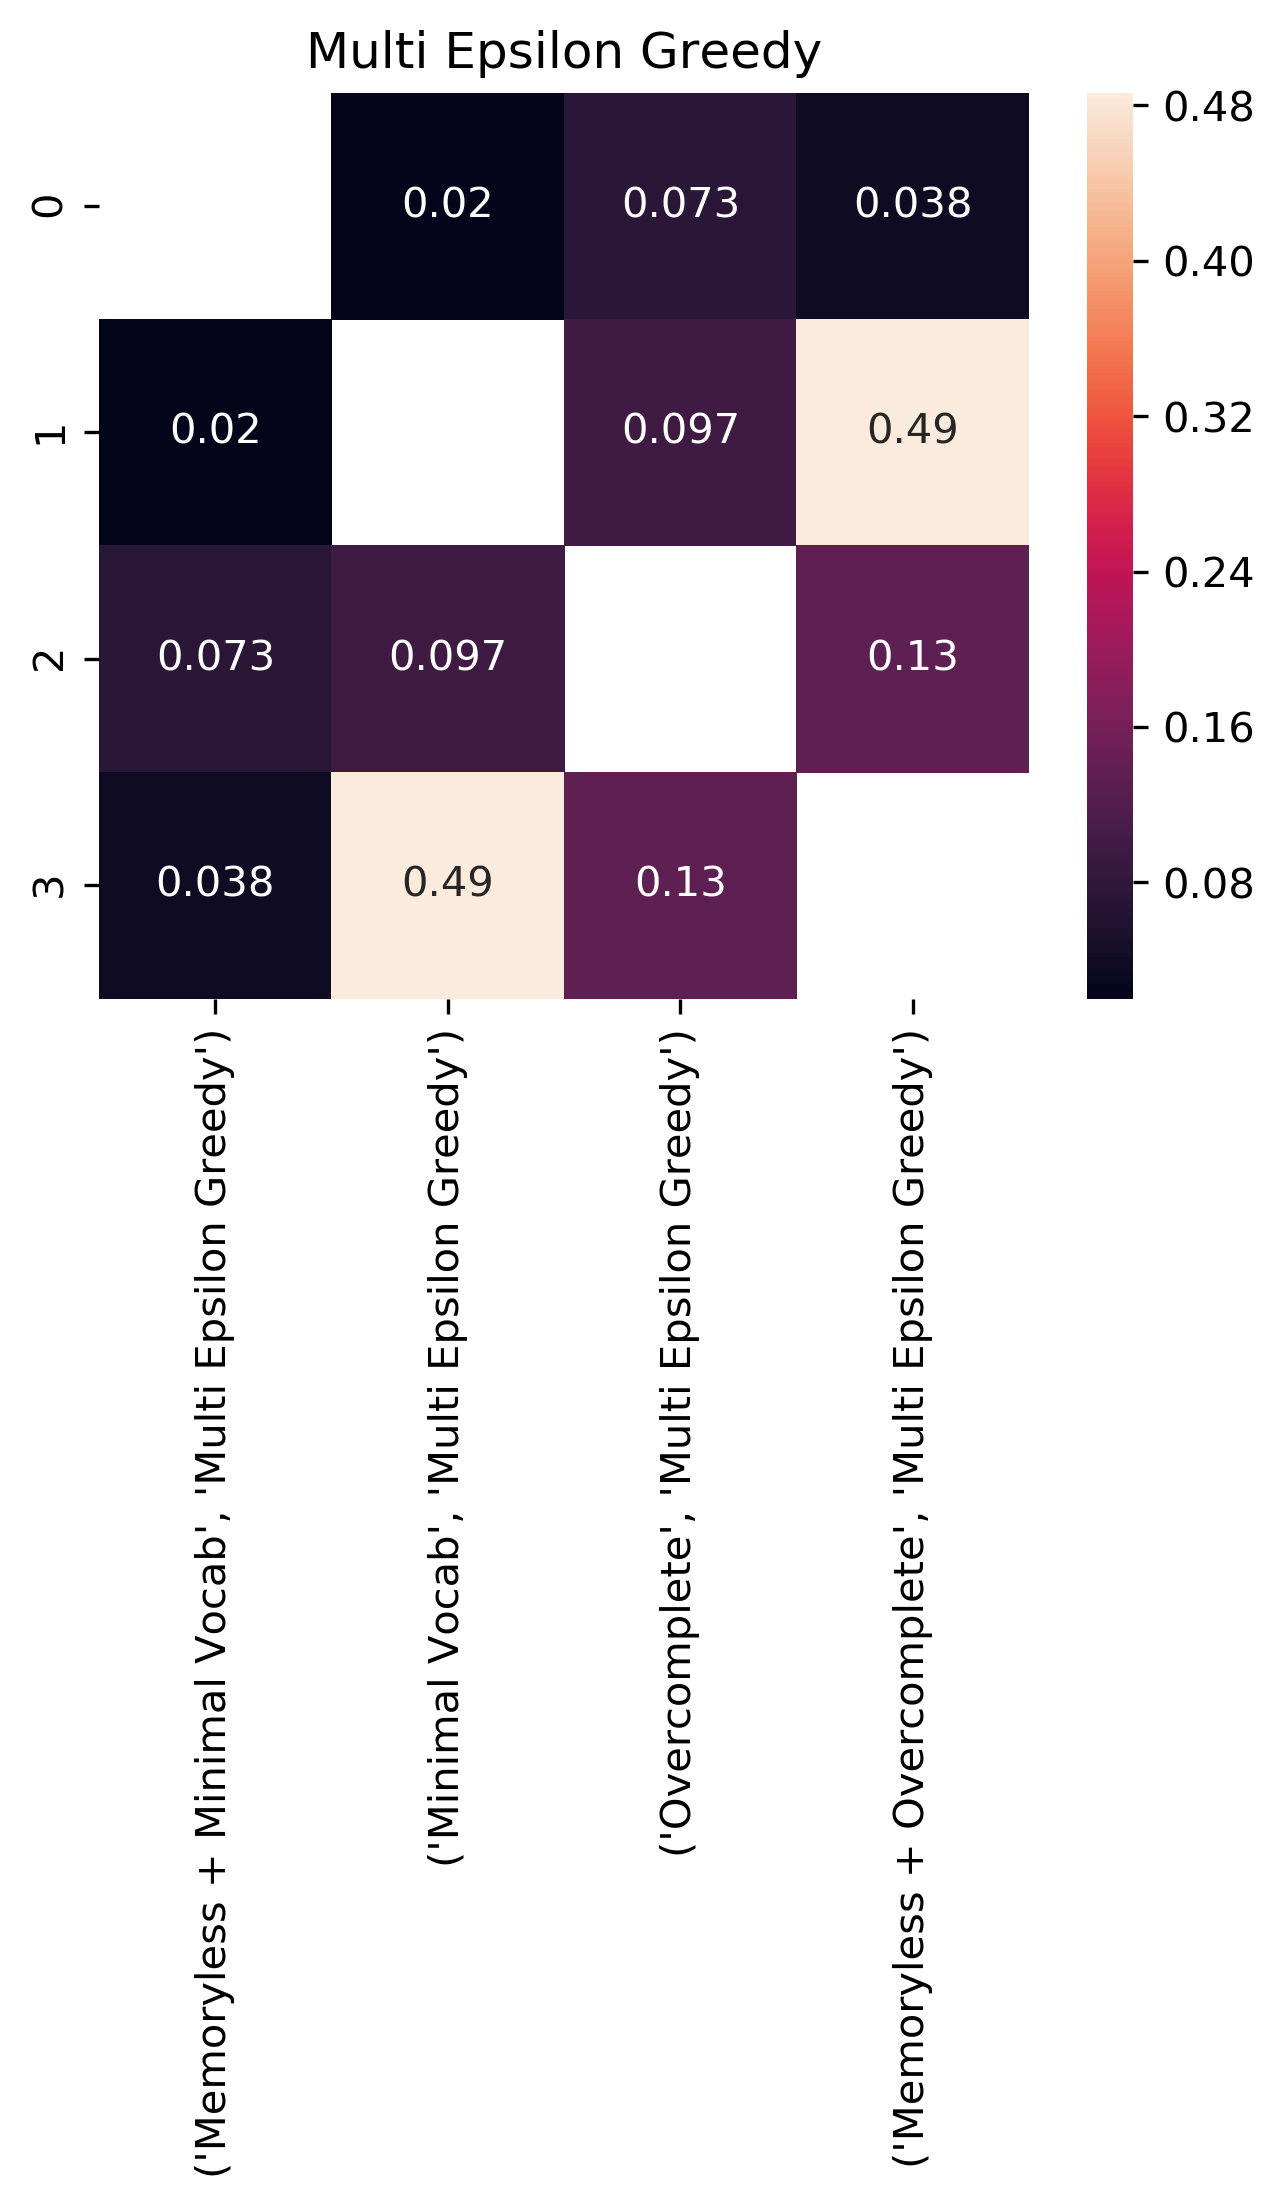

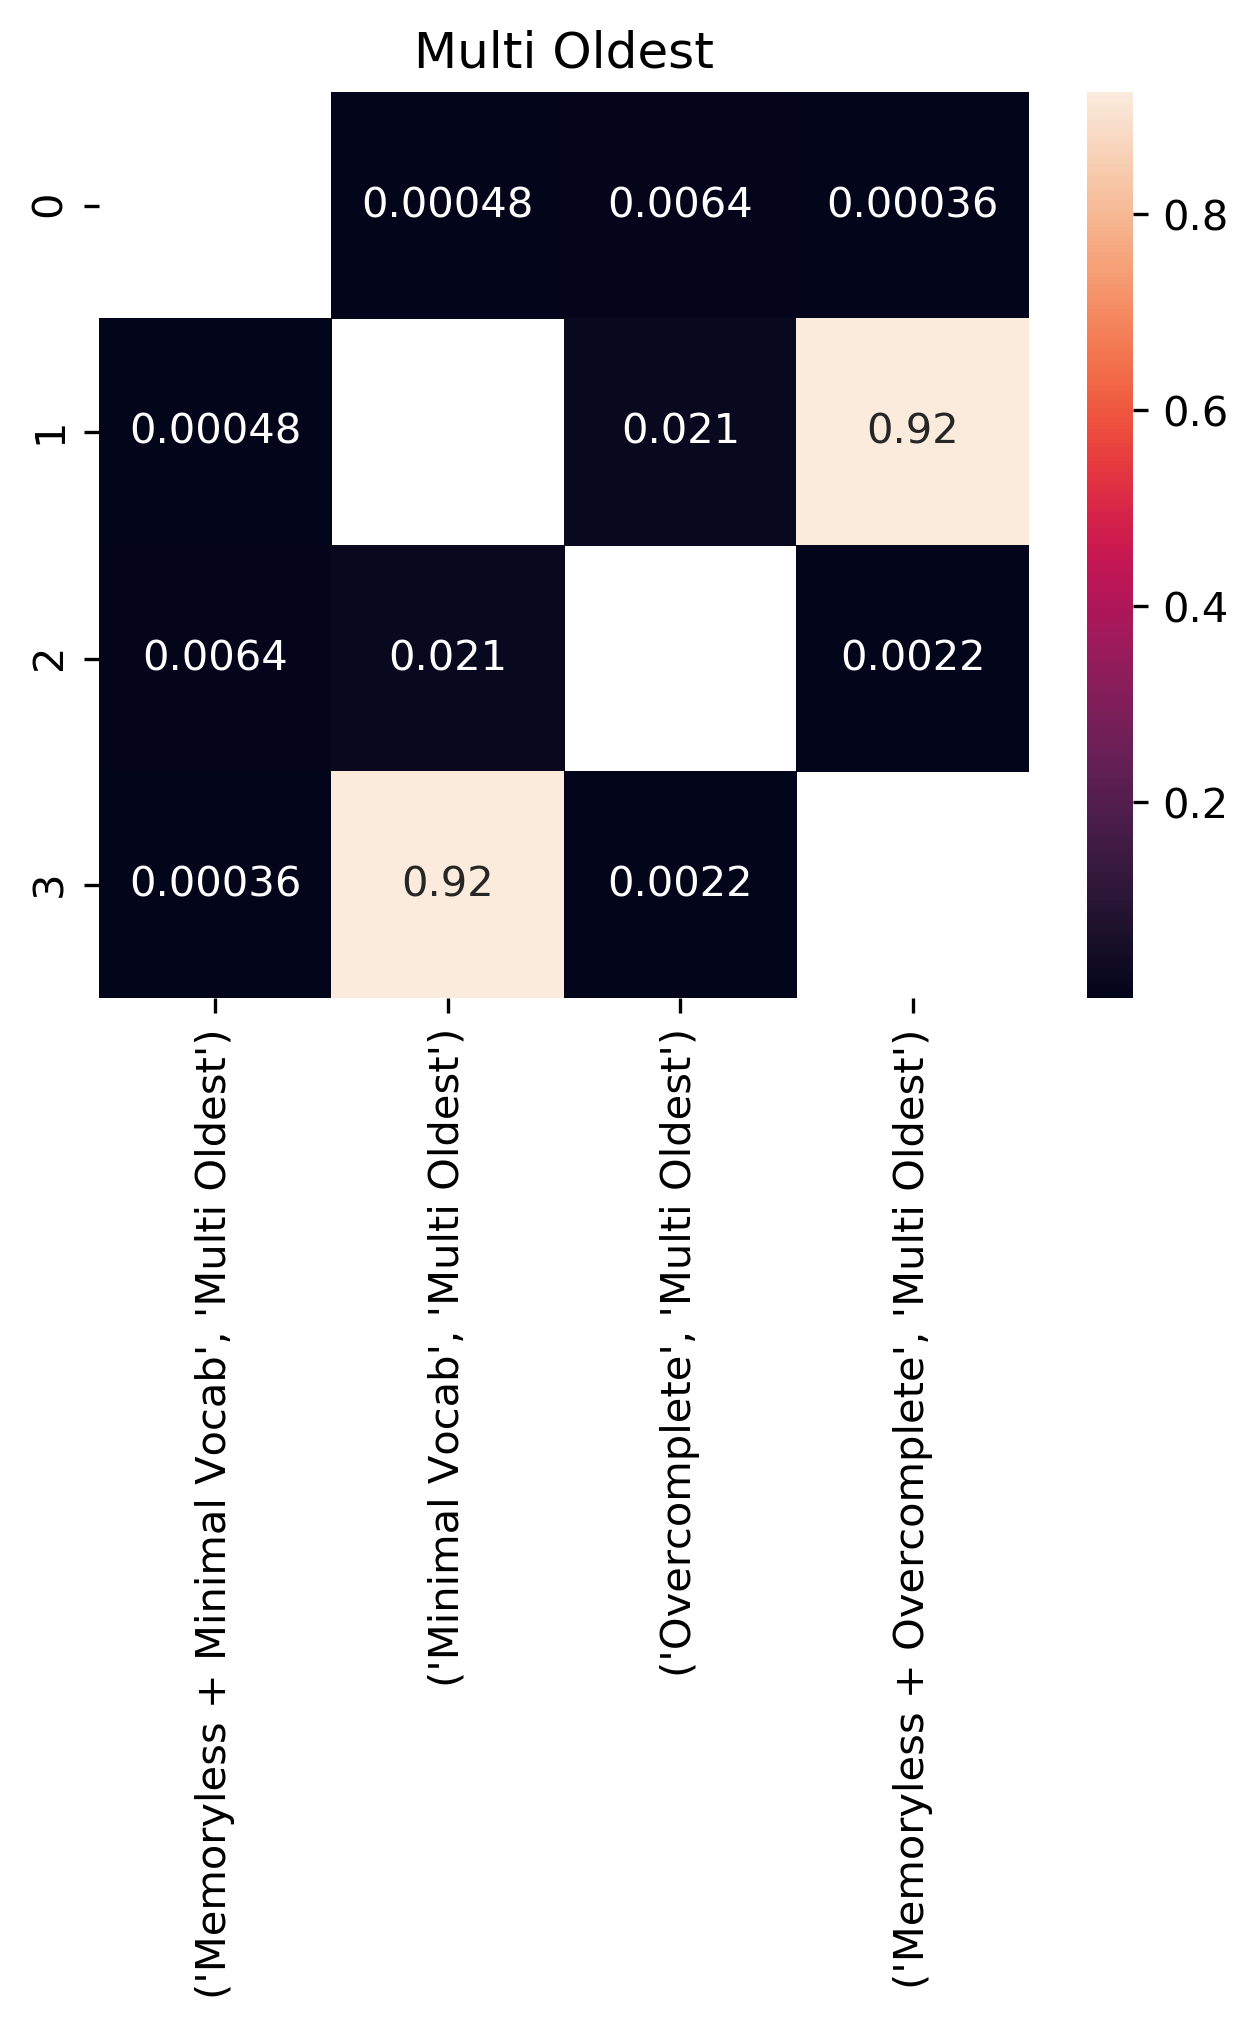

In [58]:
dname = 'data/figures/pvalues/by_method/'
os.makedirs(dname, exist_ok=True)
for i, method in enumerate(methods):
    if len(df[df.method == method].model.unique()) == 1:
        continue
    plt.figure(figsize=(5,4), dpi=300)
    plt.title(method)
    show_ttests('test_OO_both', df_filter=lambda df: df[df.method == method], pthresh=0.05, threshold=False)
    plt.savefig(pth.join(dname, 'test_' + method + '.png'), bbox_inches='tight')

## Intra Generation Language Similarity <a class="anchor" id="lang-sim"></a>

### Load Language Comparison Data

In [99]:
# exp7 - comp dataset - main experiments
exp_name = lambda mi, ti, di, fi, si, **k: 'exp7.{}.{}.{}.{}.{}'.format(mi, ti, di, fi, si)
models = [(0, 'Memoryless + Minimal Vocab'),
          ('2', 'Minimal Vocab'), #  (old: Va=4,Vq=3)
          (1, 'Overcomplete'),
          ('3', 'Memoryless + Overcomplete'),
          #('4', 'Small Vocab (Va=12, Vq=3)'),
         ]
training = [(0, 'Single No Replacement'),
            #(7, 'Single Replace All'),
            #(8, 'Multi All (shorter)'), # shorter
            (5, 'Single Random'),
            (6, 'Single Oldest'),
            (1, 'Multi No Replacement'), # shorter
            #(9, 'Multi Replace All'), # longer
            #(2, 'Multi Uniform Random (shorter)'), # shorter
            #(3, 'Multi Epsilon Greedy (shorter)'), # shorter
            #(4, 'Multi Oldest (shorter)'), # shorter
            (11, 'Multi Uniform Random'), # longer
            (12, 'Multi Epsilon Greedy'), # longer
            (10, 'Multi Oldest'), # longer
            #(13, 'Multi Oldest (n=10)'),
           ]
datasets = [(0, 'comp_cv')]
teaching = [(1, 'task-1 teach-1')]
folds = [(0, 0), (1, 1), (2, 2), (3, 3)]
seeds = [(0, 0), (1, 1), (2, 2), (3, 3)]

add_fresh_experiment(fixed_epoch=True)
#add_fresh_experiment()
show_records(['dataset', 'model', 'method', 'nqbots'])
#show_latex(['model', 'method'], fields=['test_OO_both'])

ERROR:root:File `'this.py'` not found.


In [60]:
# exp7 + baselines lang analysis
add_fresh_lang_experiment(fixed_epoch=True)

# NOTE: this changes the global variables from exp7... TODO: refactor out those globals
# baselines for language comparison
# exp8 - random initialization
exp_name = lambda mi, ti, di, fi, si, **k: 'exp8.{}.{}.{}.{}.{}'.format(mi, ti, di, fi, si)
models = [(0, 'Memoryless + Minimal Vocab'), (1, 'Overcomplete'), (2, 'Minimal Vocab'), (3, 'Memoryless + Overcomplete')]
# this ran for 4 different versions (what was previously 4 versions of multi agent training)... all are equivalent, I take the first
training = [(1, 'Random Initialization')]
datasets = [(0, 'comp_cv')] #, (1, 'comp_nocv')]
teaching = [(1, 'task-1 teach-1')]
folds = [(0, 0), (1, 1), (2, 2), (3, 3)]
seeds = [(0, 0), (1, 1), (2, 2), (3, 3)]
add_lang_experiment()

# exp9 - single agent initialization
exp_name = lambda mi, ti, di, fi, si, **k: 'exp9.{}.{}.{}.{}.{}'.format(mi, ti, di, fi, si)
models = [(0, 'Memoryless + Minimal Vocab'), (1, 'Overcomplete'), (2, 'Minimal Vocab'), (3, 'Memoryless + Overcomplete')]
training = [(0, 'Single Agents Combined')] #(1, 'multi-agent-5'), (2, 'random killing'), (3, 'eps greedy eps=0.2'), (4, 'oldest')]
datasets = [(0, 'comp_cv')] #, (1, 'comp_nocv')]
teaching = [(1, 'task-1 teach-1')]
folds = [(0, 0), (1, 1), (2, 2), (3, 3)]
seeds = [(-1, -1)] #, (1, 1), (2, 2), (3, 3)]
add_lang_experiment(fixed_epoch=True)

fresh lang
fixed epoch, using data/experiments/exp7.0.0.0.0.0/models/results_lang_analysis_ep_39000.json
[lang] skipping exp7.0.0.0.0.0 (could not find data/experiments/exp7.0.0.0.0.0/models/results_lang_analysis_ep_39000.json)
fixed epoch, using data/experiments/exp7.0.0.0.0.1/models/results_lang_analysis_ep_39000.json
[lang] skipping exp7.0.0.0.0.1 (could not find data/experiments/exp7.0.0.0.0.1/models/results_lang_analysis_ep_39000.json)
fixed epoch, using data/experiments/exp7.0.0.0.0.2/models/results_lang_analysis_ep_39000.json
[lang] skipping exp7.0.0.0.0.2 (could not find data/experiments/exp7.0.0.0.0.2/models/results_lang_analysis_ep_39000.json)
fixed epoch, using data/experiments/exp7.0.0.0.0.3/models/results_lang_analysis_ep_39000.json
[lang] skipping exp7.0.0.0.0.3 (could not find data/experiments/exp7.0.0.0.0.3/models/results_lang_analysis_ep_39000.json)
fixed epoch, using data/experiments/exp7.0.0.0.1.0/models/results_lang_analysis_ep_39000.json
[lang] skipping exp7.0.0.0.

[lang] skipping exp7.2.5.0.2.2 (could not find data/experiments/exp7.2.5.0.2.2/models/results_lang_analysis_ep_39000.json)
fixed epoch, using data/experiments/exp7.2.5.0.2.3/models/results_lang_analysis_ep_39000.json
[lang] skipping exp7.2.5.0.2.3 (could not find data/experiments/exp7.2.5.0.2.3/models/results_lang_analysis_ep_39000.json)
fixed epoch, using data/experiments/exp7.2.5.0.3.0/models/results_lang_analysis_ep_39000.json
[lang] skipping exp7.2.5.0.3.0 (could not find data/experiments/exp7.2.5.0.3.0/models/results_lang_analysis_ep_39000.json)
fixed epoch, using data/experiments/exp7.2.5.0.3.1/models/results_lang_analysis_ep_39000.json
[lang] skipping exp7.2.5.0.3.1 (could not find data/experiments/exp7.2.5.0.3.1/models/results_lang_analysis_ep_39000.json)
fixed epoch, using data/experiments/exp7.2.5.0.3.2/models/results_lang_analysis_ep_39000.json
[lang] skipping exp7.2.5.0.3.2 (could not find data/experiments/exp7.2.5.0.3.2/models/results_lang_analysis_ep_39000.json)
fixed epo

[lang] added exp7.1.12.0.3.3
[199000]
fixed epoch, using data/experiments/exp7.1.10.0.0.0/models/results_lang_analysis_ep_199000.json
[lang] added exp7.1.10.0.0.0
[199000]
fixed epoch, using data/experiments/exp7.1.10.0.0.1/models/results_lang_analysis_ep_199000.json
[lang] added exp7.1.10.0.0.1
[199000]
fixed epoch, using data/experiments/exp7.1.10.0.0.2/models/results_lang_analysis_ep_199000.json
[lang] added exp7.1.10.0.0.2
[199000]
fixed epoch, using data/experiments/exp7.1.10.0.0.3/models/results_lang_analysis_ep_199000.json
[lang] added exp7.1.10.0.0.3
[199000]
fixed epoch, using data/experiments/exp7.1.10.0.1.0/models/results_lang_analysis_ep_199000.json
[lang] added exp7.1.10.0.1.0
[199000]
fixed epoch, using data/experiments/exp7.1.10.0.1.1/models/results_lang_analysis_ep_199000.json
[lang] added exp7.1.10.0.1.1
[199000]
fixed epoch, using data/experiments/exp7.1.10.0.1.2/models/results_lang_analysis_ep_199000.json
[lang] added exp7.1.10.0.1.2
[199000]
fixed epoch, using data/

### Compute and Display Similarity Results

In [61]:
lang_df = pd.DataFrame.from_records(lang_records, columns=lang_columns)

In [62]:
lang_df = lang_df[((lang_df.epoch == 199000) | 
                   ((lang_df.epoch == 39000) & (lang_df.method == 'Single Agents Combined')) | 
                   (lang_df.epoch == 'initial'))]

In [64]:
def show_lang_analysis_tablev2(metric, lang_df):
    gf = lang_df.groupby(['model', 'method']).agg(['mean', 'std'])[[metric]]
    key = metric.replace('_', ' ')
    gf[key] = gf[(metric, 'mean')].map(lambda s: '{:.2f}'.format(s)) + ' $\pm$ ' + \
               gf[(metric, 'std')].map(lambda s: '{:5.2f}'.format(s))

    def agg(results):
        assert len(results) == 1
        return results[0]
    pivot = pd.pivot_table(gf, index=['method'], columns=['model'], values=[key], aggfunc=agg)
    #return pivot
    print(pivot.to_latex(escape=False))

In [65]:
#show_lang_analysis_tablev2('abot_dist', lang_df)

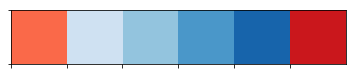

In [66]:
methods = [
            'Single Agents Combined',
            'Multi No Replacement', 
            #'Multi Replace All',
            'Multi Uniform Random',
            'Multi Epsilon Greedy',
            'Multi Oldest',
            'Random Initialization'
          ]
models = [
    'Memoryless + Minimal Vocab',
    'Minimal Vocab',
    'Memoryless + Overcomplete',
    'Overcomplete'
]
pal = sns.color_palette('Reds', 3)[1:2] + sns.color_palette('Blues', len(methods) - 2) + sns.color_palette('Reds', 3)[2:]
sns.palplot(pal)

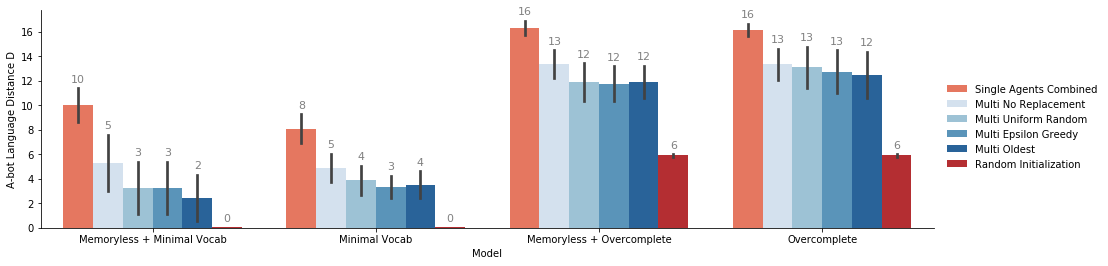

In [67]:
plt.figure(figsize=(16,4)) #, dpi=600)

ykey = 'abot_dist'
ax = sns.barplot(x='model', y=ykey, hue='method', data=lang_df, ci='sd',
           palette=pal, hue_order=methods, order=models)
plt.xlabel('Model')
plt.ylabel('A-bot Language Distance D')
#plt.legend(loc='upper right')

for i, p in enumerate(ax.patches):
    method_i = i // 4
    model_i = i % 4
    _df = lang_df[lang_df.method == methods[method_i]]
    _df = _df[_df.model == models[model_i]]
    std = _df[ykey].std()
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height() + std),
     ha='center', va='bottom', fontsize=11, color='gray', rotation=0, xytext=(0, 4),
     textcoords='offset points')

ax.legend(loc=(1.01,0.25), ncol=1, fancybox=False, shadow=False, frameon=False)
sns.despine()
plt.savefig('data/figures/{}_results.png'.format(ykey), bbox_inches='tight', dpi=600)

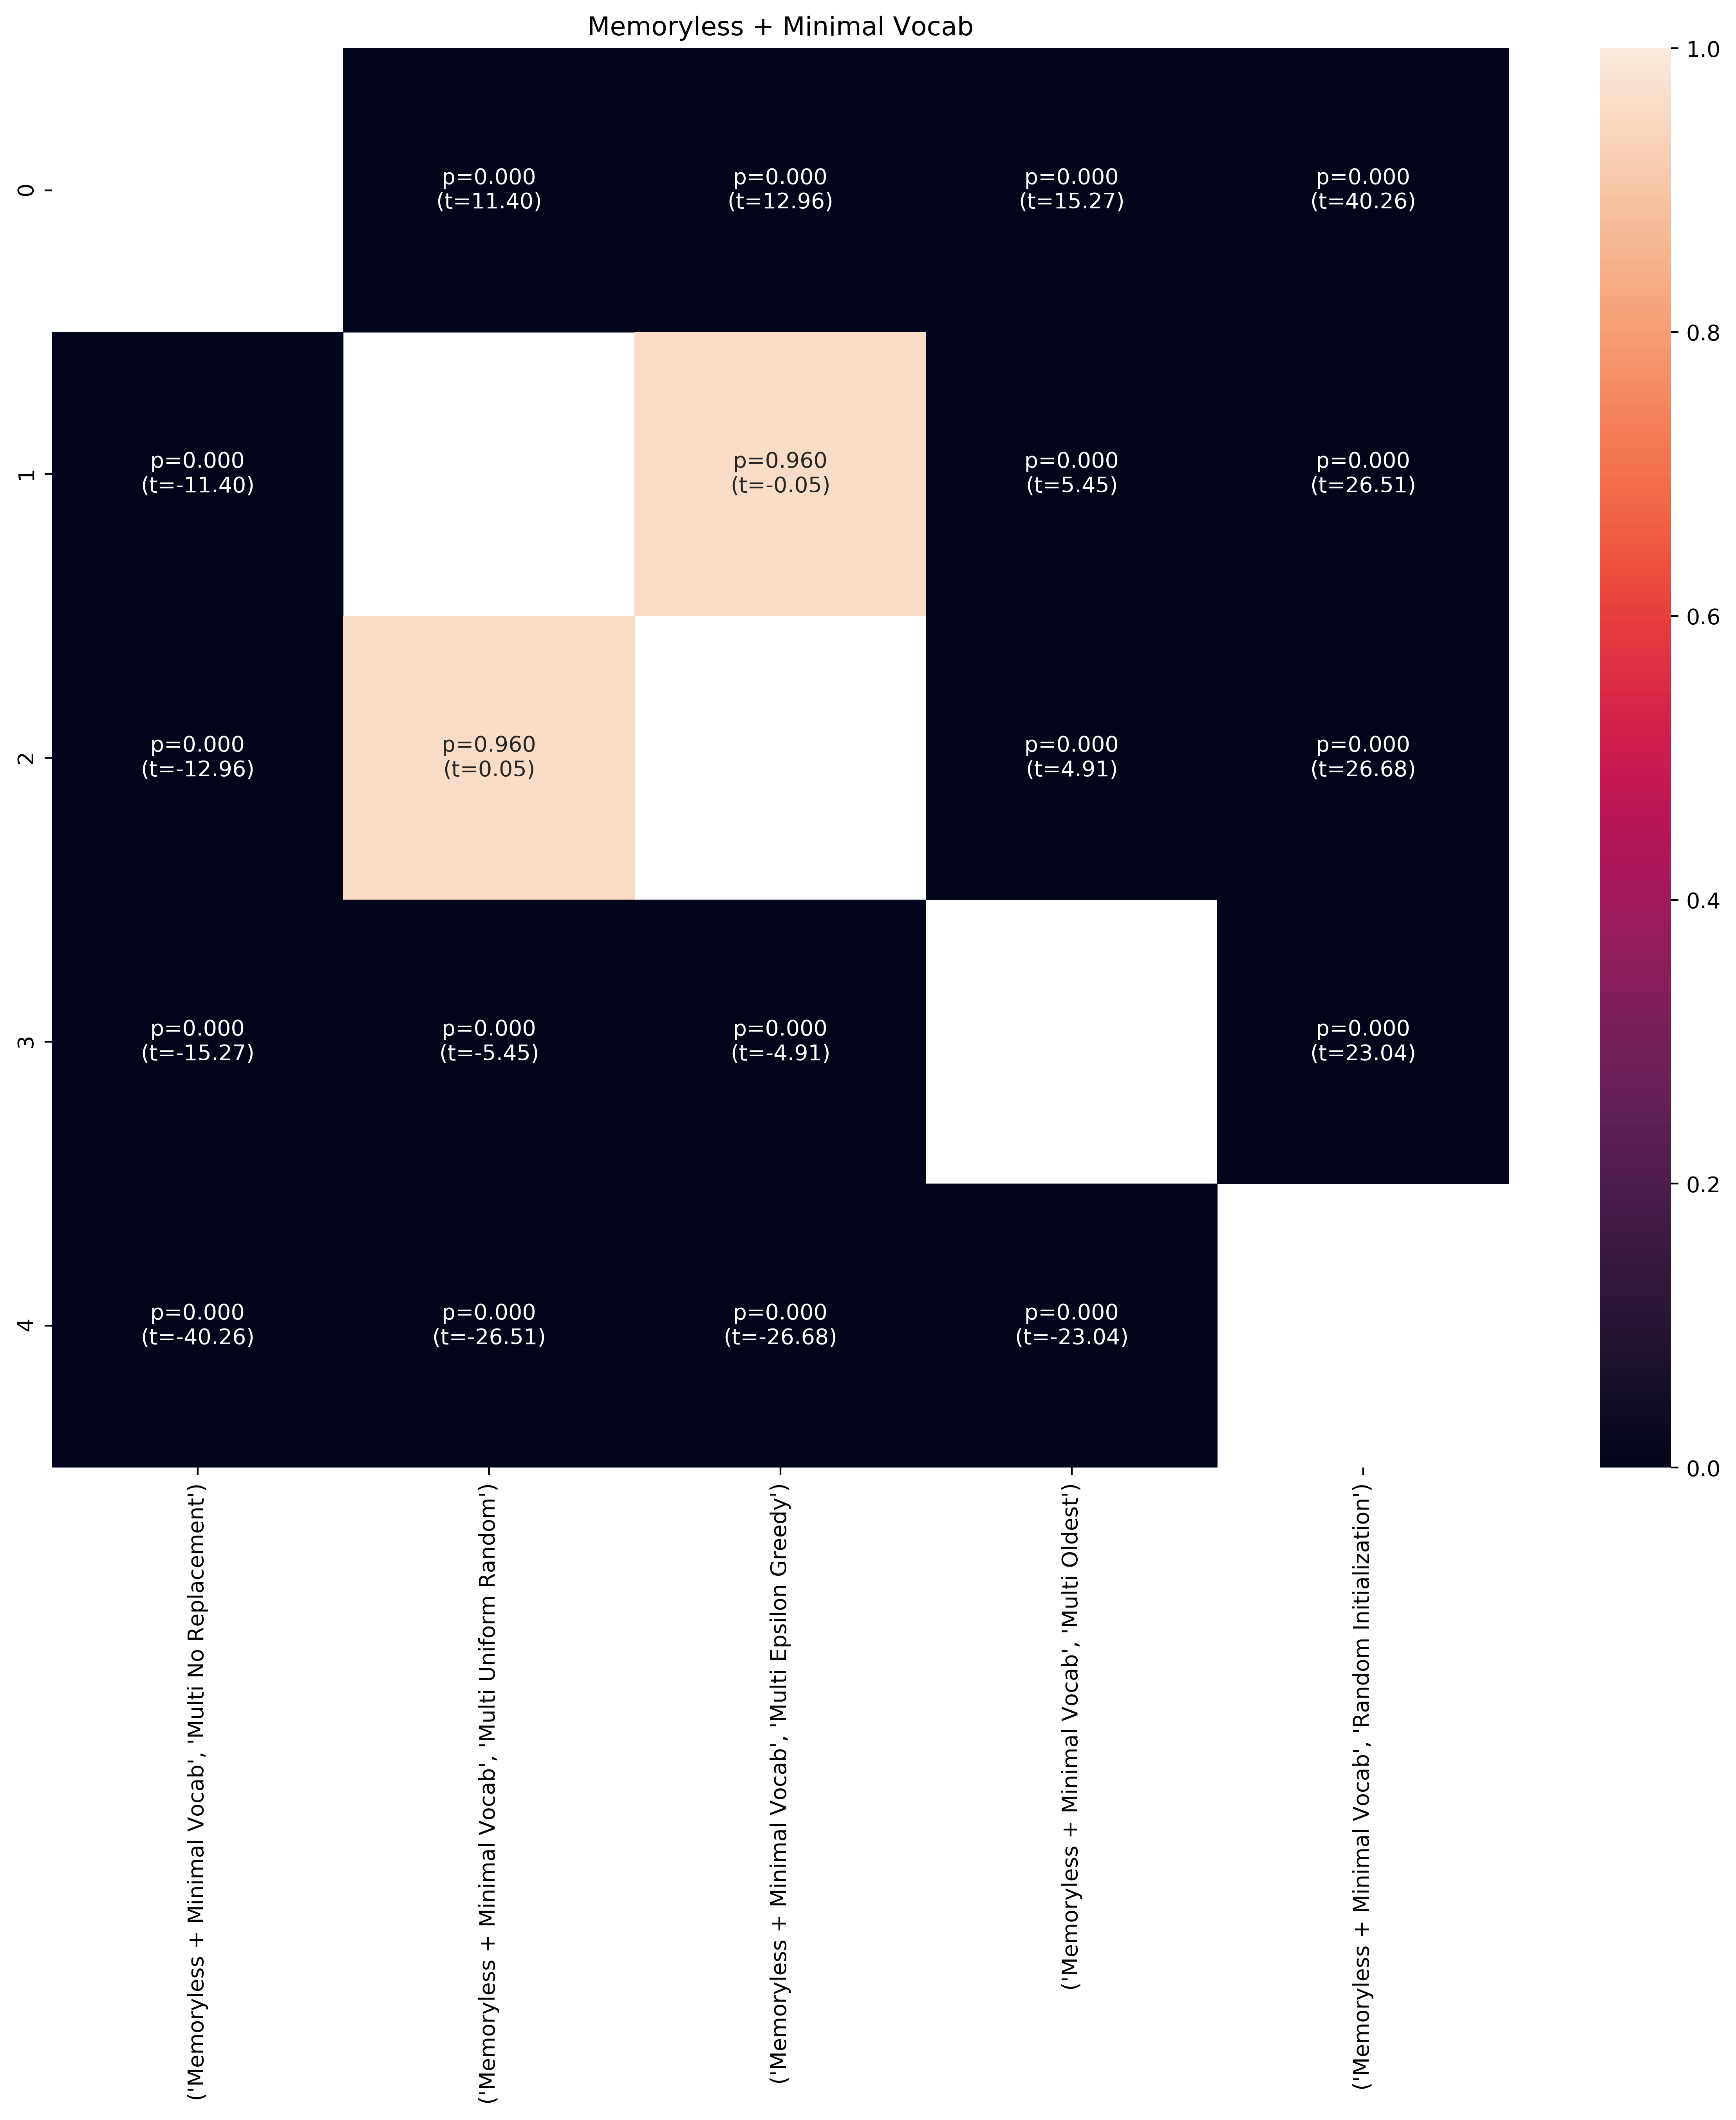

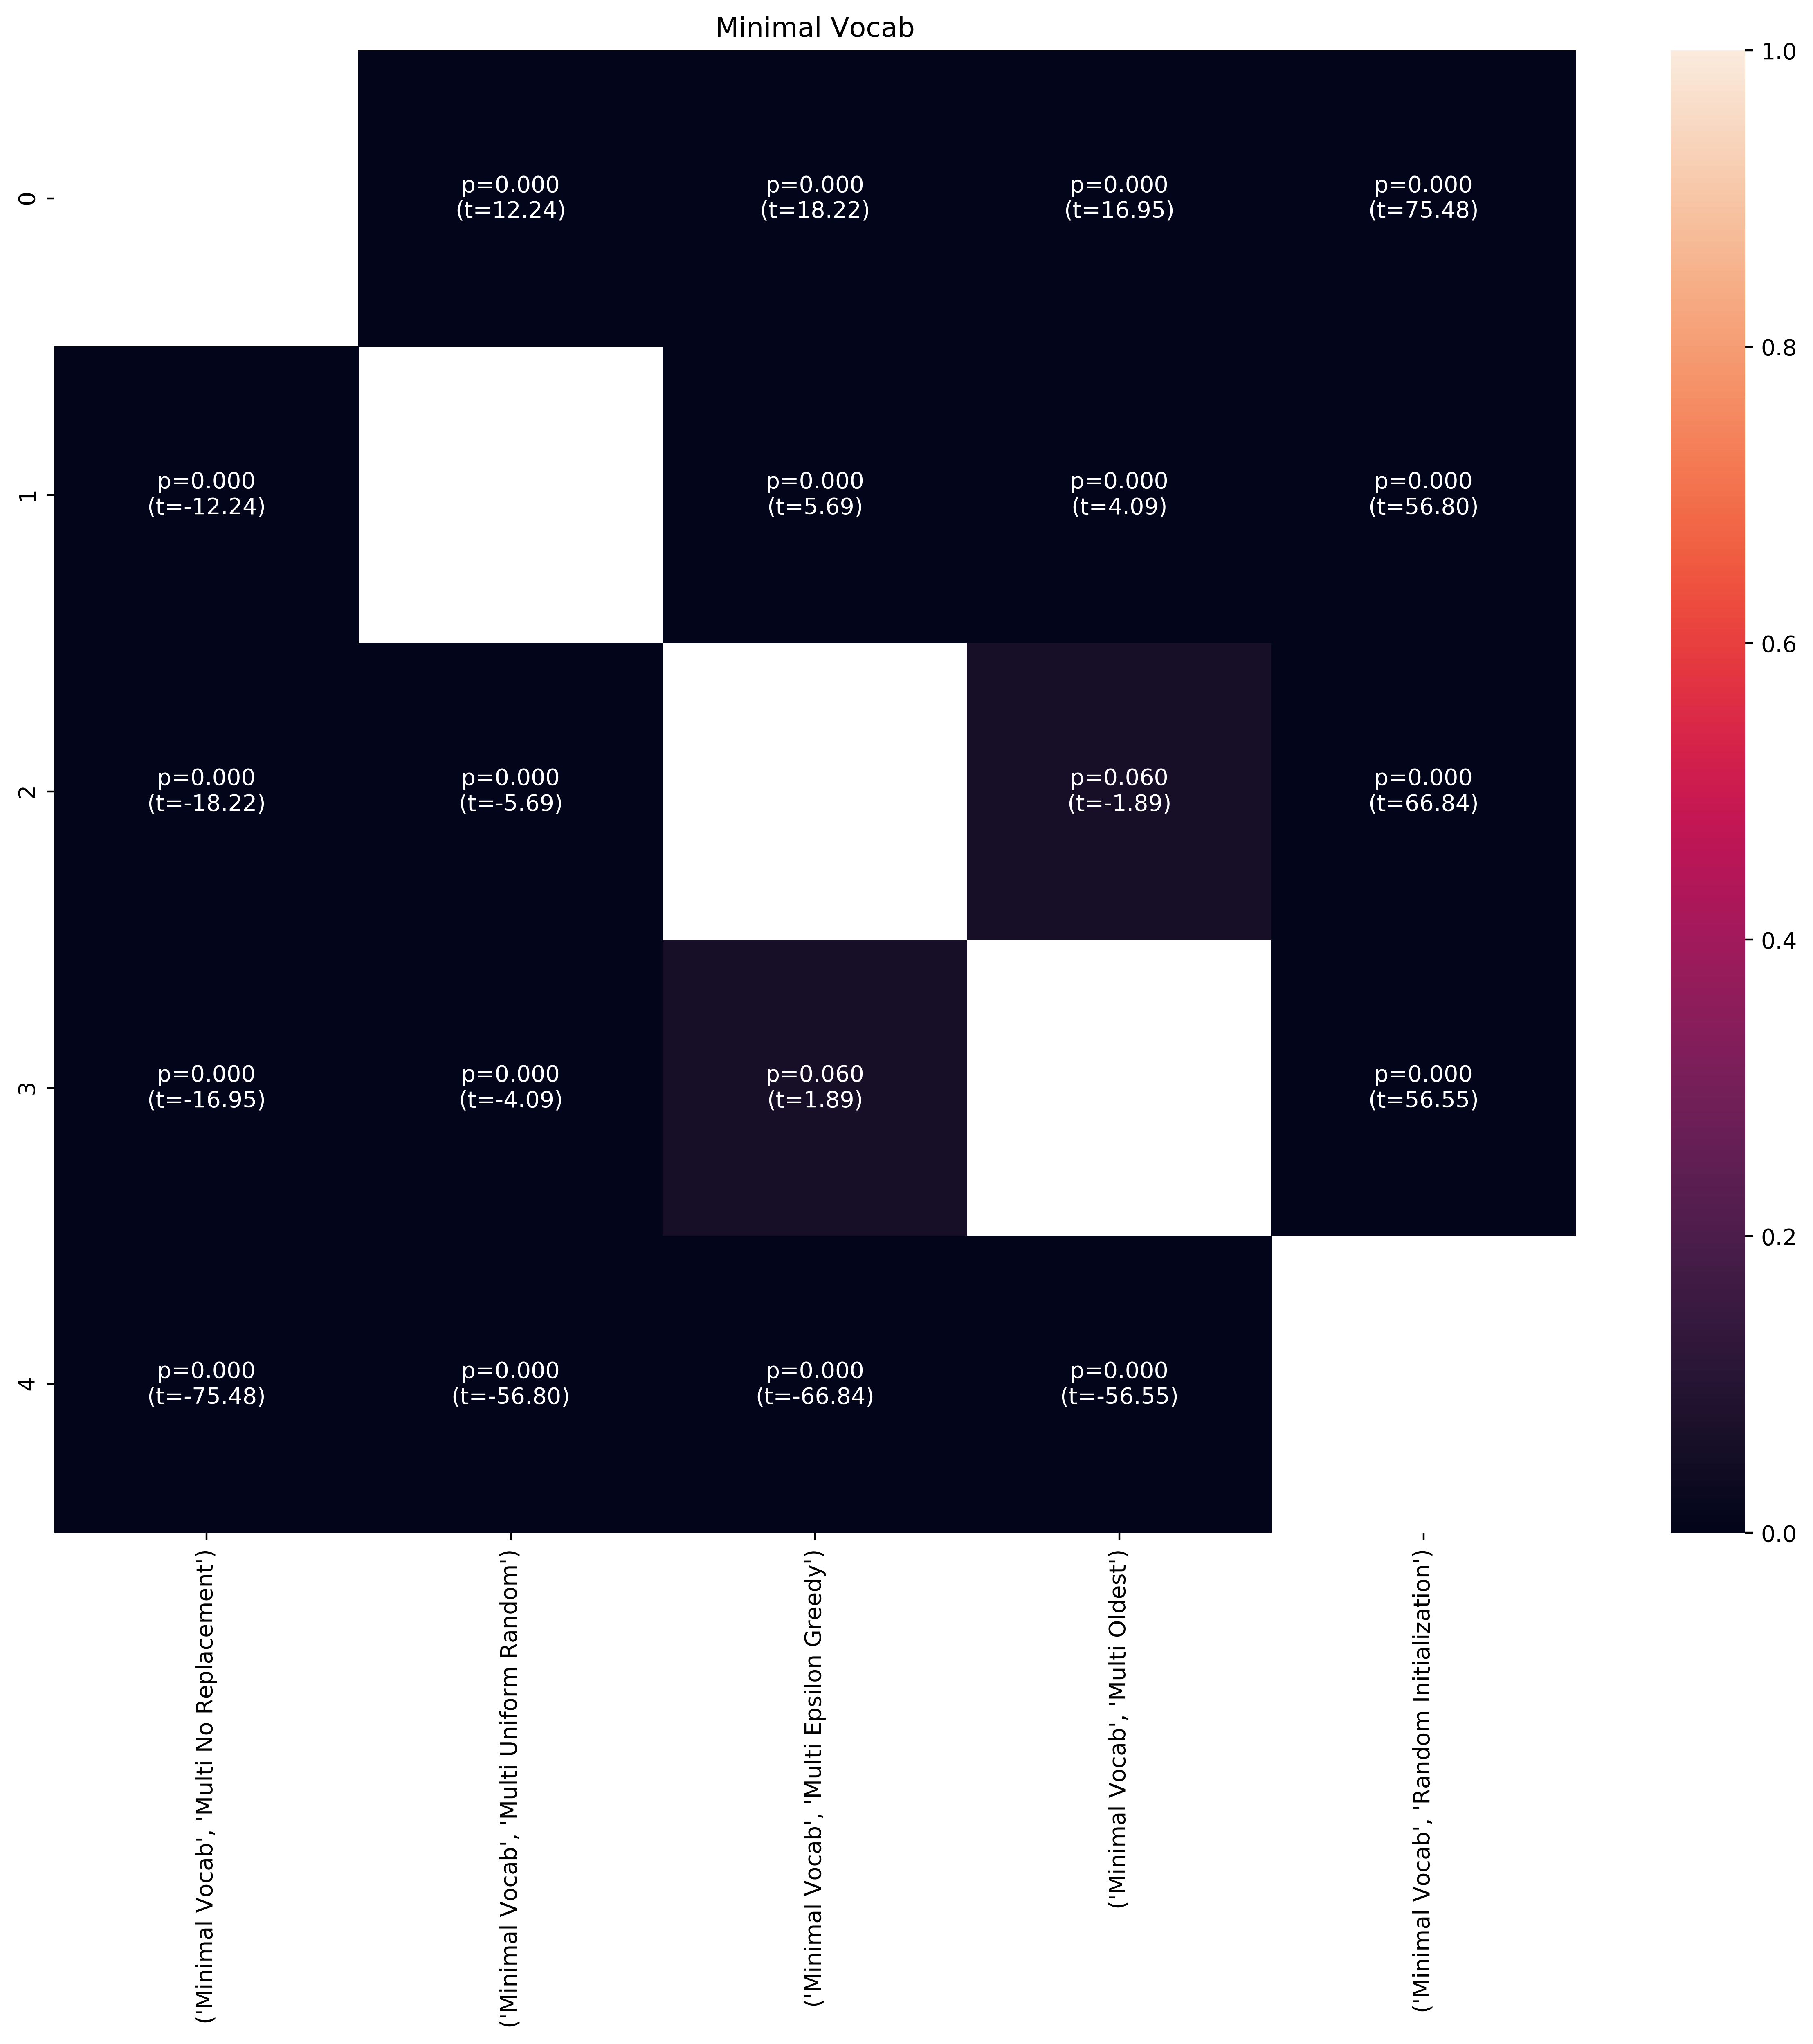

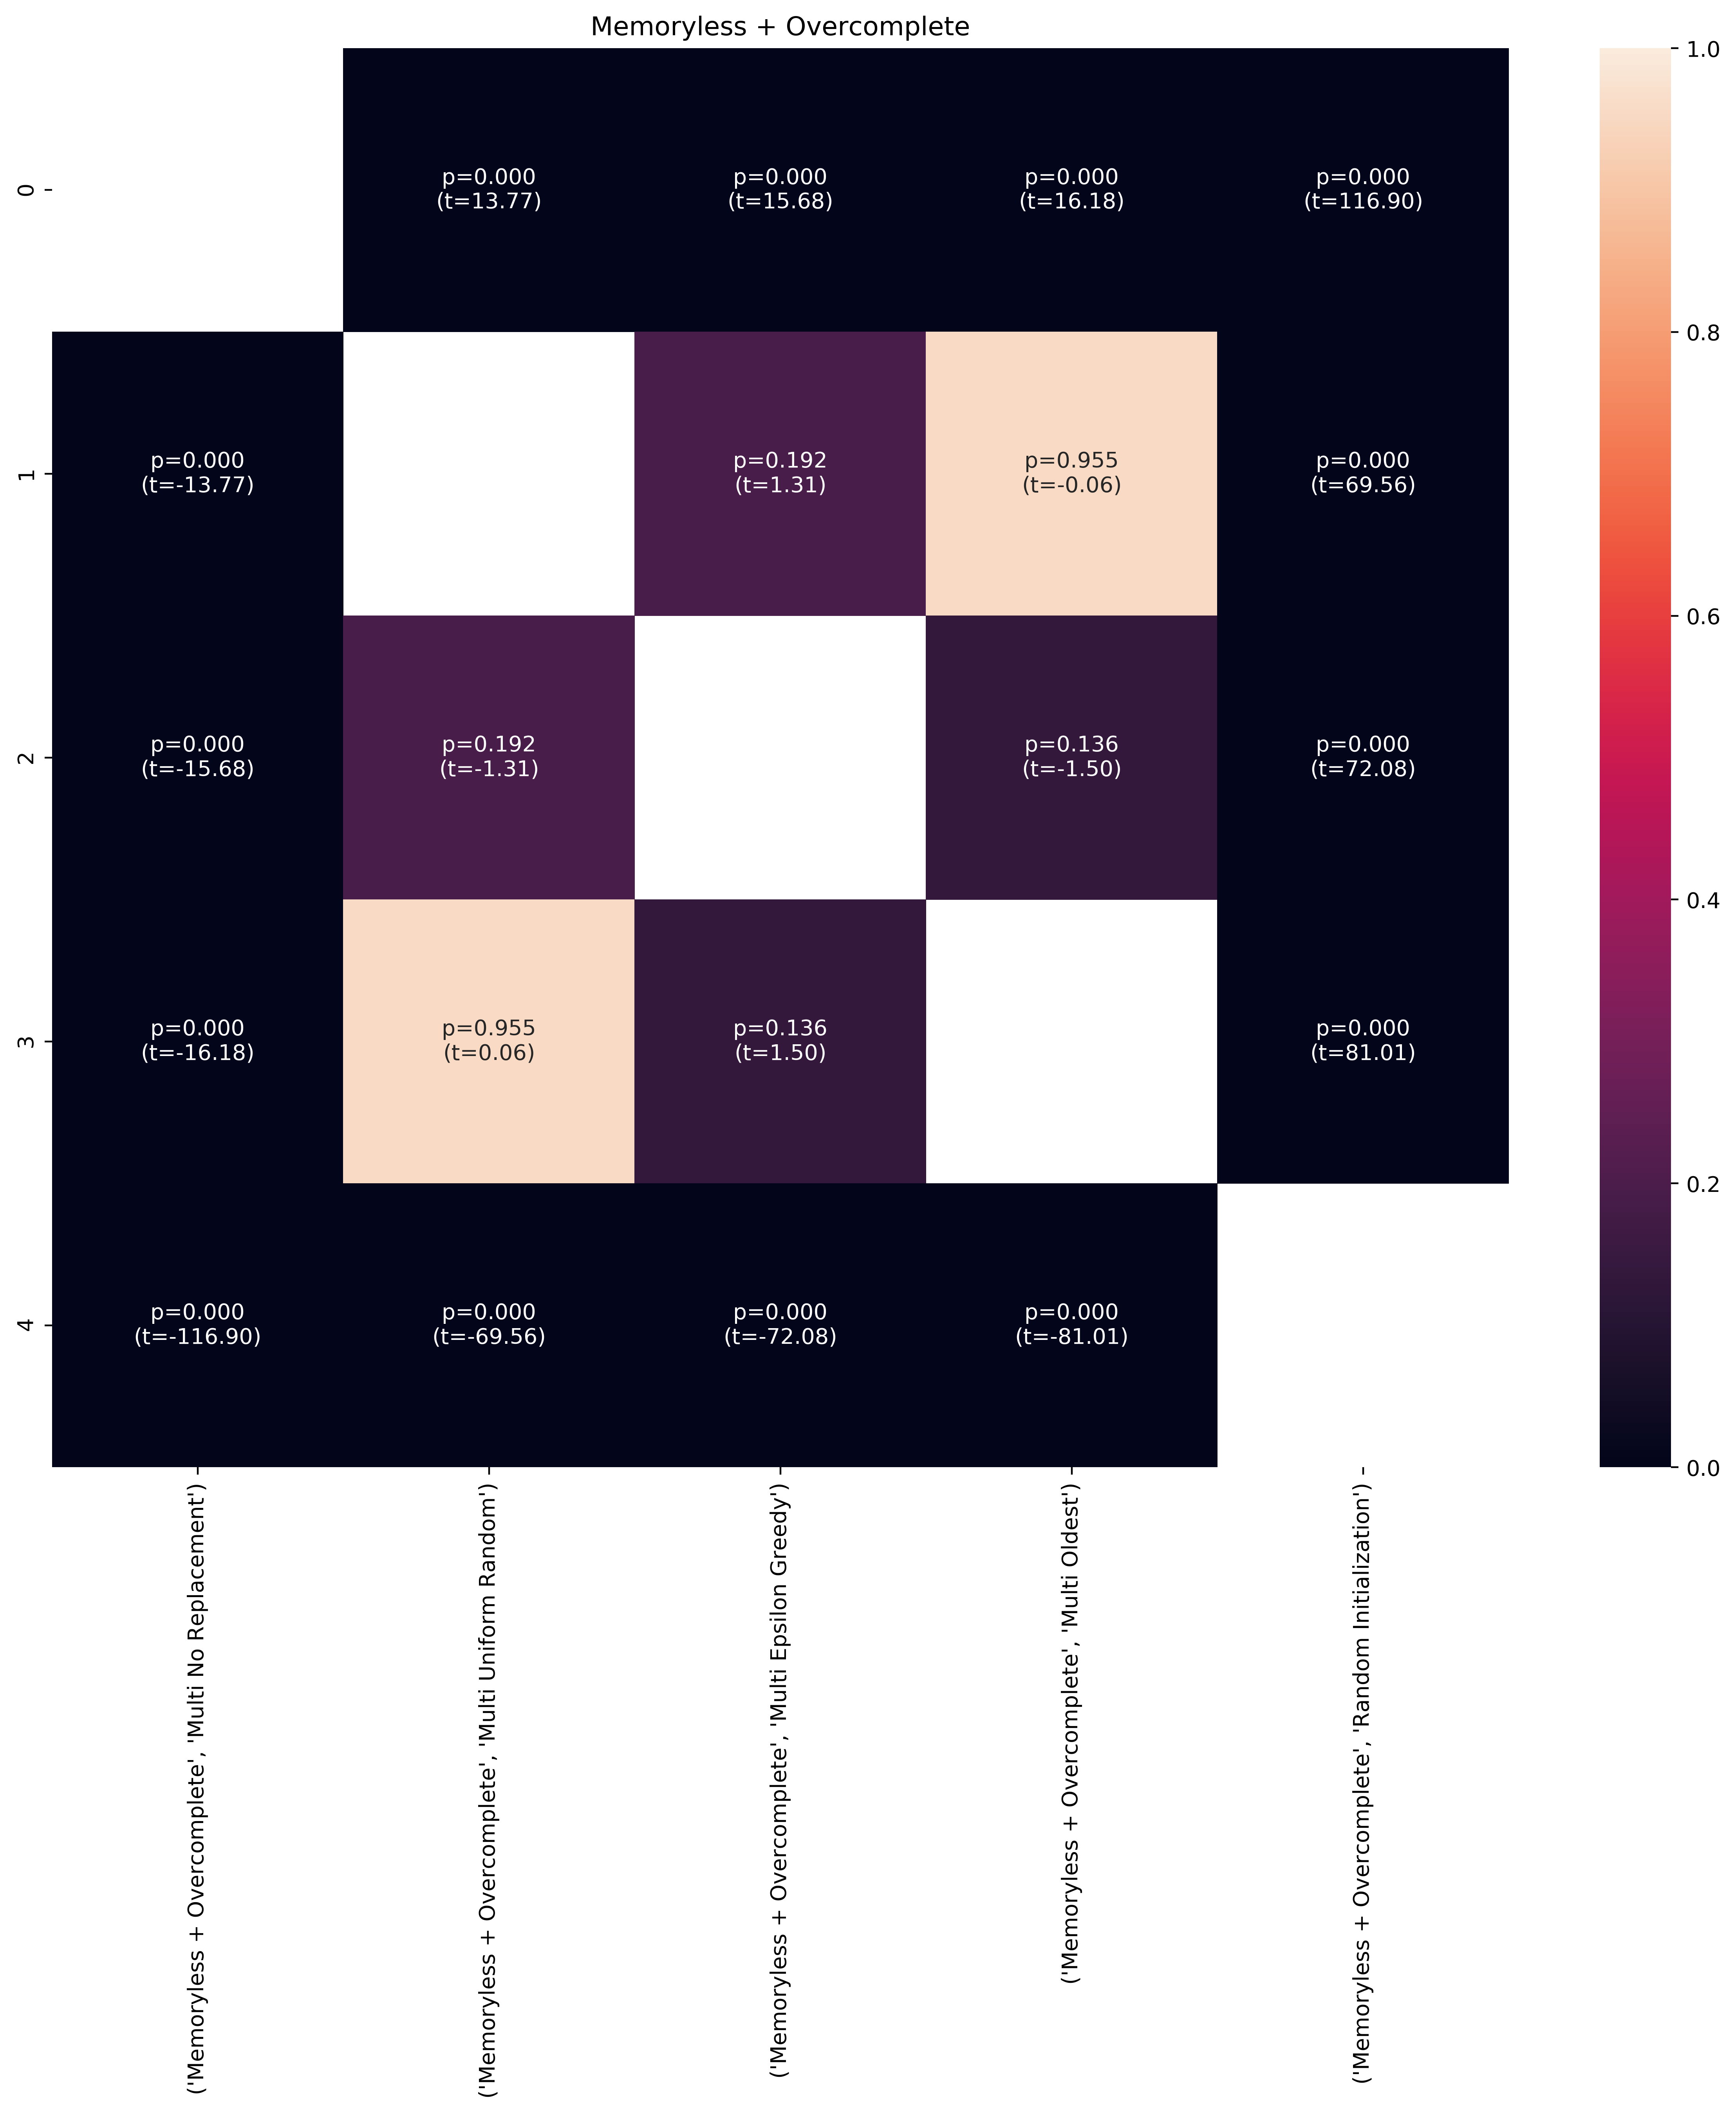

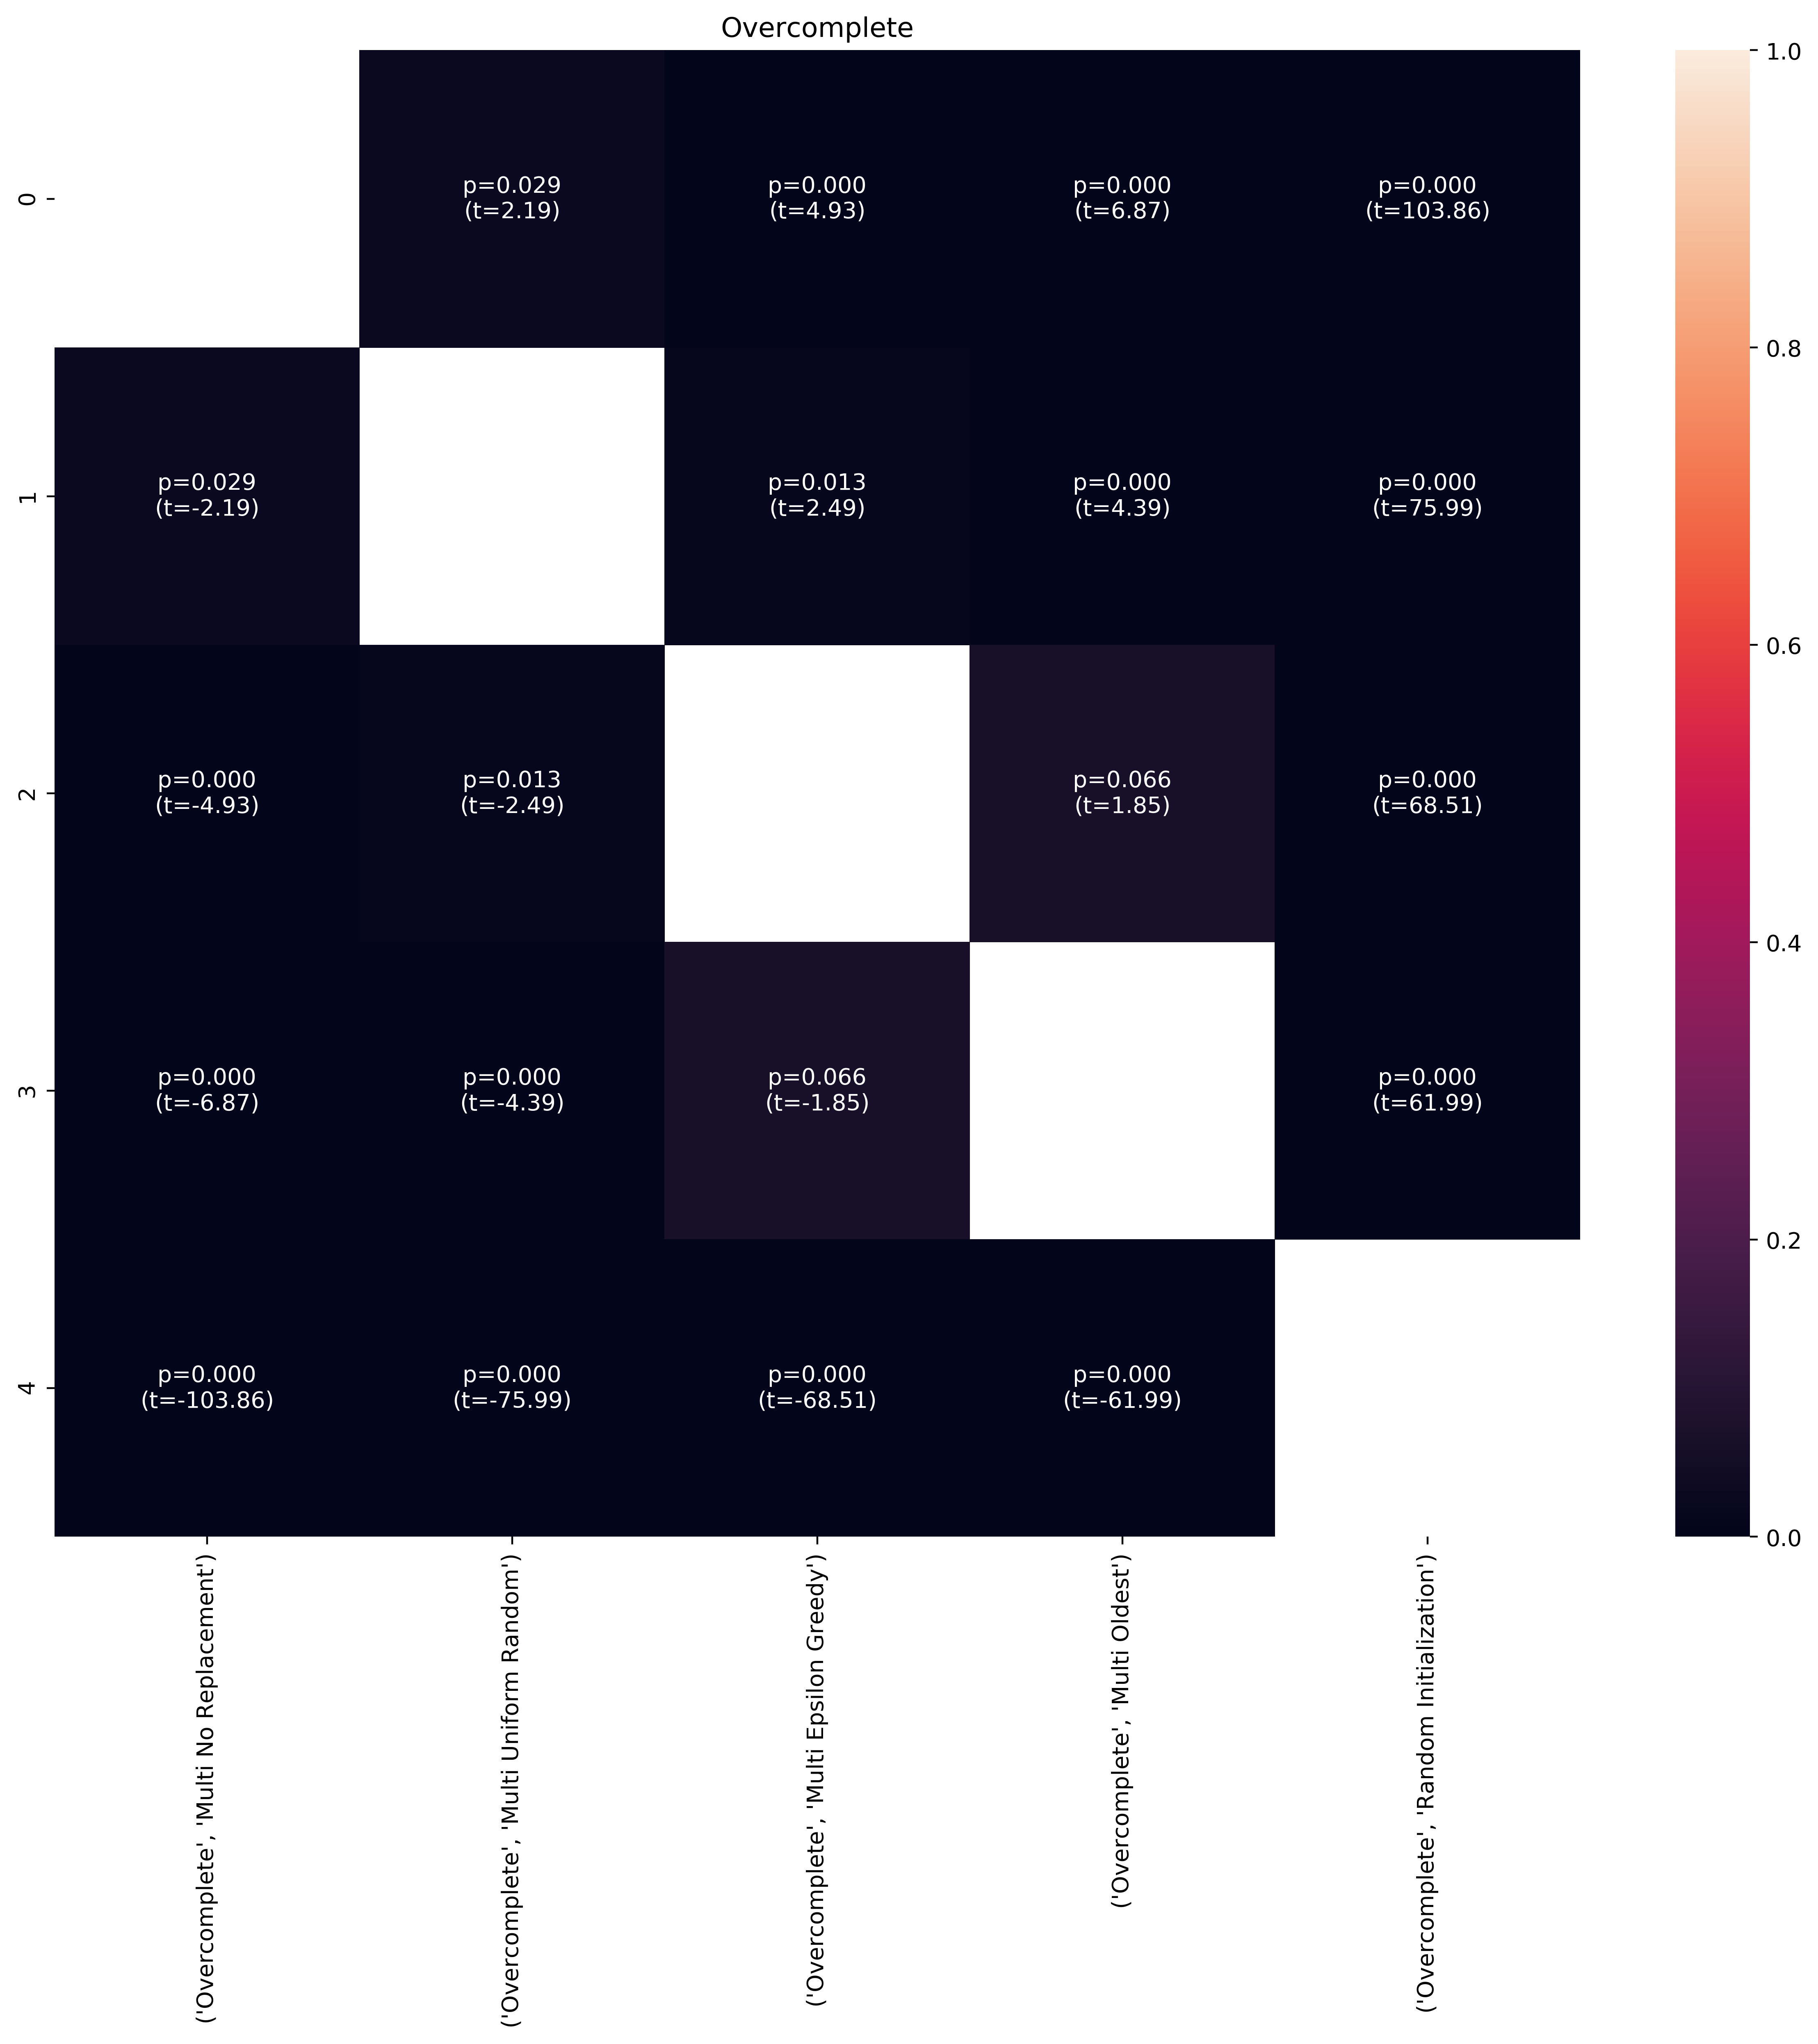

In [68]:
dname = 'data/figures/abot_dist_pvalues/by_model/'
os.makedirs(dname, exist_ok=True)
for i, model in enumerate(models):
    plt.figure(figsize=(15,12), dpi=400)
    plt.title(model)
    show_ttests('abot_dist', df_filter=lambda df: df[(df.model == model) & (df.method != 'Single Agents Combined')], threshold=False, show_t='both', df=lang_df)
    plt.savefig(pth.join(dname, 'abot_dist_ttest_' + model + '.png'), bbox_inches='tight')

### Language Entropies

This shows the entropy of a-bot languages, mostly for sanity check purposes.

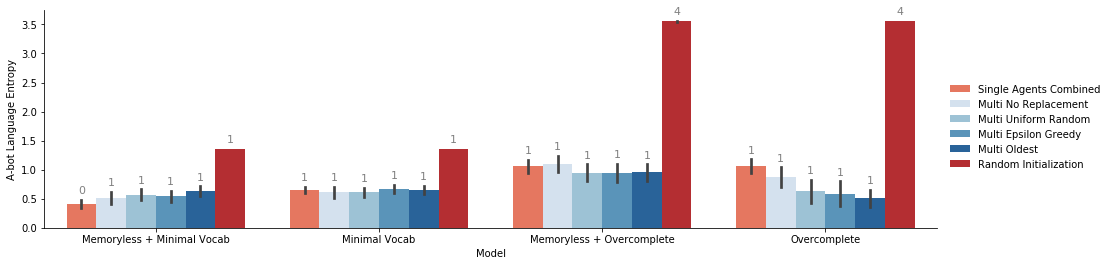

In [216]:
plt.figure(figsize=(16,4)) #, dpi=600)

ykey = 'abot_ent'
ax = sns.barplot(x='model', y=ykey, hue='method', data=lang_df, ci='sd',
           palette=pal, hue_order=methods, order=models)
plt.xlabel('Model')
plt.ylabel('A-bot Language Entropy')
#plt.legend(loc='upper right')

# hatches = ['/', '//', '+', '-', 'x', '\\', '*', 'o', 'O', '.']
# for i, bar in enumerate(ax.patches):
#     strat_i = i // 4 # just believe me
#     if strat_i < 3:
#         bar.set_hatch('-')
#     else:
#         bar.set_hatch('x')
#     #if strat_i in [0, 3]:
#     #    bar.set_facecolor((1, 1, 1, 0))

for i, p in enumerate(ax.patches):
    method_i = i // 4
    model_i = i % 4
    _df = lang_df[lang_df.method == methods[method_i]]
    _df = _df[_df.model == models[model_i]]
    std = _df[ykey].std()
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height() + std),
     ha='center', va='bottom', fontsize=11, color='gray', rotation=0, xytext=(0, 4),
     textcoords='offset points')

ax.legend(loc=(1.01,0.25), ncol=1, fancybox=False, shadow=False, frameon=False)
sns.despine()

## Language Visualization <a class="anchor" id="lang-vis"></a>

In [73]:
def render_lang_table(df, task, return_html=False):
    train_color = '#288E7A'
    val_color = '#8E7A28'
    test_color = '#7A288E'
    pd.options.display.max_colwidth = -1
    html = df.to_html(header=False, index=False)
    pd.options.display.max_colwidth = 90
    html = re.sub(r'train_(.*?)\\n', '<font>\g<1></font><br>', html)
    html = re.sub(r'val_(.*?)\\n', '<font><i>\g<1></i></font><br>', html)
    html = re.sub(r'test_(.*?)\\n', '<font><b>\g<1></b></font><br>', html)
    html = re.sub(r'\w+_css-(\w+)-(\w+)-([a-zA-Z]+)_', lambda match: svg_shape(match.group(1), match.group(2), match.group(3)), html)
    html = html.replace('</tbody>', '')
    html = html.replace('</table>', '')
    key_html = (f'<tr><td colspan="3"><b>Task:</b> ({task[0]}, {task[1]})</td>' +
                f'<td><div style="float: right;"><font>Train</font> ' +
                f'<font><i>Val<i></font> ' +
                f'<font><b>Test</b></font></td></tr></tbody></table>')
    #key_html = (f'<br><div><div style="float: left;"><b>Task:</b> ({task[0]}, {task[1]})</div>' +
    #            f'<div style="float: right;"><font color="{train_color}">Train</font> ' +
    #            f'<font color="{val_color}">Val</font> ' +
    #            f'<font color="{test_color}">Test</font></div></div>')
    if return_html:
        return html + key_html
    else:
        return display(HTML(html + key_html))

def ans_hist(ldf):
    df = pd.concat([ldf[['a1', 'split']].rename(index=str, columns={'a1': 'ans'}),
                    ldf[['a2', 'split']].rename(index=str, columns={'a2': 'ans'})])
    df = df.groupby(['ans', 'split'])['ans'].count()
    df = df.sort_values()
    df = df.unstack('split').fillna(0)
    return df.plot(kind='barh', stacked=True)

def agg(S):
    S = sorted(list(set(S)), key=lambda s: s.split('_')[1])
    if len(S) == 1:
        return S[0]
    #elif len(S) == 0:
    #    return np.nan
    else:
        return '\n'.join(S) + '\n'
        #return 'count {}'.format(len(S)) #raise Exception('to many words')

short_attributes = {
    'dotted': 'DO',
    'dashed': 'DA',
    'filled': 'FI',
    'solid': 'SO',
}

def show_lang(ldf, qboti=0, aboti=0, html=False, tasks=('shape', 'color', 'style')):
    #ldf = lang_analyzer.all_exp_ldf
    #ldf = ldf[ldf.exp == exp_code]
    ldf = ldf[ldf.qboti == qboti]
    ldf = ldf[ldf.aboti == aboti]
    assert set(tasks) == set(('shape', 'color', 'style'))
    # T3 just added for visualization
    T1, T2, T3 = tuple(t + 's' for t in tasks)
    # column names (instead of values for the task1/task columns)
    t1, t2, t3 = tuple(tasks)
    ldf = ldf[ldf.task1 == T1]
    ldf = ldf[ldf.task2 == T2]

    ldf['correct'] = (ldf[t1] == ldf['p1']) & (ldf[t2] == ldf['p2'])

                #ldf[t3].map(lambda s: short_attributes[s]) + '_' + \
    # the ldf[t3] is for sorting
    ldf['answer'] = (ldf['split'] + '_' + ldf[t3] + '_css-' +
                ldf['color'] + '-' + ldf['shape'] + '-' + ldf['style'] + '_' + \
                ldf.a1.map(lambda s: '{:0>1d}'.format(int(s[1:]) if s[0] == 'A' else int(s))) + ' ' +
                ldf.a2.map(lambda s: '{:0>1d}'.format(int(s[1:]) if s[0] == 'A' else int(s))) + ' ' +
                ldf['correct'].map(int).map(lambda c: '❌' if c == 0 else '✅'))
                #ldf.a2.map(lambda s: '{:0>2d}'.format(int(s[1:]) if s[0] == 'A' else int(s))) + '_' +
                #ldf['correct'].map(int).map(str))
    # emojis potentially used: ✔️, ❌, ✅

    df = pd.pivot_table(ldf, index=[t1], columns=[t2], values='answer', aggfunc=agg)
    #print(exp_code)
    if html:
        return render_lang_table(df, task=(t1, t2), return_html=True), ldf
    else:
        render_lang_table(df, task=(t1, t2))
    ans_hist(ldf)

In [74]:
def svg_shape(color, shape, style):
    if style == 'filled':
        attributes = ('fill="{color}" stroke="{color}"').format(color=color)
    elif style == 'solid':
        attributes = ('fill="transparent" stroke="{color}"').format(color=color)
    elif style == 'dashed':
        if shape == 'star':
            attributes = ('fill="transparent" stroke="{color}" '
                    'stroke-dasharray="50,40" ').format(color=color)
        else:
            attributes = ('fill="transparent" stroke="{color}" '
                    'stroke-dasharray="20,20" ').format(color=color)
    elif style == 'dotted':
        if shape == 'star':
            attributes = ('fill="transparent" stroke="{color}" '
                    'stroke-dasharray="20,20" ').format(color=color)
        else:
            attributes = ('fill="transparent" stroke="{color}" '
                    'stroke-dasharray="10,10" ').format(color=color)
    height, width = 20, 20
    if shape == 'star':
        return '''
<svg height="{height}" width="{width}" viewBox="200 40 300 320">
<polygon {attributes} stroke-width="15"
            points="350,75  379,161 469,161 397,215
                    423,301 350,250 277,301 303,215
                    231,161 321,161" />
</svg>
'''.format(attributes=attributes, height=height, width=width)
    elif shape == 'square':
        return '''
<svg height="{height}" width="{width}" viewBox="0 0 100 100">
<rect {attributes} stroke-width="6" x="10" y="10" width="80" height="80" />
</svg>
'''.format(attributes=attributes, height=height, width=width)
    elif shape == 'circle':
        return '''
<svg height="{height}" width="{width}" viewBox="0 0 100 100">
<circle {attributes} stroke-width="6" cx="50" cy="50" r="40" />
</svg>
'''.format(attributes=attributes, height=height, width=width)
    elif shape == 'triangle':
        return '''
<svg height="{height}" width="{width}" viewBox="0 0 100 100">
<polygon {attributes} stroke-width="6"
            points="10,90 50,10 90,90" />
</svg>
'''.format(attributes=attributes, height=height, width=width)
    else:
        raise Exception('unknown shape {}'.format(shape))

In [75]:
rec = lang_analysis.LanguageAnalyzer.exp_results_to_lang_records(
    {
        'exp7.1.10.0.0.0': load_many_epochs_exp('exp7.1.10.0.0.0', 'results_custom.json'),
        'exp7.1.0.0.0.0': load_many_epochs_exp('exp7.1.0.0.0.0', 'results_custom.json'),
        'exp7.1.1.0.0.0': load_many_epochs_exp('exp7.1.1.0.0.0', 'results_custom.json'),
        'exp7.0.10.0.0.0': load_many_epochs_exp('exp7.0.10.0.0.0', 'results_custom.json'),
        'exp7.0.0.0.0.0': load_many_epochs_exp('exp7.0.0.0.0.0', 'results_custom.json'),
        'exp7.0.1.0.0.0': load_many_epochs_exp('exp7.0.1.0.0.0', 'results_custom.json'),
    },
    ['train', 'val', 'test'])
adf = pd.DataFrame.from_records(rec,
                columns=lang_analysis.LanguageAnalyzer.lang_columns)
#adf['a1a2'] = adf.a1 + adf.a2
adf['nepoch'] = [int(e) if e != 'null' else -1 for e in adf.epoch]

In [71]:
#qi, ai = 0, 1
for qi in range(5):
    for ai in range(5):
        t1, ldf1 = show_lang(adf[(adf.exp == 'exp7.0.0.0.0.0') & (adf.nepoch == 3000)], qboti=qi, aboti=ai, html=True)
        t2, ldf2 = show_lang(adf[(adf.exp == 'exp7.0.10.0.0.0') & (adf.nepoch == 190000)], qboti=qi, aboti=ai, html=True)
        t3, ldf3 = show_lang(adf[(adf.exp == 'exp7.0.10.0.0.0') & (adf.nepoch == 190000)], qboti=qi, aboti=ai, html=True)
        print('{:.3f} {:.3f} {:.3f}'.format(ldf1.correct.mean(), ldf2.correct.mean(), ldf3.correct.mean()), end=' | ')
    print()

0.641 0.875 0.875 | nan 0.859 0.859 | 

KeyboardInterrupt: 

In [80]:
# note all these are at the same number of iterations from the last replacement
t1, ldf1 = show_lang(adf[(adf.exp == 'exp7.0.0.0.0.0') & (adf.nepoch == 3000)], qboti=0, aboti=0, html=True)
fname1 = 'single_agent_3000_q0_a0'
# young abots
t2, ldf2 = show_lang(adf[(adf.exp == 'exp7.0.10.0.0.0') & (adf.nepoch == 190000)], qboti=1, aboti=3, html=True)
fname2 = 'multi_oldest_190000_q4_a3'
# old abots
t3, ldf3 = show_lang(adf[(adf.exp == 'exp7.0.10.0.0.0') & (adf.nepoch == 190000)], qboti=1, aboti=2, html=True)
fname3 = 'multi_oldest_190000_q4_a2'

In [81]:
print(ldf1.q_age.unique(), ldf1.a_age.unique(), ldf1.correct.mean())
print(ldf2.q_age.unique(), ldf2.a_age.unique(), ldf2.correct.mean())
print(ldf3.q_age.unique(), ldf3.a_age.unique(), ldf3.correct.mean())

[0] [0] 0.640625
[115000] [15000] 0.8125
[115000] [65000] 0.796875


In [82]:
display(HTML('''
<style>
</style>
<table>
<tr>
<th>title 1</th>
<th>title 2</th>
<th>title 3</th>
</tr>
<tr>
<td>{}</td>
<td>{}</td>
<td>{}</td>
</tr>
</table>
'''.format(t1, t2, t3)))

In [90]:
for tab, fname in [(t1, fname1), (t2, fname2), (t3, fname3)]:
    html = '''
<html lang="en">
<head>
  <meta charset="utf-8">
  <style>
  table {{
  font-family: Arial, Helvetica, sans-serif;
  border-collapse: collapse;
  border-style: hidden;
  }}
  table td {{
    border: 2px solid black;
  }}
  </style>
</head>
<body>
<div>
{}
</div>
</body>
</html>
'''.format(tab)
    with open(fname + '.html', 'w') as f:
        f.write(html)

## Accuracy By Generation <a class="anchor" id="acc-gen"></a>

This section shows how accuracy changes over generations. It does this conditioned on a-bot generation then on q-bot generation.

In [99]:
# exp7 - comp dataset - main experiments
exp_name = lambda mi, ti, di, fi, si, **k: 'exp7.{}.{}.{}.{}.{}'.format(mi, ti, di, fi, si)
models = [(0, 'Memoryless + Minimal Vocab'),
          ('2', 'Minimal Vocab'),
          (1, 'Overcomplete'),
          ('3', 'Memoryless + Overcomplete'),
         ]
training = [(0, 'Single No Replacement'),
            (5, 'Single Random'),
            (6, 'Single Oldest'),
            (1, 'Multi No Replacement'),
            (11, 'Multi Uniform Random'),
            (12, 'Multi Epsilon Greedy'),
            (10, 'Multi Oldest'),
           ]
datasets = [(0, 'comp_cv')]
teaching = [(1, 'task-1 teach-1')]
folds = [(0, 0), (1, 1), (2, 2), (3, 3)]
seeds = [(0, 0), (1, 1), (2, 2), (3, 3)]

add_fresh_experiment(fixed_epoch=True)
show_records(['dataset', 'model', 'method', 'nqbots'])

ERROR:root:File `'this.py'` not found.


In [78]:
# load the cross-generational data
add_fresh_experiment_gen(fixed_epoch=True)

fresh gen
fixed epoch, using results_gen_39000.json
skipping exp7.0.0.0.0.0 (could not find data/experiments/exp7.0.0.0.0.0/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.0.0.0.0.1 (could not find data/experiments/exp7.0.0.0.0.1/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.0.0.0.0.2 (could not find data/experiments/exp7.0.0.0.0.2/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.0.0.0.0.3 (could not find data/experiments/exp7.0.0.0.0.3/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.0.0.0.1.0 (could not find data/experiments/exp7.0.0.0.1.0/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.0.0.0.1.1 (could not find data/experiments/exp7.0.0.0.1.1/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.0.0.0.1.2 (could not find data/experiments/exp7.0.0.0.1.2/models

added exp7.0.1.0.1.1 (ep=24000)
added exp7.0.1.0.1.1 (ep=49000)
added exp7.0.1.0.1.1 (ep=74000)
added exp7.0.1.0.1.1 (ep=99000)
added exp7.0.1.0.1.1 (ep=124000)
added exp7.0.1.0.1.1 (ep=149000)
added exp7.0.1.0.1.1 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.0.1.0.1.2 (ep=24000)
added exp7.0.1.0.1.2 (ep=49000)
added exp7.0.1.0.1.2 (ep=74000)
added exp7.0.1.0.1.2 (ep=99000)
added exp7.0.1.0.1.2 (ep=124000)
added exp7.0.1.0.1.2 (ep=149000)
added exp7.0.1.0.1.2 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.0.1.0.1.3 (ep=24000)
added exp7.0.1.0.1.3 (ep=49000)
added exp7.0.1.0.1.3 (ep=74000)
added exp7.0.1.0.1.3 (ep=99000)
added exp7.0.1.0.1.3 (ep=124000)
added exp7.0.1.0.1.3 (ep=149000)
added exp7.0.1.0.1.3 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.0.1.0.2.0 (ep=24000)
added exp7.0.1.0.2.0 (ep=49000)
added exp7.0.1.0.2.0 (ep=74000)
added exp7.0.1.0.2.0 (ep=99000)
added exp7.0.1.0.2.0 (ep=124000)
added exp7.0.1.0.2.0 (ep=1490

added exp7.0.12.0.0.3 (ep=24000)
added exp7.0.12.0.0.3 (ep=49000)
added exp7.0.12.0.0.3 (ep=74000)
added exp7.0.12.0.0.3 (ep=99000)
added exp7.0.12.0.0.3 (ep=124000)
added exp7.0.12.0.0.3 (ep=149000)
added exp7.0.12.0.0.3 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.0.12.0.1.0 (ep=24000)
added exp7.0.12.0.1.0 (ep=49000)
added exp7.0.12.0.1.0 (ep=74000)
added exp7.0.12.0.1.0 (ep=99000)
added exp7.0.12.0.1.0 (ep=124000)
added exp7.0.12.0.1.0 (ep=149000)
added exp7.0.12.0.1.0 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.0.12.0.1.1 (ep=24000)
added exp7.0.12.0.1.1 (ep=49000)
added exp7.0.12.0.1.1 (ep=74000)
added exp7.0.12.0.1.1 (ep=99000)
added exp7.0.12.0.1.1 (ep=124000)
added exp7.0.12.0.1.1 (ep=149000)
added exp7.0.12.0.1.1 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.0.12.0.1.2 (ep=24000)
added exp7.0.12.0.1.2 (ep=49000)
added exp7.0.12.0.1.2 (ep=74000)
added exp7.0.12.0.1.2 (ep=99000)
added exp7.0.12.0.1.2 (ep=124000)
add

skipping exp7.2.0.0.1.2 (could not find data/experiments/exp7.2.0.0.1.2/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.2.0.0.1.3 (could not find data/experiments/exp7.2.0.0.1.3/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.2.0.0.2.0 (could not find data/experiments/exp7.2.0.0.2.0/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.2.0.0.2.1 (could not find data/experiments/exp7.2.0.0.2.1/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.2.0.0.2.2 (could not find data/experiments/exp7.2.0.0.2.2/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.2.0.0.2.3 (could not find data/experiments/exp7.2.0.0.2.3/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.2.0.0.3.0 (could not find data/experiments/exp7.2.0.0.3.0/models/results_gen_39000.json)
fixed epoch, using results_

added exp7.2.1.0.2.0 (ep=24000)
added exp7.2.1.0.2.0 (ep=49000)
added exp7.2.1.0.2.0 (ep=74000)
added exp7.2.1.0.2.0 (ep=99000)
added exp7.2.1.0.2.0 (ep=124000)
added exp7.2.1.0.2.0 (ep=149000)
added exp7.2.1.0.2.0 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.2.1.0.2.1 (ep=24000)
added exp7.2.1.0.2.1 (ep=49000)
added exp7.2.1.0.2.1 (ep=74000)
added exp7.2.1.0.2.1 (ep=99000)
added exp7.2.1.0.2.1 (ep=124000)
added exp7.2.1.0.2.1 (ep=149000)
added exp7.2.1.0.2.1 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.2.1.0.2.2 (ep=24000)
added exp7.2.1.0.2.2 (ep=49000)
added exp7.2.1.0.2.2 (ep=74000)
added exp7.2.1.0.2.2 (ep=99000)
added exp7.2.1.0.2.2 (ep=124000)
added exp7.2.1.0.2.2 (ep=149000)
added exp7.2.1.0.2.2 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.2.1.0.2.3 (ep=24000)
added exp7.2.1.0.2.3 (ep=49000)
added exp7.2.1.0.2.3 (ep=74000)
added exp7.2.1.0.2.3 (ep=99000)
added exp7.2.1.0.2.3 (ep=124000)
added exp7.2.1.0.2.3 (ep=1490

added exp7.2.12.0.1.2 (ep=24000)
added exp7.2.12.0.1.2 (ep=49000)
added exp7.2.12.0.1.2 (ep=74000)
added exp7.2.12.0.1.2 (ep=99000)
added exp7.2.12.0.1.2 (ep=124000)
added exp7.2.12.0.1.2 (ep=149000)
added exp7.2.12.0.1.2 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.2.12.0.1.3 (ep=24000)
added exp7.2.12.0.1.3 (ep=49000)
added exp7.2.12.0.1.3 (ep=74000)
added exp7.2.12.0.1.3 (ep=99000)
added exp7.2.12.0.1.3 (ep=124000)
added exp7.2.12.0.1.3 (ep=149000)
added exp7.2.12.0.1.3 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.2.12.0.2.0 (ep=24000)
added exp7.2.12.0.2.0 (ep=49000)
added exp7.2.12.0.2.0 (ep=74000)
added exp7.2.12.0.2.0 (ep=99000)
added exp7.2.12.0.2.0 (ep=124000)
added exp7.2.12.0.2.0 (ep=149000)
added exp7.2.12.0.2.0 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.2.12.0.2.1 (ep=24000)
added exp7.2.12.0.2.1 (ep=49000)
added exp7.2.12.0.2.1 (ep=74000)
added exp7.2.12.0.2.1 (ep=99000)
added exp7.2.12.0.2.1 (ep=124000)
add

skipping exp7.1.0.0.1.3 (could not find data/experiments/exp7.1.0.0.1.3/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.1.0.0.2.0 (could not find data/experiments/exp7.1.0.0.2.0/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.1.0.0.2.1 (could not find data/experiments/exp7.1.0.0.2.1/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.1.0.0.2.2 (could not find data/experiments/exp7.1.0.0.2.2/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.1.0.0.2.3 (could not find data/experiments/exp7.1.0.0.2.3/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.1.0.0.3.0 (could not find data/experiments/exp7.1.0.0.3.0/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.1.0.0.3.1 (could not find data/experiments/exp7.1.0.0.3.1/models/results_gen_39000.json)
fixed epoch, using results_

added exp7.1.1.0.2.1 (ep=24000)
added exp7.1.1.0.2.1 (ep=49000)
added exp7.1.1.0.2.1 (ep=74000)
added exp7.1.1.0.2.1 (ep=99000)
added exp7.1.1.0.2.1 (ep=124000)
added exp7.1.1.0.2.1 (ep=149000)
added exp7.1.1.0.2.1 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.1.1.0.2.2 (ep=24000)
added exp7.1.1.0.2.2 (ep=49000)
added exp7.1.1.0.2.2 (ep=74000)
added exp7.1.1.0.2.2 (ep=99000)
added exp7.1.1.0.2.2 (ep=124000)
added exp7.1.1.0.2.2 (ep=149000)
added exp7.1.1.0.2.2 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.1.1.0.2.3 (ep=24000)
added exp7.1.1.0.2.3 (ep=49000)
added exp7.1.1.0.2.3 (ep=74000)
added exp7.1.1.0.2.3 (ep=99000)
added exp7.1.1.0.2.3 (ep=124000)
added exp7.1.1.0.2.3 (ep=149000)
added exp7.1.1.0.2.3 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.1.1.0.3.0 (ep=24000)
added exp7.1.1.0.3.0 (ep=49000)
added exp7.1.1.0.3.0 (ep=74000)
added exp7.1.1.0.3.0 (ep=99000)
added exp7.1.1.0.3.0 (ep=124000)
added exp7.1.1.0.3.0 (ep=1490

added exp7.1.12.0.1.3 (ep=24000)
added exp7.1.12.0.1.3 (ep=49000)
added exp7.1.12.0.1.3 (ep=74000)
added exp7.1.12.0.1.3 (ep=99000)
added exp7.1.12.0.1.3 (ep=124000)
added exp7.1.12.0.1.3 (ep=149000)
added exp7.1.12.0.1.3 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.1.12.0.2.0 (ep=24000)
added exp7.1.12.0.2.0 (ep=49000)
added exp7.1.12.0.2.0 (ep=74000)
added exp7.1.12.0.2.0 (ep=99000)
added exp7.1.12.0.2.0 (ep=124000)
added exp7.1.12.0.2.0 (ep=149000)
added exp7.1.12.0.2.0 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.1.12.0.2.1 (ep=24000)
added exp7.1.12.0.2.1 (ep=49000)
added exp7.1.12.0.2.1 (ep=74000)
added exp7.1.12.0.2.1 (ep=99000)
added exp7.1.12.0.2.1 (ep=124000)
added exp7.1.12.0.2.1 (ep=149000)
added exp7.1.12.0.2.1 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.1.12.0.2.2 (ep=24000)
added exp7.1.12.0.2.2 (ep=49000)
added exp7.1.12.0.2.2 (ep=74000)
added exp7.1.12.0.2.2 (ep=99000)
added exp7.1.12.0.2.2 (ep=124000)
add

skipping exp7.3.5.0.0.0 (could not find data/experiments/exp7.3.5.0.0.0/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.3.5.0.0.1 (could not find data/experiments/exp7.3.5.0.0.1/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.3.5.0.0.2 (could not find data/experiments/exp7.3.5.0.0.2/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.3.5.0.0.3 (could not find data/experiments/exp7.3.5.0.0.3/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.3.5.0.1.0 (could not find data/experiments/exp7.3.5.0.1.0/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.3.5.0.1.1 (could not find data/experiments/exp7.3.5.0.1.1/models/results_gen_39000.json)
fixed epoch, using results_gen_39000.json
skipping exp7.3.5.0.1.2 (could not find data/experiments/exp7.3.5.0.1.2/models/results_gen_39000.json)
fixed epoch, using results_

added exp7.3.1.0.3.2 (ep=24000)
added exp7.3.1.0.3.2 (ep=49000)
added exp7.3.1.0.3.2 (ep=74000)
added exp7.3.1.0.3.2 (ep=99000)
added exp7.3.1.0.3.2 (ep=124000)
added exp7.3.1.0.3.2 (ep=149000)
added exp7.3.1.0.3.2 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.3.1.0.3.3 (ep=24000)
added exp7.3.1.0.3.3 (ep=49000)
added exp7.3.1.0.3.3 (ep=74000)
added exp7.3.1.0.3.3 (ep=99000)
added exp7.3.1.0.3.3 (ep=124000)
added exp7.3.1.0.3.3 (ep=149000)
added exp7.3.1.0.3.3 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.3.11.0.0.0 (ep=24000)
added exp7.3.11.0.0.0 (ep=49000)
added exp7.3.11.0.0.0 (ep=74000)
added exp7.3.11.0.0.0 (ep=99000)
added exp7.3.11.0.0.0 (ep=124000)
added exp7.3.11.0.0.0 (ep=149000)
added exp7.3.11.0.0.0 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.3.11.0.0.1 (ep=24000)
added exp7.3.11.0.0.1 (ep=49000)
added exp7.3.11.0.0.1 (ep=74000)
added exp7.3.11.0.0.1 (ep=99000)
added exp7.3.11.0.0.1 (ep=124000)
added exp7.3.11.0

added exp7.3.12.0.3.0 (ep=24000)
added exp7.3.12.0.3.0 (ep=49000)
added exp7.3.12.0.3.0 (ep=74000)
added exp7.3.12.0.3.0 (ep=99000)
added exp7.3.12.0.3.0 (ep=124000)
added exp7.3.12.0.3.0 (ep=149000)
added exp7.3.12.0.3.0 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.3.12.0.3.1 (ep=24000)
added exp7.3.12.0.3.1 (ep=49000)
added exp7.3.12.0.3.1 (ep=74000)
added exp7.3.12.0.3.1 (ep=99000)
added exp7.3.12.0.3.1 (ep=124000)
added exp7.3.12.0.3.1 (ep=149000)
added exp7.3.12.0.3.1 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.3.12.0.3.2 (ep=24000)
added exp7.3.12.0.3.2 (ep=49000)
added exp7.3.12.0.3.2 (ep=74000)
added exp7.3.12.0.3.2 (ep=99000)
added exp7.3.12.0.3.2 (ep=124000)
added exp7.3.12.0.3.2 (ep=149000)
added exp7.3.12.0.3.2 (ep=174000)
fixed epoch, using results_gen_199000.json
added exp7.3.12.0.3.3 (ep=24000)
added exp7.3.12.0.3.3 (ep=49000)
added exp7.3.12.0.3.3 (ep=74000)
added exp7.3.12.0.3.3 (ep=99000)
added exp7.3.12.0.3.3 (ep=124000)
add

In [79]:
dfg = pd.DataFrame.from_records(records_gen, columns=columns_gen)

In [82]:
dfg

model                method  dataset  fold  seed  \
0      Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
1      Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
2      Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
3      Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
4      Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
5      Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
6      Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
7      Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
8      Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
9      Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
10     Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
11     Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
12     Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
13     Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
14     Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
15     Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
16     Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
17     Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
18     Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
19     Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
20     Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
21     Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
22     Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
23     Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
24     Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
25     Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
26     Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
27     Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
28     Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
29     Memoryless + Minimal Vocab  Multi No Replacement  comp_cv     0     0   
...                           ...                   ...      ...   ...   ...   
44770   Memoryless + Overcomplete          Multi Oldest  comp_cv     3     3   
44771   Memoryless + Overcomplete          Multi Oldest  comp_cv     3     3   
44772   Memoryless + Overcomplete          Multi Oldest  comp_cv     3     3   
44773   Memoryless + Overcomplete          Multi Oldest  comp_cv     3     3   
44774   Memoryless + Overcomplete          Multi Oldest  comp_cv     3     3   
44775   Memoryless + Overcomplete          Multi Oldest  comp_cv     3     3   
44776   Memoryless + Overcomplete          Multi Oldest  comp_cv     3     3   
44777   Memoryless + Overcomplete          Multi Oldest  comp_cv     3     3   
44778   Memoryless + Overcomplete          Multi Oldest  comp_cv     3     3   
44779   Memoryless + Overcomplete          Multi Oldest  comp_cv     3     3   
44780   Memoryless + Overcomplete          Multi Oldest  comp_cv     3     3   
44781   Memoryless + Overcomplete          Multi Oldest  comp_cv     3     3   
44782   Memoryless + Overcomplete          Multi Oldest  comp_cv     3     3   
44783   Memoryless + Overcomplete          Multi Oldest  comp_cv     3     3   
44784   Memoryless + Overcomplete          Multi Oldest  comp_cv     3     3   
44785   Memoryless + Overcomplete          Multi Oldest  comp_cv     3     3   
44786   Memoryless + Overcomplete          Multi Oldest  comp_cv     3     3   
44787   Memoryless + Overcomplete          Multi Oldest  comp_cv     3     3   
44788   Memoryless + Overcom

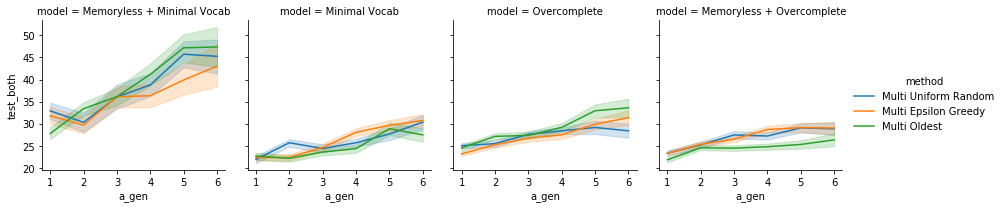

In [80]:
g = sns.FacetGrid(data=dfg[dfg.a_gen >= 1], col='model', hue='method')
g.map(sns.lineplot, 'a_gen', 'test_both')
g.add_legend()

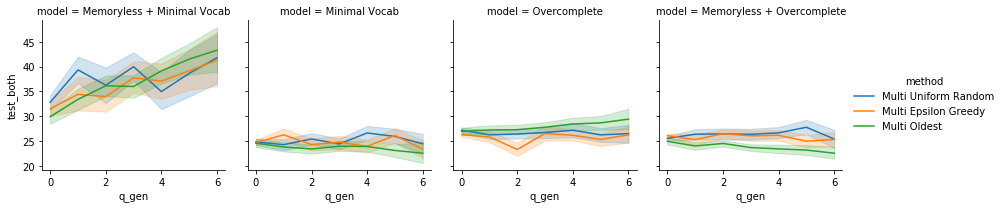

In [81]:
g = sns.FacetGrid(data=dfg[dfg.a_gen >= 1], col='model', hue='method')
g.map(sns.lineplot, 'q_gen', 'test_both')
g.add_legend()